In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [3]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('/content/drive/MyDrive/SI 630 project')
# os.listdir('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')


['sct',
 'text',
 'original - unedited version of edited files',
 'meddra - unedited version of edited files',
 'sct - unedited version of edited files',
 'original',
 'meddra']

In [5]:
suf = '_v3'

data_save_dir = 'data'+suf

suf += '_Bio_ClinicalBERT'

In [6]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [7]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [8]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/I-ADR/I-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/I-ADR/I-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/I-ADR/I-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [9]:
len(docs)

1186

In [10]:
temp = docs[0]
temp

Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/I-ADR/I-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/I-ADR/I-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/I-ADR/I-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"/

In [11]:
temp.annotation_layers

{'ner': ['Token[0]: "i"'/'O' (1.0),
  'Token[1]: "feel"'/'O' (1.0),
  'Token[2]: "a"'/'O' (1.0),
  'Token[3]: "bit"'/'B-ADR' (1.0),
  'Token[4]: "drowsy"'/'I-ADR' (1.0),
  'Token[5]: "&"'/'O' (1.0),
  'Token[6]: "have"'/'O' (1.0),
  'Token[7]: "a"'/'O' (1.0),
  'Token[8]: "little"'/'B-ADR' (1.0),
  'Token[9]: "blurred"'/'I-ADR' (1.0),
  'Token[10]: "vision"'/'I-ADR' (1.0),
  'Token[11]: ","'/'O' (1.0),
  'Token[12]: "so"'/'O' (1.0),
  'Token[13]: "far"'/'O' (1.0),
  'Token[14]: "no"'/'O' (1.0),
  'Token[15]: "gastric"'/'B-ADR' (1.0),
  'Token[16]: "problems"'/'I-ADR' (1.0),
  'Token[17]: "."'/'O' (1.0),
  'Token[18]: "ive"'/'O' (1.0),
  'Token[19]: "been"'/'O' (1.0),
  'Token[20]: "on"'/'O' (1.0),
  'Token[21]: "arthrotec"'/'B-Drug' (1.0),
  'Token[22]: "50"'/'O' (1.0),
  'Token[23]: "for"'/'O' (1.0),
  'Token[24]: "over"'/'O' (1.0),
  'Token[25]: "10"'/'O' (1.0),
  'Token[26]: "years"'/'O' (1.0),
  'Token[27]: "on"'/'O' (1.0),
  'Token[28]: "and"'/'O' (1.0),
  'Token[29]: "off"'/'O' (

In [12]:

# define your NER tags
label_dict = {
    'ADR': 'ADR',
    'Drug': 'Drug',
    'Finding': 'Finding',
    'Symptom': 'Symptom',
    'Disease': 'Disease'
}

In [13]:
from flair.data import Corpus
# from flair.datasets import SentenceDataset
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW, SGD

from flair.visual.training_curves import Plotter
plotter = Plotter()



train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

corpus = Corpus(train=train_docs, dev=dev_docs, test=test_docs) # Corpus: 948 train + 119 dev + 119 test sentences
corpus.filter_empty_sentences()
# # create a tag dictionary
labels = ['ADR', 'Drug', 'Finding', 'Symptom', 'Disease']
# tag_dictionary = Dictionary(add_unk=True)
# for label in labels:
#     tag_dictionary.add_item(label)
tag_dictionary = corpus.make_label_dictionary(label_type='ner')
print(tag_dictionary.span_labels)

# create a stacked embedding using GloVe and Flair embeddings
# stacked_embeddings = StackedEmbeddings([
#     WordEmbeddings('glove',
#                    force_cpu=False,
#                 #    embedding_length=1024,
#                   #  fine_tune=True,
#                    ),
#     # TransformerWordEmbeddings('emilyalsentzer/Bio_ClinicalBERT', layers="-1",
#     #                                    subtoken_pooling="first",
#     #                                    is_document_embedding=True,
#     #                                    fine_tune=True,
#     #                                    use_context=True,
#     #                                    max_seq_length=1024,
#     #                                    ),
#     FlairEmbeddings('news-forward',
#                     # fine_tune=True
#                     ),
#     FlairEmbeddings('news-backward',
#                     # fine_tune=True
#                     ),
# ])
# https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/FLAIR_EMBEDDINGS.md


embeddings = TransformerWordEmbeddings(model='emilyalsentzer/Bio_ClinicalBERT',
                                       layers="-1",
                                       subtoken_pooling="first",
                                       fine_tune=True,
                                       use_context=True,
                                       force_max_length=True,
                                      #  truncate=True, # not accepted here
                                      # #  is_document_embedding=True, # False is default
                                      #  allow_long_sentences=True, # True is default; doesnt go through
                                      #  embedding_length=512,
                                       )
# embeddings.allow_long_sentences = False
embeddings.truncate = True
# embeddings.embedding_length_internal = 512
print(embeddings.force_max_length,embeddings.truncate,embeddings.allow_long_sentences,embeddings.embedding_length_internal)
embeddings.tokenizer.model_max_length=512
print(embeddings.to_args())
print(embeddings.tokenizer)


# create a SequenceTagger object and specify the tag dictionary and embeddings to use
tagger = SequenceTagger(hidden_size=256,
                        # embeddings=stacked_embeddings,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type='ner',
                        use_crf=False,
                        use_rnn=False,
                        # reproject_embeddings=False
                        )
tagger.predict_spans = False

print(tagger._determine_if_span_prediction_problem(tagger.label_dictionary))
print(tagger.predict_spans)

# https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
# create a ModelTrainer object and train the tagger
trainer = ModelTrainer(tagger, corpus)

2023-04-21 16:47:49,281 Filtering empty sentences
2023-04-21 16:47:49,302 Corpus: 948 train + 119 dev + 119 test sentences
2023-04-21 16:47:49,304 Computing label dictionary. Progress:


948it [00:00, 6456.14it/s]

2023-04-21 16:47:49,456 Dictionary created for label 'ner' with 12 values: O (seen 79057 times), I-ADR (seen 7953 times), B-ADR (seen 4712 times), B-Drug (seen 1396 times), I-Finding (seen 349 times), B-Finding (seen 309 times), B-Disease (seen 231 times), B-Symptom (seen 222 times), I-Symptom (seen 218 times), I-Disease (seen 169 times), I-Drug (seen 161 times)
False


True True False 768
{'is_token_embedding': True, 'is_document_embedding': False, 'allow_long_sentences': False, 'tokenizer': BertTokenizerFast(name_or_path='emilyalsentzer/Bio_ClinicalBERT', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[FLERT]']}, clean_up_tokenization_spaces=True), 'context_length': 64, 'context_dropout': 0.5, 'respect_document_boundaries': True, 'truncate': True, 'stride': 0, 'embedding_length': 768, 'name': 'transformer-emilyalsentzer/Bio_ClinicalBERT', 'fine_tune': True, 'use_lang_emb': False, 'force_max_length': True, 'feature_extractor': None, 'use_context_separator': True, 'needs_manual_ocr': False}
BertTokenizerFast(name_or_path='emilyalsentzer/Bio_ClinicalBERT', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_s

In [14]:
# !tensorboard --logdir=runs
# http://localhost:6006/

In [15]:
hist = trainer.train('flair_ner_model'+suf,
              embeddings_storage_mode='gpu',
              gold_label_dictionary_for_eval=tag_dictionary,
              mini_batch_size = 40,
              eval_batch_size = 40,
              patience=1,
              anneal_factor = 0.8,
              anneal_against_dev_loss=True,
              main_evaluation_metric = ("weighted avg", "f1-score"),
              metrics_for_tensorboard=[("weighted avg", 'precision'), ("weighted avg", 'recall'), ("macro avg", 'f1-score'), ("macro avg", 'precision'), ("macro avg", 'recall')],
              use_tensorboard=True,
              tensorboard_comment='Flair NER',
              tensorboard_log_dir='runs/tb_logs'+suf,
              min_learning_rate=3e-8,
              optimizer=AdamW,
              learning_rate=5.0e-6,
              weight_decay=0.001,
              max_epochs=100,
              monitor_train=True,
              save_optimizer_state=True,)
# hist

2023-04-21 16:47:54,374 tensorboard logging path is runs/tb_logs_v3_Bio_ClinicalBERT
2023-04-21 16:47:54,385 ----------------------------------------------------------------------------------------------------
2023-04-21 16:47:54,387 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28997, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Lin

100%|██████████| 24/24 [00:10<00:00,  2.21it/s]

2023-04-21 16:48:31,668 Evaluating as a multi-label problem: True


2023-04-21 16:48:34,521 TRAIN : loss 1.0014984607696533 - f1-score (weighted avg)  0.0


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

2023-04-21 16:48:36,012 Evaluating as a multi-label problem: False
2023-04-21 16:48:36,073 DEV : loss 0.9971427321434021 - f1-score (weighted avg)  0.0
2023-04-21 16:48:36,093 BAD EPOCHS (no improvement): 0
2023-04-21 16:48:36,097 saving best model


2023-04-21 16:48:39,058 ----------------------------------------------------------------------------------------------------
2023-04-21 16:48:41,155 epoch 2 - iter 2/24 - loss 1.14608215 - time (sec): 2.09 - samples/sec: 3724.43 - lr: 0.000005
2023-04-21 16:48:43,308 epoch 2 - iter 4/24 - loss 1.11580097 - time (sec): 4.25 - samples/sec: 3806.15 - lr: 0.000005
2023-04-21 16:48:45,387 epoch 2 - iter 6/24 - loss 1.08650284 - time (sec): 6.33 - samples/sec: 3583.29 - lr: 0.000005
2023-04-21 16:48:47,459 epoch 2 - iter 8/24 - loss 1.04818993 - time (sec): 8.40 - samples/sec: 3529.44 - lr: 0.000005
2023-04-21 16:48:49,517 epoch 2 - iter 10/24 - loss 1.00690019 - time (sec): 10.46 - samples/sec: 3614.63 - lr: 0.000005
2023-04-21 16:48:51,599 epoch 2 - iter 12/24 - loss 0.97730388 - time (sec): 12.54 - samples/sec: 3690.75 - lr: 0.000005
2023-04-21 16:48:53,971 epoch 2 - iter 14/24 - loss 0.95805906 - time (sec): 14.91 - samples/sec: 3677.87 - lr: 0.000005
2023-04-21 16:48:56,042 epoch 2 - it

100%|██████████| 24/24 [00:09<00:00,  2.42it/s]

2023-04-21 16:49:14,431 Evaluating as a multi-label problem: True


2023-04-21 16:49:16,181 TRAIN : loss 0.7047016620635986 - f1-score (weighted avg)  0.0


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

2023-04-21 16:49:17,668 Evaluating as a multi-label problem: False
2023-04-21 16:49:17,729 DEV : loss 0.702401340007782 - f1-score (weighted avg)  0.0
2023-04-21 16:49:17,747 BAD EPOCHS (no improvement): 0
2023-04-21 16:49:17,751 saving best model


2023-04-21 16:49:20,966 ----------------------------------------------------------------------------------------------------
2023-04-21 16:49:23,156 epoch 3 - iter 2/24 - loss 0.73595445 - time (sec): 2.19 - samples/sec: 3668.24 - lr: 0.000005
2023-04-21 16:49:25,250 epoch 3 - iter 4/24 - loss 0.73313225 - time (sec): 4.28 - samples/sec: 3917.38 - lr: 0.000005
2023-04-21 16:49:27,460 epoch 3 - iter 6/24 - loss 0.73548707 - time (sec): 6.49 - samples/sec: 3851.46 - lr: 0.000005
2023-04-21 16:49:29,571 epoch 3 - iter 8/24 - loss 0.72182638 - time (sec): 8.60 - samples/sec: 3854.81 - lr: 0.000005
2023-04-21 16:49:31,638 epoch 3 - iter 10/24 - loss 0.70858568 - time (sec): 10.67 - samples/sec: 3845.24 - lr: 0.000005
2023-04-21 16:49:34,031 epoch 3 - iter 12/24 - loss 0.71174960 - time (sec): 13.06 - samples/sec: 3890.13 - lr: 0.000005
2023-04-21 16:49:36,123 epoch 3 - iter 14/24 - loss 0.70494977 - time (sec): 15.16 - samples/sec: 3802.78 - lr: 0.000005
2023-04-21 16:49:38,223 epoch 3 - it

100%|██████████| 24/24 [00:10<00:00,  2.20it/s]

2023-04-21 16:49:57,409 Evaluating as a multi-label problem: True


2023-04-21 16:49:59,151 TRAIN : loss 0.5412646532058716 - f1-score (weighted avg)  0.0003


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

2023-04-21 16:50:01,599 Evaluating as a multi-label problem: False
2023-04-21 16:50:01,661 DEV : loss 0.5448171496391296 - f1-score (weighted avg)  0.0
2023-04-21 16:50:01,680 BAD EPOCHS (no improvement): 0
2023-04-21 16:50:01,684 saving best model


2023-04-21 16:50:04,898 ----------------------------------------------------------------------------------------------------
2023-04-21 16:50:07,039 epoch 4 - iter 2/24 - loss 0.61987458 - time (sec): 2.14 - samples/sec: 3563.40 - lr: 0.000005
2023-04-21 16:50:09,169 epoch 4 - iter 4/24 - loss 0.58387541 - time (sec): 4.27 - samples/sec: 3723.27 - lr: 0.000005
2023-04-21 16:50:11,333 epoch 4 - iter 6/24 - loss 0.56536660 - time (sec): 6.43 - samples/sec: 3903.40 - lr: 0.000005
2023-04-21 16:50:13,375 epoch 4 - iter 8/24 - loss 0.56575931 - time (sec): 8.48 - samples/sec: 3778.84 - lr: 0.000005
2023-04-21 16:50:15,543 epoch 4 - iter 10/24 - loss 0.55712261 - time (sec): 10.64 - samples/sec: 3832.78 - lr: 0.000005
2023-04-21 16:50:17,627 epoch 4 - iter 12/24 - loss 0.54909708 - time (sec): 12.73 - samples/sec: 3855.28 - lr: 0.000005
2023-04-21 16:50:19,855 epoch 4 - iter 14/24 - loss 0.54591005 - time (sec): 14.95 - samples/sec: 3841.21 - lr: 0.000005
2023-04-21 16:50:21,948 epoch 4 - it

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 16:50:40,448 Evaluating as a multi-label problem: True


2023-04-21 16:50:43,341 TRAIN : loss 0.4296320974826813 - f1-score (weighted avg)  0.3589


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:50:44,883 Evaluating as a multi-label problem: False
2023-04-21 16:50:44,950 DEV : loss 0.4465876519680023 - f1-score (weighted avg)  0.3372
2023-04-21 16:50:44,969 BAD EPOCHS (no improvement): 0
2023-04-21 16:50:44,973 saving best model


2023-04-21 16:50:48,202 ----------------------------------------------------------------------------------------------------
2023-04-21 16:50:50,387 epoch 5 - iter 2/24 - loss 0.47176597 - time (sec): 2.18 - samples/sec: 3544.43 - lr: 0.000005
2023-04-21 16:50:52,819 epoch 5 - iter 4/24 - loss 0.52517767 - time (sec): 4.62 - samples/sec: 3540.62 - lr: 0.000005
2023-04-21 16:50:54,883 epoch 5 - iter 6/24 - loss 0.50853980 - time (sec): 6.68 - samples/sec: 3625.65 - lr: 0.000005
2023-04-21 16:50:56,956 epoch 5 - iter 8/24 - loss 0.48751034 - time (sec): 8.75 - samples/sec: 3548.77 - lr: 0.000005
2023-04-21 16:50:59,066 epoch 5 - iter 10/24 - loss 0.47599848 - time (sec): 10.86 - samples/sec: 3676.63 - lr: 0.000005
2023-04-21 16:51:01,168 epoch 5 - iter 12/24 - loss 0.46643367 - time (sec): 12.96 - samples/sec: 3661.19 - lr: 0.000005
2023-04-21 16:51:03,213 epoch 5 - iter 14/24 - loss 0.45743508 - time (sec): 15.01 - samples/sec: 3719.46 - lr: 0.000005
2023-04-21 16:51:05,315 epoch 5 - it

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 16:51:23,690 Evaluating as a multi-label problem: True


2023-04-21 16:51:26,635 TRAIN : loss 0.3701850473880768 - f1-score (weighted avg)  0.5248


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:51:28,160 Evaluating as a multi-label problem: False
2023-04-21 16:51:28,227 DEV : loss 0.3883552551269531 - f1-score (weighted avg)  0.4981
2023-04-21 16:51:28,247 BAD EPOCHS (no improvement): 0
2023-04-21 16:51:28,251 saving best model


2023-04-21 16:51:31,459 ----------------------------------------------------------------------------------------------------
2023-04-21 16:51:33,753 epoch 6 - iter 2/24 - loss 0.43700221 - time (sec): 2.29 - samples/sec: 3253.74 - lr: 0.000005
2023-04-21 16:51:35,806 epoch 6 - iter 4/24 - loss 0.40009423 - time (sec): 4.35 - samples/sec: 3595.50 - lr: 0.000005
2023-04-21 16:51:37,848 epoch 6 - iter 6/24 - loss 0.40144419 - time (sec): 6.39 - samples/sec: 3585.83 - lr: 0.000005
2023-04-21 16:51:39,966 epoch 6 - iter 8/24 - loss 0.40243801 - time (sec): 8.51 - samples/sec: 3748.84 - lr: 0.000005
2023-04-21 16:51:42,021 epoch 6 - iter 10/24 - loss 0.39557777 - time (sec): 10.56 - samples/sec: 3803.23 - lr: 0.000005
2023-04-21 16:51:44,140 epoch 6 - iter 12/24 - loss 0.39024140 - time (sec): 12.68 - samples/sec: 3771.63 - lr: 0.000005
2023-04-21 16:51:46,527 epoch 6 - iter 14/24 - loss 0.39948335 - time (sec): 15.07 - samples/sec: 3757.82 - lr: 0.000005
2023-04-21 16:51:48,737 epoch 6 - it

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 16:52:07,165 Evaluating as a multi-label problem: True


2023-04-21 16:52:10,230 TRAIN : loss 0.33302438259124756 - f1-score (weighted avg)  0.5837


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 16:52:11,742 Evaluating as a multi-label problem: False
2023-04-21 16:52:11,810 DEV : loss 0.3545033931732178 - f1-score (weighted avg)  0.5508
2023-04-21 16:52:11,830 BAD EPOCHS (no improvement): 0
2023-04-21 16:52:11,835 saving best model


2023-04-21 16:52:14,985 ----------------------------------------------------------------------------------------------------
2023-04-21 16:52:17,092 epoch 7 - iter 2/24 - loss 0.34886959 - time (sec): 2.10 - samples/sec: 4134.22 - lr: 0.000005
2023-04-21 16:52:19,306 epoch 7 - iter 4/24 - loss 0.35639389 - time (sec): 4.32 - samples/sec: 3913.84 - lr: 0.000005
2023-04-21 16:52:21,366 epoch 7 - iter 6/24 - loss 0.35670454 - time (sec): 6.38 - samples/sec: 3999.22 - lr: 0.000005
2023-04-21 16:52:23,750 epoch 7 - iter 8/24 - loss 0.37631394 - time (sec): 8.76 - samples/sec: 3860.82 - lr: 0.000005
2023-04-21 16:52:25,848 epoch 7 - iter 10/24 - loss 0.36935926 - time (sec): 10.86 - samples/sec: 3780.85 - lr: 0.000005
2023-04-21 16:52:27,928 epoch 7 - iter 12/24 - loss 0.36753028 - time (sec): 12.94 - samples/sec: 3736.90 - lr: 0.000005
2023-04-21 16:52:29,974 epoch 7 - iter 14/24 - loss 0.36710466 - time (sec): 14.99 - samples/sec: 3685.39 - lr: 0.000005
2023-04-21 16:52:32,157 epoch 7 - it

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 16:52:50,502 Evaluating as a multi-label problem: True


2023-04-21 16:52:53,514 TRAIN : loss 0.30099642276763916 - f1-score (weighted avg)  0.635


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 16:52:55,019 Evaluating as a multi-label problem: False
2023-04-21 16:52:55,087 DEV : loss 0.3265227973461151 - f1-score (weighted avg)  0.5989
2023-04-21 16:52:55,106 BAD EPOCHS (no improvement): 0
2023-04-21 16:52:55,111 saving best model


2023-04-21 16:52:58,277 ----------------------------------------------------------------------------------------------------
2023-04-21 16:53:00,451 epoch 8 - iter 2/24 - loss 0.30571522 - time (sec): 2.17 - samples/sec: 3992.62 - lr: 0.000005
2023-04-21 16:53:02,552 epoch 8 - iter 4/24 - loss 0.31084503 - time (sec): 4.27 - samples/sec: 3758.45 - lr: 0.000005
2023-04-21 16:53:04,605 epoch 8 - iter 6/24 - loss 0.30907091 - time (sec): 6.33 - samples/sec: 3881.51 - lr: 0.000005
2023-04-21 16:53:06,784 epoch 8 - iter 8/24 - loss 0.30751920 - time (sec): 8.50 - samples/sec: 3881.35 - lr: 0.000005
2023-04-21 16:53:08,985 epoch 8 - iter 10/24 - loss 0.31633903 - time (sec): 10.71 - samples/sec: 3850.49 - lr: 0.000005
2023-04-21 16:53:11,060 epoch 8 - iter 12/24 - loss 0.32227983 - time (sec): 12.78 - samples/sec: 3827.42 - lr: 0.000005
2023-04-21 16:53:13,118 epoch 8 - iter 14/24 - loss 0.32294660 - time (sec): 14.84 - samples/sec: 3821.92 - lr: 0.000005
2023-04-21 16:53:15,171 epoch 8 - it

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:53:33,893 Evaluating as a multi-label problem: True


2023-04-21 16:53:36,961 TRAIN : loss 0.27741357684135437 - f1-score (weighted avg)  0.6664


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 16:53:38,504 Evaluating as a multi-label problem: False
2023-04-21 16:53:38,572 DEV : loss 0.30621859431266785 - f1-score (weighted avg)  0.6297
2023-04-21 16:53:38,593 BAD EPOCHS (no improvement): 0
2023-04-21 16:53:38,597 saving best model


2023-04-21 16:53:41,732 ----------------------------------------------------------------------------------------------------
2023-04-21 16:53:43,950 epoch 9 - iter 2/24 - loss 0.31688988 - time (sec): 2.22 - samples/sec: 3909.87 - lr: 0.000005
2023-04-21 16:53:45,967 epoch 9 - iter 4/24 - loss 0.32183026 - time (sec): 4.23 - samples/sec: 3615.54 - lr: 0.000005
2023-04-21 16:53:48,072 epoch 9 - iter 6/24 - loss 0.30351351 - time (sec): 6.34 - samples/sec: 3683.06 - lr: 0.000005
2023-04-21 16:53:50,229 epoch 9 - iter 8/24 - loss 0.30562408 - time (sec): 8.50 - samples/sec: 3698.73 - lr: 0.000005
2023-04-21 16:53:52,754 epoch 9 - iter 10/24 - loss 0.32439006 - time (sec): 11.02 - samples/sec: 3734.72 - lr: 0.000005
2023-04-21 16:53:54,884 epoch 9 - iter 12/24 - loss 0.31931659 - time (sec): 13.15 - samples/sec: 3779.33 - lr: 0.000005
2023-04-21 16:53:56,994 epoch 9 - iter 14/24 - loss 0.31622237 - time (sec): 15.26 - samples/sec: 3749.16 - lr: 0.000005
2023-04-21 16:53:59,043 epoch 9 - it

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:54:17,271 Evaluating as a multi-label problem: True


2023-04-21 16:54:20,326 TRAIN : loss 0.26389753818511963 - f1-score (weighted avg)  0.6839


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 16:54:21,841 Evaluating as a multi-label problem: False
2023-04-21 16:54:21,908 DEV : loss 0.2985420525074005 - f1-score (weighted avg)  0.6408
2023-04-21 16:54:21,927 BAD EPOCHS (no improvement): 0
2023-04-21 16:54:21,931 saving best model


2023-04-21 16:54:25,067 ----------------------------------------------------------------------------------------------------
2023-04-21 16:54:27,154 epoch 10 - iter 2/24 - loss 0.27668418 - time (sec): 2.09 - samples/sec: 3516.14 - lr: 0.000005
2023-04-21 16:54:29,359 epoch 10 - iter 4/24 - loss 0.26496635 - time (sec): 4.29 - samples/sec: 4057.68 - lr: 0.000005
2023-04-21 16:54:31,479 epoch 10 - iter 6/24 - loss 0.25945701 - time (sec): 6.41 - samples/sec: 3889.13 - lr: 0.000005
2023-04-21 16:54:33,519 epoch 10 - iter 8/24 - loss 0.26350975 - time (sec): 8.45 - samples/sec: 3790.29 - lr: 0.000005
2023-04-21 16:54:35,646 epoch 10 - iter 10/24 - loss 0.26190825 - time (sec): 10.58 - samples/sec: 3812.90 - lr: 0.000005
2023-04-21 16:54:37,759 epoch 10 - iter 12/24 - loss 0.26539202 - time (sec): 12.69 - samples/sec: 3808.66 - lr: 0.000005
2023-04-21 16:54:39,850 epoch 10 - iter 14/24 - loss 0.26436383 - time (sec): 14.78 - samples/sec: 3832.60 - lr: 0.000005
2023-04-21 16:54:41,978 epoch

100%|██████████| 24/24 [00:10<00:00,  2.33it/s]

2023-04-21 16:55:00,893 Evaluating as a multi-label problem: True


2023-04-21 16:55:02,720 TRAIN : loss 0.24874992668628693 - f1-score (weighted avg)  0.6971


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:55:04,242 Evaluating as a multi-label problem: False
2023-04-21 16:55:04,309 DEV : loss 0.2881459891796112 - f1-score (weighted avg)  0.65
2023-04-21 16:55:04,328 BAD EPOCHS (no improvement): 0
2023-04-21 16:55:04,332 saving best model


2023-04-21 16:55:07,550 ----------------------------------------------------------------------------------------------------
2023-04-21 16:55:09,818 epoch 11 - iter 2/24 - loss 0.26197433 - time (sec): 2.27 - samples/sec: 3647.19 - lr: 0.000005
2023-04-21 16:55:11,874 epoch 11 - iter 4/24 - loss 0.25881557 - time (sec): 4.32 - samples/sec: 3882.07 - lr: 0.000005
2023-04-21 16:55:14,035 epoch 11 - iter 6/24 - loss 0.26355811 - time (sec): 6.48 - samples/sec: 3780.75 - lr: 0.000005
2023-04-21 16:55:17,501 epoch 11 - iter 8/24 - loss 0.28763332 - time (sec): 9.95 - samples/sec: 3371.59 - lr: 0.000005
2023-04-21 16:55:19,650 epoch 11 - iter 10/24 - loss 0.28038742 - time (sec): 12.10 - samples/sec: 3456.39 - lr: 0.000005
2023-04-21 16:55:21,758 epoch 11 - iter 12/24 - loss 0.27213128 - time (sec): 14.21 - samples/sec: 3524.67 - lr: 0.000005
2023-04-21 16:55:23,840 epoch 11 - iter 14/24 - loss 0.26884462 - time (sec): 16.29 - samples/sec: 3550.67 - lr: 0.000005
2023-04-21 16:55:25,997 epoch

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 16:55:44,397 Evaluating as a multi-label problem: True


2023-04-21 16:55:47,408 TRAIN : loss 0.2429502308368683 - f1-score (weighted avg)  0.7026


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:55:48,946 Evaluating as a multi-label problem: False
2023-04-21 16:55:49,014 DEV : loss 0.2857285737991333 - f1-score (weighted avg)  0.6507
2023-04-21 16:55:49,033 BAD EPOCHS (no improvement): 0
2023-04-21 16:55:49,037 saving best model


2023-04-21 16:55:52,317 ----------------------------------------------------------------------------------------------------
2023-04-21 16:55:54,411 epoch 12 - iter 2/24 - loss 0.24659094 - time (sec): 2.09 - samples/sec: 3829.45 - lr: 0.000005
2023-04-21 16:55:56,486 epoch 12 - iter 4/24 - loss 0.24500154 - time (sec): 4.17 - samples/sec: 3641.06 - lr: 0.000005
2023-04-21 16:55:58,559 epoch 12 - iter 6/24 - loss 0.23915952 - time (sec): 6.24 - samples/sec: 3746.49 - lr: 0.000005
2023-04-21 16:56:00,654 epoch 12 - iter 8/24 - loss 0.23975035 - time (sec): 8.33 - samples/sec: 3864.60 - lr: 0.000005
2023-04-21 16:56:02,769 epoch 12 - iter 10/24 - loss 0.23601046 - time (sec): 10.45 - samples/sec: 3768.00 - lr: 0.000005
2023-04-21 16:56:05,126 epoch 12 - iter 12/24 - loss 0.25453607 - time (sec): 12.81 - samples/sec: 3672.71 - lr: 0.000005
2023-04-21 16:56:07,422 epoch 12 - iter 14/24 - loss 0.25725501 - time (sec): 15.10 - samples/sec: 3792.91 - lr: 0.000005
2023-04-21 16:56:09,484 epoch

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:56:27,922 Evaluating as a multi-label problem: True


2023-04-21 16:56:30,936 TRAIN : loss 0.2276505082845688 - f1-score (weighted avg)  0.7166


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 16:56:32,462 Evaluating as a multi-label problem: False
2023-04-21 16:56:32,531 DEV : loss 0.2762390971183777 - f1-score (weighted avg)  0.6592
2023-04-21 16:56:32,550 BAD EPOCHS (no improvement): 0
2023-04-21 16:56:32,554 saving best model


2023-04-21 16:56:35,685 ----------------------------------------------------------------------------------------------------
2023-04-21 16:56:37,966 epoch 13 - iter 2/24 - loss 0.22082416 - time (sec): 2.28 - samples/sec: 3488.86 - lr: 0.000005
2023-04-21 16:56:40,114 epoch 13 - iter 4/24 - loss 0.22538725 - time (sec): 4.43 - samples/sec: 3667.07 - lr: 0.000005
2023-04-21 16:56:42,156 epoch 13 - iter 6/24 - loss 0.23058652 - time (sec): 6.47 - samples/sec: 3720.54 - lr: 0.000005
2023-04-21 16:56:44,262 epoch 13 - iter 8/24 - loss 0.23500674 - time (sec): 8.58 - samples/sec: 3653.26 - lr: 0.000005
2023-04-21 16:56:46,384 epoch 13 - iter 10/24 - loss 0.23826648 - time (sec): 10.70 - samples/sec: 3753.95 - lr: 0.000005
2023-04-21 16:56:48,781 epoch 13 - iter 12/24 - loss 0.25986524 - time (sec): 13.09 - samples/sec: 3654.82 - lr: 0.000005
2023-04-21 16:56:51,107 epoch 13 - iter 14/24 - loss 0.26116998 - time (sec): 15.42 - samples/sec: 3678.27 - lr: 0.000005
2023-04-21 16:56:53,229 epoch

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 16:57:11,531 Evaluating as a multi-label problem: True


2023-04-21 16:57:14,553 TRAIN : loss 0.2184978574514389 - f1-score (weighted avg)  0.725


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 16:57:16,071 Evaluating as a multi-label problem: False
2023-04-21 16:57:16,143 DEV : loss 0.2717222571372986 - f1-score (weighted avg)  0.6626
2023-04-21 16:57:16,162 BAD EPOCHS (no improvement): 0
2023-04-21 16:57:16,166 saving best model


2023-04-21 16:57:19,451 ----------------------------------------------------------------------------------------------------
2023-04-21 16:57:21,557 epoch 14 - iter 2/24 - loss 0.25549115 - time (sec): 2.10 - samples/sec: 3642.06 - lr: 0.000005
2023-04-21 16:57:23,989 epoch 14 - iter 4/24 - loss 0.28316661 - time (sec): 4.54 - samples/sec: 3788.29 - lr: 0.000005
2023-04-21 16:57:26,148 epoch 14 - iter 6/24 - loss 0.26189950 - time (sec): 6.69 - samples/sec: 3792.55 - lr: 0.000005
2023-04-21 16:57:28,197 epoch 14 - iter 8/24 - loss 0.25435277 - time (sec): 8.74 - samples/sec: 3706.53 - lr: 0.000005
2023-04-21 16:57:30,441 epoch 14 - iter 10/24 - loss 0.25030294 - time (sec): 10.99 - samples/sec: 3688.72 - lr: 0.000005
2023-04-21 16:57:32,558 epoch 14 - iter 12/24 - loss 0.24980942 - time (sec): 13.10 - samples/sec: 3730.22 - lr: 0.000005
2023-04-21 16:57:34,726 epoch 14 - iter 14/24 - loss 0.24651126 - time (sec): 15.27 - samples/sec: 3736.89 - lr: 0.000005
2023-04-21 16:57:36,796 epoch

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 16:57:55,256 Evaluating as a multi-label problem: True


2023-04-21 16:57:57,118 TRAIN : loss 0.21191638708114624 - f1-score (weighted avg)  0.7293


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2023-04-21 16:57:59,682 Evaluating as a multi-label problem: False
2023-04-21 16:57:59,758 DEV : loss 0.26967212557792664 - f1-score (weighted avg)  0.6616
2023-04-21 16:57:59,778 BAD EPOCHS (no improvement): 0
2023-04-21 16:57:59,782 saving best model


2023-04-21 16:58:02,994 ----------------------------------------------------------------------------------------------------
2023-04-21 16:58:05,075 epoch 15 - iter 2/24 - loss 0.21921295 - time (sec): 2.08 - samples/sec: 3636.07 - lr: 0.000005
2023-04-21 16:58:07,181 epoch 15 - iter 4/24 - loss 0.21955451 - time (sec): 4.18 - samples/sec: 3559.02 - lr: 0.000005
2023-04-21 16:58:09,243 epoch 15 - iter 6/24 - loss 0.21491946 - time (sec): 6.25 - samples/sec: 3732.31 - lr: 0.000005
2023-04-21 16:58:11,360 epoch 15 - iter 8/24 - loss 0.22113102 - time (sec): 8.36 - samples/sec: 3707.81 - lr: 0.000005
2023-04-21 16:58:13,509 epoch 15 - iter 10/24 - loss 0.22049764 - time (sec): 10.51 - samples/sec: 3825.01 - lr: 0.000005
2023-04-21 16:58:15,583 epoch 15 - iter 12/24 - loss 0.22537429 - time (sec): 12.59 - samples/sec: 3779.96 - lr: 0.000005
2023-04-21 16:58:17,700 epoch 15 - iter 14/24 - loss 0.22474953 - time (sec): 14.70 - samples/sec: 3785.71 - lr: 0.000005
2023-04-21 16:58:19,969 epoch

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 16:58:38,578 Evaluating as a multi-label problem: True


2023-04-21 16:58:41,604 TRAIN : loss 0.20501959323883057 - f1-score (weighted avg)  0.7347


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:58:43,137 Evaluating as a multi-label problem: False
2023-04-21 16:58:43,204 DEV : loss 0.26915591955184937 - f1-score (weighted avg)  0.6612
2023-04-21 16:58:43,223 BAD EPOCHS (no improvement): 0
2023-04-21 16:58:43,227 saving best model


2023-04-21 16:58:46,369 ----------------------------------------------------------------------------------------------------
2023-04-21 16:58:48,806 epoch 16 - iter 2/24 - loss 0.31755384 - time (sec): 2.43 - samples/sec: 3591.94 - lr: 0.000005
2023-04-21 16:58:50,890 epoch 16 - iter 4/24 - loss 0.27102426 - time (sec): 4.52 - samples/sec: 3499.85 - lr: 0.000005
2023-04-21 16:58:53,137 epoch 16 - iter 6/24 - loss 0.26015348 - time (sec): 6.77 - samples/sec: 3558.81 - lr: 0.000005
2023-04-21 16:58:55,240 epoch 16 - iter 8/24 - loss 0.25096713 - time (sec): 8.87 - samples/sec: 3526.98 - lr: 0.000005
2023-04-21 16:58:57,428 epoch 16 - iter 10/24 - loss 0.24823290 - time (sec): 11.06 - samples/sec: 3495.49 - lr: 0.000005
2023-04-21 16:58:59,565 epoch 16 - iter 12/24 - loss 0.24244272 - time (sec): 13.19 - samples/sec: 3526.14 - lr: 0.000005
2023-04-21 16:59:01,702 epoch 16 - iter 14/24 - loss 0.23338745 - time (sec): 15.33 - samples/sec: 3577.00 - lr: 0.000005
2023-04-21 16:59:03,889 epoch

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 16:59:22,237 Evaluating as a multi-label problem: True


2023-04-21 16:59:25,285 TRAIN : loss 0.20301224291324615 - f1-score (weighted avg)  0.7353


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 16:59:26,817 Evaluating as a multi-label problem: False
2023-04-21 16:59:26,884 DEV : loss 0.2694757282733917 - f1-score (weighted avg)  0.6543
2023-04-21 16:59:26,903 BAD EPOCHS (no improvement): 1
2023-04-21 16:59:26,907 ----------------------------------------------------------------------------------------------------


2023-04-21 16:59:29,041 epoch 17 - iter 2/24 - loss 0.20602632 - time (sec): 2.13 - samples/sec: 3799.70 - lr: 0.000005
2023-04-21 16:59:31,097 epoch 17 - iter 4/24 - loss 0.20014074 - time (sec): 4.19 - samples/sec: 3743.23 - lr: 0.000005
2023-04-21 16:59:33,142 epoch 17 - iter 6/24 - loss 0.20618256 - time (sec): 6.23 - samples/sec: 3746.89 - lr: 0.000005
2023-04-21 16:59:35,271 epoch 17 - iter 8/24 - loss 0.20640713 - time (sec): 8.36 - samples/sec: 3724.35 - lr: 0.000005
2023-04-21 16:59:37,636 epoch 17 - iter 10/24 - loss 0.22280518 - time (sec): 10.73 - samples/sec: 3710.74 - lr: 0.000005
2023-04-21 16:59:39,725 epoch 17 - iter 12/24 - loss 0.22248854 - time (sec): 12.82 - samples/sec: 3771.77 - lr: 0.000005
2023-04-21 16:59:41,819 epoch 17 - iter 14/24 - loss 0.21798882 - time (sec): 14.91 - samples/sec: 3745.68 - lr: 0.000005
2023-04-21 16:59:43,924 epoch 17 - iter 16/24 - loss 0.21785458 - time (sec): 17.02 - samples/sec: 3761.10 - lr: 0.000005
2023-04-21 16:59:46,036 epoch 17

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:00:02,370 Evaluating as a multi-label problem: True


2023-04-21 17:00:05,406 TRAIN : loss 0.19314999878406525 - f1-score (weighted avg)  0.7456


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:00:06,933 Evaluating as a multi-label problem: False
2023-04-21 17:00:07,001 DEV : loss 0.26517966389656067 - f1-score (weighted avg)  0.6592
2023-04-21 17:00:07,021 BAD EPOCHS (no improvement): 0
2023-04-21 17:00:07,025 saving best model


2023-04-21 17:00:10,170 ----------------------------------------------------------------------------------------------------
2023-04-21 17:00:12,388 epoch 18 - iter 2/24 - loss 0.19680546 - time (sec): 2.22 - samples/sec: 3336.62 - lr: 0.000005
2023-04-21 17:00:14,470 epoch 18 - iter 4/24 - loss 0.20684551 - time (sec): 4.30 - samples/sec: 3319.01 - lr: 0.000005
2023-04-21 17:00:16,756 epoch 18 - iter 6/24 - loss 0.22623532 - time (sec): 6.58 - samples/sec: 3539.64 - lr: 0.000005
2023-04-21 17:00:18,860 epoch 18 - iter 8/24 - loss 0.22210853 - time (sec): 8.69 - samples/sec: 3565.33 - lr: 0.000005
2023-04-21 17:00:21,036 epoch 18 - iter 10/24 - loss 0.20876441 - time (sec): 10.86 - samples/sec: 3620.93 - lr: 0.000005
2023-04-21 17:00:23,182 epoch 18 - iter 12/24 - loss 0.21026769 - time (sec): 13.01 - samples/sec: 3681.32 - lr: 0.000005
2023-04-21 17:00:25,296 epoch 18 - iter 14/24 - loss 0.20821773 - time (sec): 15.12 - samples/sec: 3704.01 - lr: 0.000005
2023-04-21 17:00:27,360 epoch

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:00:45,891 Evaluating as a multi-label problem: True


2023-04-21 17:00:48,952 TRAIN : loss 0.18573273718357086 - f1-score (weighted avg)  0.7525


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:00:50,466 Evaluating as a multi-label problem: False
2023-04-21 17:00:50,535 DEV : loss 0.2619098126888275 - f1-score (weighted avg)  0.6663
2023-04-21 17:00:50,554 BAD EPOCHS (no improvement): 0
2023-04-21 17:00:50,558 saving best model


2023-04-21 17:00:53,731 ----------------------------------------------------------------------------------------------------
2023-04-21 17:00:55,827 epoch 19 - iter 2/24 - loss 0.19745182 - time (sec): 2.09 - samples/sec: 3552.04 - lr: 0.000005
2023-04-21 17:00:58,204 epoch 19 - iter 4/24 - loss 0.24051918 - time (sec): 4.47 - samples/sec: 3753.11 - lr: 0.000005
2023-04-21 17:01:00,290 epoch 19 - iter 6/24 - loss 0.23079459 - time (sec): 6.56 - samples/sec: 3767.53 - lr: 0.000005
2023-04-21 17:01:02,385 epoch 19 - iter 8/24 - loss 0.22228338 - time (sec): 8.65 - samples/sec: 3779.99 - lr: 0.000005
2023-04-21 17:01:04,441 epoch 19 - iter 10/24 - loss 0.21261749 - time (sec): 10.71 - samples/sec: 3779.59 - lr: 0.000005
2023-04-21 17:01:06,642 epoch 19 - iter 12/24 - loss 0.21054863 - time (sec): 12.91 - samples/sec: 3766.15 - lr: 0.000005
2023-04-21 17:01:08,877 epoch 19 - iter 14/24 - loss 0.21147869 - time (sec): 15.14 - samples/sec: 3767.37 - lr: 0.000005
2023-04-21 17:01:10,970 epoch

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:01:29,412 Evaluating as a multi-label problem: True


2023-04-21 17:01:32,460 TRAIN : loss 0.1801718920469284 - f1-score (weighted avg)  0.7579


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:01:33,986 Evaluating as a multi-label problem: False
2023-04-21 17:01:34,053 DEV : loss 0.26347246766090393 - f1-score (weighted avg)  0.6671
2023-04-21 17:01:34,074 BAD EPOCHS (no improvement): 1
2023-04-21 17:01:34,078 ----------------------------------------------------------------------------------------------------


2023-04-21 17:01:36,116 epoch 20 - iter 2/24 - loss 0.19047954 - time (sec): 2.04 - samples/sec: 3117.40 - lr: 0.000005
2023-04-21 17:01:38,486 epoch 20 - iter 4/24 - loss 0.23370806 - time (sec): 4.41 - samples/sec: 3372.64 - lr: 0.000005
2023-04-21 17:01:40,629 epoch 20 - iter 6/24 - loss 0.21365201 - time (sec): 6.55 - samples/sec: 3646.61 - lr: 0.000005
2023-04-21 17:01:42,687 epoch 20 - iter 8/24 - loss 0.20623186 - time (sec): 8.61 - samples/sec: 3624.94 - lr: 0.000005
2023-04-21 17:01:44,848 epoch 20 - iter 10/24 - loss 0.20762501 - time (sec): 10.77 - samples/sec: 3566.82 - lr: 0.000005
2023-04-21 17:01:46,973 epoch 20 - iter 12/24 - loss 0.20141281 - time (sec): 12.89 - samples/sec: 3584.28 - lr: 0.000005
2023-04-21 17:01:49,045 epoch 20 - iter 14/24 - loss 0.19859854 - time (sec): 14.97 - samples/sec: 3626.36 - lr: 0.000005
2023-04-21 17:01:51,304 epoch 20 - iter 16/24 - loss 0.20103169 - time (sec): 17.22 - samples/sec: 3670.44 - lr: 0.000005
2023-04-21 17:01:53,392 epoch 20

100%|██████████| 24/24 [00:09<00:00,  2.40it/s]

2023-04-21 17:02:09,467 Evaluating as a multi-label problem: True


2023-04-21 17:02:12,542 TRAIN : loss 0.17547939717769623 - f1-score (weighted avg)  0.7653


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:02:14,051 Evaluating as a multi-label problem: False
2023-04-21 17:02:14,117 DEV : loss 0.26229968667030334 - f1-score (weighted avg)  0.6742
2023-04-21 17:02:14,135 Epoch    20: reducing learning rate of group 0 to 4.0000e-06.
2023-04-21 17:02:14,138 BAD EPOCHS (no improvement): 2
2023-04-21 17:02:14,141 ----------------------------------------------------------------------------------------------------


2023-04-21 17:02:16,240 epoch 21 - iter 2/24 - loss 0.20427328 - time (sec): 2.10 - samples/sec: 3632.41 - lr: 0.000004
2023-04-21 17:02:18,263 epoch 21 - iter 4/24 - loss 0.20645166 - time (sec): 4.12 - samples/sec: 3520.36 - lr: 0.000004
2023-04-21 17:02:20,422 epoch 21 - iter 6/24 - loss 0.18495579 - time (sec): 6.28 - samples/sec: 3699.52 - lr: 0.000004
2023-04-21 17:02:22,807 epoch 21 - iter 8/24 - loss 0.20726781 - time (sec): 8.67 - samples/sec: 3746.10 - lr: 0.000004
2023-04-21 17:02:24,837 epoch 21 - iter 10/24 - loss 0.20193287 - time (sec): 10.69 - samples/sec: 3619.77 - lr: 0.000004
2023-04-21 17:02:26,946 epoch 21 - iter 12/24 - loss 0.20092579 - time (sec): 12.80 - samples/sec: 3656.87 - lr: 0.000004
2023-04-21 17:02:29,031 epoch 21 - iter 14/24 - loss 0.19984787 - time (sec): 14.89 - samples/sec: 3734.61 - lr: 0.000004
2023-04-21 17:02:31,261 epoch 21 - iter 16/24 - loss 0.20199584 - time (sec): 17.12 - samples/sec: 3722.77 - lr: 0.000004
2023-04-21 17:02:33,303 epoch 21

100%|██████████| 24/24 [00:10<00:00,  2.40it/s]

2023-04-21 17:02:49,512 Evaluating as a multi-label problem: True


2023-04-21 17:02:51,343 TRAIN : loss 0.17473894357681274 - f1-score (weighted avg)  0.7659


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2023-04-21 17:02:53,908 Evaluating as a multi-label problem: False
2023-04-21 17:02:53,975 DEV : loss 0.2632267475128174 - f1-score (weighted avg)  0.6727
2023-04-21 17:02:53,994 BAD EPOCHS (no improvement): 1
2023-04-21 17:02:53,998 ----------------------------------------------------------------------------------------------------


2023-04-21 17:02:56,120 epoch 22 - iter 2/24 - loss 0.19543740 - time (sec): 2.12 - samples/sec: 4146.09 - lr: 0.000004
2023-04-21 17:02:58,195 epoch 22 - iter 4/24 - loss 0.18890239 - time (sec): 4.20 - samples/sec: 3794.80 - lr: 0.000004
2023-04-21 17:03:00,469 epoch 22 - iter 6/24 - loss 0.18941090 - time (sec): 6.47 - samples/sec: 3793.99 - lr: 0.000004
2023-04-21 17:03:02,512 epoch 22 - iter 8/24 - loss 0.18707066 - time (sec): 8.51 - samples/sec: 3762.41 - lr: 0.000004
2023-04-21 17:03:04,576 epoch 22 - iter 10/24 - loss 0.18495998 - time (sec): 10.58 - samples/sec: 3765.72 - lr: 0.000004
2023-04-21 17:03:06,950 epoch 22 - iter 12/24 - loss 0.20386504 - time (sec): 12.95 - samples/sec: 3748.24 - lr: 0.000004
2023-04-21 17:03:09,008 epoch 22 - iter 14/24 - loss 0.19944297 - time (sec): 15.01 - samples/sec: 3763.64 - lr: 0.000004
2023-04-21 17:03:11,073 epoch 22 - iter 16/24 - loss 0.19761794 - time (sec): 17.07 - samples/sec: 3764.51 - lr: 0.000004
2023-04-21 17:03:13,175 epoch 22

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:03:29,441 Evaluating as a multi-label problem: True


2023-04-21 17:03:32,462 TRAIN : loss 0.16334496438503265 - f1-score (weighted avg)  0.7812


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:03:33,975 Evaluating as a multi-label problem: False
2023-04-21 17:03:34,051 DEV : loss 0.2634033262729645 - f1-score (weighted avg)  0.6796
2023-04-21 17:03:34,071 Epoch    22: reducing learning rate of group 0 to 3.2000e-06.
2023-04-21 17:03:34,073 BAD EPOCHS (no improvement): 2
2023-04-21 17:03:34,076 ----------------------------------------------------------------------------------------------------


2023-04-21 17:03:36,138 epoch 23 - iter 2/24 - loss 0.20289997 - time (sec): 2.06 - samples/sec: 3531.58 - lr: 0.000003
2023-04-21 17:03:38,496 epoch 23 - iter 4/24 - loss 0.23286946 - time (sec): 4.42 - samples/sec: 3663.11 - lr: 0.000003
2023-04-21 17:03:40,580 epoch 23 - iter 6/24 - loss 0.21870707 - time (sec): 6.50 - samples/sec: 3707.81 - lr: 0.000003
2023-04-21 17:03:42,632 epoch 23 - iter 8/24 - loss 0.21009698 - time (sec): 8.55 - samples/sec: 3680.42 - lr: 0.000003
2023-04-21 17:03:44,850 epoch 23 - iter 10/24 - loss 0.20609717 - time (sec): 10.77 - samples/sec: 3681.00 - lr: 0.000003
2023-04-21 17:03:46,978 epoch 23 - iter 12/24 - loss 0.19807973 - time (sec): 12.90 - samples/sec: 3668.42 - lr: 0.000003
2023-04-21 17:03:49,091 epoch 23 - iter 14/24 - loss 0.19279137 - time (sec): 15.01 - samples/sec: 3725.80 - lr: 0.000003
2023-04-21 17:03:51,142 epoch 23 - iter 16/24 - loss 0.18804625 - time (sec): 17.06 - samples/sec: 3720.09 - lr: 0.000003
2023-04-21 17:03:53,387 epoch 23

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:04:09,587 Evaluating as a multi-label problem: True


2023-04-21 17:04:12,596 TRAIN : loss 0.16000136733055115 - f1-score (weighted avg)  0.7846


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:04:14,135 Evaluating as a multi-label problem: False
2023-04-21 17:04:14,202 DEV : loss 0.2615758180618286 - f1-score (weighted avg)  0.6823
2023-04-21 17:04:14,221 BAD EPOCHS (no improvement): 0
2023-04-21 17:04:14,225 saving best model


2023-04-21 17:04:17,513 ----------------------------------------------------------------------------------------------------
2023-04-21 17:04:19,664 epoch 24 - iter 2/24 - loss 0.16829390 - time (sec): 2.15 - samples/sec: 3842.55 - lr: 0.000003
2023-04-21 17:04:21,814 epoch 24 - iter 4/24 - loss 0.15000214 - time (sec): 4.30 - samples/sec: 3810.00 - lr: 0.000003
2023-04-21 17:04:23,863 epoch 24 - iter 6/24 - loss 0.16643233 - time (sec): 6.35 - samples/sec: 3596.14 - lr: 0.000003
2023-04-21 17:04:25,982 epoch 24 - iter 8/24 - loss 0.16737616 - time (sec): 8.47 - samples/sec: 3536.02 - lr: 0.000003
2023-04-21 17:04:28,073 epoch 24 - iter 10/24 - loss 0.16969946 - time (sec): 10.56 - samples/sec: 3602.79 - lr: 0.000003
2023-04-21 17:04:30,105 epoch 24 - iter 12/24 - loss 0.17151780 - time (sec): 12.59 - samples/sec: 3583.27 - lr: 0.000003
2023-04-21 17:04:32,178 epoch 24 - iter 14/24 - loss 0.16952194 - time (sec): 14.66 - samples/sec: 3615.32 - lr: 0.000003
2023-04-21 17:04:34,345 epoch

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:04:53,067 Evaluating as a multi-label problem: True


2023-04-21 17:04:56,107 TRAIN : loss 0.1576726734638214 - f1-score (weighted avg)  0.7894


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:04:57,633 Evaluating as a multi-label problem: False
2023-04-21 17:04:57,702 DEV : loss 0.2632157504558563 - f1-score (weighted avg)  0.6867
2023-04-21 17:04:57,722 BAD EPOCHS (no improvement): 1
2023-04-21 17:04:57,727 ----------------------------------------------------------------------------------------------------


2023-04-21 17:04:59,904 epoch 25 - iter 2/24 - loss 0.16040134 - time (sec): 2.18 - samples/sec: 4228.20 - lr: 0.000003
2023-04-21 17:05:02,021 epoch 25 - iter 4/24 - loss 0.16801733 - time (sec): 4.29 - samples/sec: 3884.22 - lr: 0.000003
2023-04-21 17:05:04,248 epoch 25 - iter 6/24 - loss 0.18570929 - time (sec): 6.52 - samples/sec: 3753.69 - lr: 0.000003
2023-04-21 17:05:06,311 epoch 25 - iter 8/24 - loss 0.18111643 - time (sec): 8.58 - samples/sec: 3657.09 - lr: 0.000003
2023-04-21 17:05:08,419 epoch 25 - iter 10/24 - loss 0.17825838 - time (sec): 10.69 - samples/sec: 3812.17 - lr: 0.000003
2023-04-21 17:05:10,479 epoch 25 - iter 12/24 - loss 0.17477048 - time (sec): 12.75 - samples/sec: 3732.21 - lr: 0.000003
2023-04-21 17:05:12,515 epoch 25 - iter 14/24 - loss 0.17391512 - time (sec): 14.79 - samples/sec: 3745.01 - lr: 0.000003
2023-04-21 17:05:14,626 epoch 25 - iter 16/24 - loss 0.17721180 - time (sec): 16.90 - samples/sec: 3801.13 - lr: 0.000003
2023-04-21 17:05:16,717 epoch 25

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:05:33,154 Evaluating as a multi-label problem: True


2023-04-21 17:05:36,193 TRAIN : loss 0.1567198783159256 - f1-score (weighted avg)  0.7896


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 17:05:37,742 Evaluating as a multi-label problem: False
2023-04-21 17:05:37,809 DEV : loss 0.2606967091560364 - f1-score (weighted avg)  0.6905
2023-04-21 17:05:37,829 BAD EPOCHS (no improvement): 0
2023-04-21 17:05:37,833 saving best model


2023-04-21 17:05:41,104 ----------------------------------------------------------------------------------------------------
2023-04-21 17:05:43,276 epoch 26 - iter 2/24 - loss 0.17370874 - time (sec): 2.17 - samples/sec: 3603.49 - lr: 0.000003
2023-04-21 17:05:45,316 epoch 26 - iter 4/24 - loss 0.17787060 - time (sec): 4.21 - samples/sec: 3709.70 - lr: 0.000003
2023-04-21 17:05:47,431 epoch 26 - iter 6/24 - loss 0.17135708 - time (sec): 6.32 - samples/sec: 3747.00 - lr: 0.000003
2023-04-21 17:05:49,528 epoch 26 - iter 8/24 - loss 0.18153526 - time (sec): 8.42 - samples/sec: 3601.58 - lr: 0.000003
2023-04-21 17:05:51,610 epoch 26 - iter 10/24 - loss 0.18225668 - time (sec): 10.50 - samples/sec: 3751.44 - lr: 0.000003
2023-04-21 17:05:53,745 epoch 26 - iter 12/24 - loss 0.18127888 - time (sec): 12.64 - samples/sec: 3732.72 - lr: 0.000003
2023-04-21 17:05:56,137 epoch 26 - iter 14/24 - loss 0.19319640 - time (sec): 15.03 - samples/sec: 3691.72 - lr: 0.000003
2023-04-21 17:05:58,260 epoch

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 17:06:16,827 Evaluating as a multi-label problem: True


2023-04-21 17:06:18,686 TRAIN : loss 0.1502903401851654 - f1-score (weighted avg)  0.7982


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2023-04-21 17:06:21,261 Evaluating as a multi-label problem: False
2023-04-21 17:06:21,330 DEV : loss 0.26139914989471436 - f1-score (weighted avg)  0.6925
2023-04-21 17:06:21,350 BAD EPOCHS (no improvement): 1
2023-04-21 17:06:21,354 ----------------------------------------------------------------------------------------------------


2023-04-21 17:06:23,436 epoch 27 - iter 2/24 - loss 0.18516318 - time (sec): 2.08 - samples/sec: 3886.37 - lr: 0.000003
2023-04-21 17:06:25,519 epoch 27 - iter 4/24 - loss 0.18955293 - time (sec): 4.16 - samples/sec: 4154.61 - lr: 0.000003
2023-04-21 17:06:27,671 epoch 27 - iter 6/24 - loss 0.17699956 - time (sec): 6.32 - samples/sec: 4008.48 - lr: 0.000003
2023-04-21 17:06:30,039 epoch 27 - iter 8/24 - loss 0.19754688 - time (sec): 8.68 - samples/sec: 3886.99 - lr: 0.000003
2023-04-21 17:06:32,075 epoch 27 - iter 10/24 - loss 0.18636318 - time (sec): 10.72 - samples/sec: 3796.62 - lr: 0.000003
2023-04-21 17:06:34,105 epoch 27 - iter 12/24 - loss 0.18106380 - time (sec): 12.75 - samples/sec: 3787.66 - lr: 0.000003
2023-04-21 17:06:36,393 epoch 27 - iter 14/24 - loss 0.18250396 - time (sec): 15.04 - samples/sec: 3738.16 - lr: 0.000003
2023-04-21 17:06:38,445 epoch 27 - iter 16/24 - loss 0.18122761 - time (sec): 17.09 - samples/sec: 3765.10 - lr: 0.000003
2023-04-21 17:06:40,581 epoch 27

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:06:56,860 Evaluating as a multi-label problem: True


2023-04-21 17:06:59,843 TRAIN : loss 0.15049158036708832 - f1-score (weighted avg)  0.7994


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:07:01,355 Evaluating as a multi-label problem: False
2023-04-21 17:07:01,423 DEV : loss 0.2608695328235626 - f1-score (weighted avg)  0.6959
2023-04-21 17:07:01,442 Epoch    27: reducing learning rate of group 0 to 2.5600e-06.
2023-04-21 17:07:01,444 BAD EPOCHS (no improvement): 2
2023-04-21 17:07:01,447 ----------------------------------------------------------------------------------------------------


2023-04-21 17:07:03,499 epoch 28 - iter 2/24 - loss 0.15636337 - time (sec): 2.05 - samples/sec: 3820.73 - lr: 0.000003
2023-04-21 17:07:05,566 epoch 28 - iter 4/24 - loss 0.15187672 - time (sec): 4.12 - samples/sec: 3864.67 - lr: 0.000003
2023-04-21 17:07:07,780 epoch 28 - iter 6/24 - loss 0.14953964 - time (sec): 6.33 - samples/sec: 3859.95 - lr: 0.000003
2023-04-21 17:07:09,896 epoch 28 - iter 8/24 - loss 0.15084780 - time (sec): 8.45 - samples/sec: 3853.49 - lr: 0.000003
2023-04-21 17:07:11,922 epoch 28 - iter 10/24 - loss 0.15570442 - time (sec): 10.47 - samples/sec: 3786.16 - lr: 0.000003
2023-04-21 17:07:13,963 epoch 28 - iter 12/24 - loss 0.16006775 - time (sec): 12.51 - samples/sec: 3782.93 - lr: 0.000003
2023-04-21 17:07:16,352 epoch 28 - iter 14/24 - loss 0.17750640 - time (sec): 14.90 - samples/sec: 3749.40 - lr: 0.000003
2023-04-21 17:07:18,653 epoch 28 - iter 16/24 - loss 0.17868216 - time (sec): 17.20 - samples/sec: 3758.62 - lr: 0.000003
2023-04-21 17:07:20,697 epoch 28

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:07:36,879 Evaluating as a multi-label problem: True


2023-04-21 17:07:39,883 TRAIN : loss 0.14514394104480743 - f1-score (weighted avg)  0.8064


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:07:41,400 Evaluating as a multi-label problem: False
2023-04-21 17:07:41,466 DEV : loss 0.2633368968963623 - f1-score (weighted avg)  0.6985
2023-04-21 17:07:41,485 BAD EPOCHS (no improvement): 1
2023-04-21 17:07:41,488 ----------------------------------------------------------------------------------------------------


2023-04-21 17:07:43,570 epoch 29 - iter 2/24 - loss 0.16279533 - time (sec): 2.08 - samples/sec: 3792.98 - lr: 0.000003
2023-04-21 17:07:45,647 epoch 29 - iter 4/24 - loss 0.15577320 - time (sec): 4.16 - samples/sec: 3814.13 - lr: 0.000003
2023-04-21 17:07:47,741 epoch 29 - iter 6/24 - loss 0.16012240 - time (sec): 6.25 - samples/sec: 3710.27 - lr: 0.000003
2023-04-21 17:07:50,113 epoch 29 - iter 8/24 - loss 0.18331202 - time (sec): 8.62 - samples/sec: 3716.48 - lr: 0.000003
2023-04-21 17:07:52,284 epoch 29 - iter 10/24 - loss 0.17457058 - time (sec): 10.79 - samples/sec: 3798.98 - lr: 0.000003
2023-04-21 17:07:54,366 epoch 29 - iter 12/24 - loss 0.16910636 - time (sec): 12.88 - samples/sec: 3812.36 - lr: 0.000003
2023-04-21 17:07:56,632 epoch 29 - iter 14/24 - loss 0.17340046 - time (sec): 15.14 - samples/sec: 3787.21 - lr: 0.000003
2023-04-21 17:07:58,752 epoch 29 - iter 16/24 - loss 0.16995225 - time (sec): 17.26 - samples/sec: 3780.04 - lr: 0.000003
2023-04-21 17:08:00,842 epoch 29

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:08:16,958 Evaluating as a multi-label problem: True


2023-04-21 17:08:19,966 TRAIN : loss 0.142629474401474 - f1-score (weighted avg)  0.8091


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:08:21,483 Evaluating as a multi-label problem: False
2023-04-21 17:08:21,549 DEV : loss 0.26206472516059875 - f1-score (weighted avg)  0.701
2023-04-21 17:08:21,569 Epoch    29: reducing learning rate of group 0 to 2.0480e-06.
2023-04-21 17:08:21,571 BAD EPOCHS (no improvement): 2
2023-04-21 17:08:21,574 ----------------------------------------------------------------------------------------------------


2023-04-21 17:08:23,601 epoch 30 - iter 2/24 - loss 0.15789152 - time (sec): 2.02 - samples/sec: 3880.94 - lr: 0.000002
2023-04-21 17:08:25,715 epoch 30 - iter 4/24 - loss 0.15219885 - time (sec): 4.14 - samples/sec: 3888.09 - lr: 0.000002
2023-04-21 17:08:27,785 epoch 30 - iter 6/24 - loss 0.15034413 - time (sec): 6.21 - samples/sec: 3848.70 - lr: 0.000002
2023-04-21 17:08:29,917 epoch 30 - iter 8/24 - loss 0.14469757 - time (sec): 8.34 - samples/sec: 3894.55 - lr: 0.000002
2023-04-21 17:08:31,926 epoch 30 - iter 10/24 - loss 0.14941142 - time (sec): 10.35 - samples/sec: 3776.47 - lr: 0.000002
2023-04-21 17:08:34,115 epoch 30 - iter 12/24 - loss 0.14544074 - time (sec): 12.54 - samples/sec: 3690.27 - lr: 0.000002
2023-04-21 17:08:36,204 epoch 30 - iter 14/24 - loss 0.14615009 - time (sec): 14.63 - samples/sec: 3777.73 - lr: 0.000002
2023-04-21 17:08:38,556 epoch 30 - iter 16/24 - loss 0.16844113 - time (sec): 16.98 - samples/sec: 3686.55 - lr: 0.000002
2023-04-21 17:08:40,749 epoch 30

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:08:56,995 Evaluating as a multi-label problem: True


2023-04-21 17:09:00,029 TRAIN : loss 0.14165571331977844 - f1-score (weighted avg)  0.8105


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:09:01,551 Evaluating as a multi-label problem: False
2023-04-21 17:09:01,618 DEV : loss 0.264420747756958 - f1-score (weighted avg)  0.702
2023-04-21 17:09:01,637 BAD EPOCHS (no improvement): 1
2023-04-21 17:09:01,641 ----------------------------------------------------------------------------------------------------


2023-04-21 17:09:03,725 epoch 31 - iter 2/24 - loss 0.14322001 - time (sec): 2.08 - samples/sec: 3641.51 - lr: 0.000002
2023-04-21 17:09:05,981 epoch 31 - iter 4/24 - loss 0.16919476 - time (sec): 4.34 - samples/sec: 3723.76 - lr: 0.000002
2023-04-21 17:09:08,054 epoch 31 - iter 6/24 - loss 0.16549815 - time (sec): 6.41 - samples/sec: 3700.34 - lr: 0.000002
2023-04-21 17:09:10,210 epoch 31 - iter 8/24 - loss 0.15939214 - time (sec): 8.57 - samples/sec: 3825.84 - lr: 0.000002
2023-04-21 17:09:12,339 epoch 31 - iter 10/24 - loss 0.15668489 - time (sec): 10.70 - samples/sec: 3815.10 - lr: 0.000002
2023-04-21 17:09:14,434 epoch 31 - iter 12/24 - loss 0.15571150 - time (sec): 12.79 - samples/sec: 3798.93 - lr: 0.000002
2023-04-21 17:09:16,505 epoch 31 - iter 14/24 - loss 0.15561607 - time (sec): 14.86 - samples/sec: 3834.09 - lr: 0.000002
2023-04-21 17:09:18,568 epoch 31 - iter 16/24 - loss 0.15435752 - time (sec): 16.93 - samples/sec: 3781.24 - lr: 0.000002
2023-04-21 17:09:20,663 epoch 31

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:09:37,121 Evaluating as a multi-label problem: True


2023-04-21 17:09:40,165 TRAIN : loss 0.14024987816810608 - f1-score (weighted avg)  0.8138


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:09:41,670 Evaluating as a multi-label problem: False
2023-04-21 17:09:41,737 DEV : loss 0.2662420868873596 - f1-score (weighted avg)  0.7028
2023-04-21 17:09:41,757 Epoch    31: reducing learning rate of group 0 to 1.6384e-06.
2023-04-21 17:09:41,759 BAD EPOCHS (no improvement): 2
2023-04-21 17:09:41,763 ----------------------------------------------------------------------------------------------------


2023-04-21 17:09:43,826 epoch 32 - iter 2/24 - loss 0.16335623 - time (sec): 2.06 - samples/sec: 4083.91 - lr: 0.000002
2023-04-21 17:09:45,886 epoch 32 - iter 4/24 - loss 0.14919014 - time (sec): 4.12 - samples/sec: 3867.02 - lr: 0.000002
2023-04-21 17:09:48,049 epoch 32 - iter 6/24 - loss 0.14471778 - time (sec): 6.28 - samples/sec: 3730.29 - lr: 0.000002
2023-04-21 17:09:50,147 epoch 32 - iter 8/24 - loss 0.14342603 - time (sec): 8.38 - samples/sec: 3751.63 - lr: 0.000002
2023-04-21 17:09:52,242 epoch 32 - iter 10/24 - loss 0.14594622 - time (sec): 10.48 - samples/sec: 3781.97 - lr: 0.000002
2023-04-21 17:09:54,343 epoch 32 - iter 12/24 - loss 0.14644160 - time (sec): 12.58 - samples/sec: 3801.47 - lr: 0.000002
2023-04-21 17:09:56,407 epoch 32 - iter 14/24 - loss 0.14619183 - time (sec): 14.64 - samples/sec: 3812.75 - lr: 0.000002
2023-04-21 17:09:58,411 epoch 32 - iter 16/24 - loss 0.14615198 - time (sec): 16.65 - samples/sec: 3753.15 - lr: 0.000002
2023-04-21 17:10:00,751 epoch 32

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:10:17,166 Evaluating as a multi-label problem: True


2023-04-21 17:10:19,018 TRAIN : loss 0.14122430980205536 - f1-score (weighted avg)  0.8131


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2023-04-21 17:10:21,557 Evaluating as a multi-label problem: False
2023-04-21 17:10:21,625 DEV : loss 0.2659316062927246 - f1-score (weighted avg)  0.7043
2023-04-21 17:10:21,644 BAD EPOCHS (no improvement): 1
2023-04-21 17:10:21,648 ----------------------------------------------------------------------------------------------------


2023-04-21 17:10:23,746 epoch 33 - iter 2/24 - loss 0.15192505 - time (sec): 2.10 - samples/sec: 3914.24 - lr: 0.000002
2023-04-21 17:10:25,796 epoch 33 - iter 4/24 - loss 0.14517413 - time (sec): 4.15 - samples/sec: 3801.86 - lr: 0.000002
2023-04-21 17:10:27,912 epoch 33 - iter 6/24 - loss 0.13685415 - time (sec): 6.26 - samples/sec: 3827.53 - lr: 0.000002
2023-04-21 17:10:29,993 epoch 33 - iter 8/24 - loss 0.14708670 - time (sec): 8.34 - samples/sec: 3845.59 - lr: 0.000002
2023-04-21 17:10:32,044 epoch 33 - iter 10/24 - loss 0.14414033 - time (sec): 10.39 - samples/sec: 3800.23 - lr: 0.000002
2023-04-21 17:10:34,140 epoch 33 - iter 12/24 - loss 0.14365202 - time (sec): 12.49 - samples/sec: 3846.98 - lr: 0.000002
2023-04-21 17:10:36,250 epoch 33 - iter 14/24 - loss 0.14358813 - time (sec): 14.60 - samples/sec: 3835.98 - lr: 0.000002
2023-04-21 17:10:38,381 epoch 33 - iter 16/24 - loss 0.14169775 - time (sec): 16.73 - samples/sec: 3824.53 - lr: 0.000002
2023-04-21 17:10:40,842 epoch 33

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:10:57,149 Evaluating as a multi-label problem: True


2023-04-21 17:11:00,174 TRAIN : loss 0.1365891396999359 - f1-score (weighted avg)  0.8191


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:11:01,704 Evaluating as a multi-label problem: False
2023-04-21 17:11:01,772 DEV : loss 0.2656829059123993 - f1-score (weighted avg)  0.7088
2023-04-21 17:11:01,791 Epoch    33: reducing learning rate of group 0 to 1.3107e-06.
2023-04-21 17:11:01,793 BAD EPOCHS (no improvement): 2
2023-04-21 17:11:01,796 ----------------------------------------------------------------------------------------------------


2023-04-21 17:11:03,923 epoch 34 - iter 2/24 - loss 0.13310845 - time (sec): 2.13 - samples/sec: 3613.70 - lr: 0.000001
2023-04-21 17:11:05,941 epoch 34 - iter 4/24 - loss 0.14189541 - time (sec): 4.14 - samples/sec: 3551.38 - lr: 0.000001
2023-04-21 17:11:08,046 epoch 34 - iter 6/24 - loss 0.13402643 - time (sec): 6.25 - samples/sec: 3583.52 - lr: 0.000001
2023-04-21 17:11:10,289 epoch 34 - iter 8/24 - loss 0.14566046 - time (sec): 8.49 - samples/sec: 3544.17 - lr: 0.000001
2023-04-21 17:11:12,423 epoch 34 - iter 10/24 - loss 0.14566345 - time (sec): 10.63 - samples/sec: 3695.11 - lr: 0.000001
2023-04-21 17:11:14,537 epoch 34 - iter 12/24 - loss 0.14903632 - time (sec): 12.74 - samples/sec: 3685.18 - lr: 0.000001
2023-04-21 17:11:16,616 epoch 34 - iter 14/24 - loss 0.15038724 - time (sec): 14.82 - samples/sec: 3697.08 - lr: 0.000001
2023-04-21 17:11:18,996 epoch 34 - iter 16/24 - loss 0.16593879 - time (sec): 17.20 - samples/sec: 3717.58 - lr: 0.000001
2023-04-21 17:11:21,091 epoch 34

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:11:37,288 Evaluating as a multi-label problem: True


2023-04-21 17:11:40,319 TRAIN : loss 0.13402067124843597 - f1-score (weighted avg)  0.8215


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:11:41,841 Evaluating as a multi-label problem: False
2023-04-21 17:11:41,909 DEV : loss 0.26755988597869873 - f1-score (weighted avg)  0.7062
2023-04-21 17:11:41,928 BAD EPOCHS (no improvement): 1
2023-04-21 17:11:41,932 ----------------------------------------------------------------------------------------------------


2023-04-21 17:11:43,986 epoch 35 - iter 2/24 - loss 0.14255277 - time (sec): 2.05 - samples/sec: 3809.42 - lr: 0.000001
2023-04-21 17:11:46,107 epoch 35 - iter 4/24 - loss 0.13925848 - time (sec): 4.17 - samples/sec: 3809.58 - lr: 0.000001
2023-04-21 17:11:48,161 epoch 35 - iter 6/24 - loss 0.14100813 - time (sec): 6.23 - samples/sec: 3823.89 - lr: 0.000001
2023-04-21 17:11:50,312 epoch 35 - iter 8/24 - loss 0.13941641 - time (sec): 8.38 - samples/sec: 3778.36 - lr: 0.000001
2023-04-21 17:11:52,494 epoch 35 - iter 10/24 - loss 0.14434411 - time (sec): 10.56 - samples/sec: 3910.70 - lr: 0.000001
2023-04-21 17:11:54,767 epoch 35 - iter 12/24 - loss 0.15028862 - time (sec): 12.83 - samples/sec: 3836.84 - lr: 0.000001
2023-04-21 17:11:56,823 epoch 35 - iter 14/24 - loss 0.15132084 - time (sec): 14.89 - samples/sec: 3824.32 - lr: 0.000001
2023-04-21 17:11:58,876 epoch 35 - iter 16/24 - loss 0.15264017 - time (sec): 16.94 - samples/sec: 3796.86 - lr: 0.000001
2023-04-21 17:12:01,249 epoch 35

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:12:17,407 Evaluating as a multi-label problem: True


2023-04-21 17:12:20,455 TRAIN : loss 0.13475807011127472 - f1-score (weighted avg)  0.8209


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:12:21,982 Evaluating as a multi-label problem: False
2023-04-21 17:12:22,053 DEV : loss 0.2680826187133789 - f1-score (weighted avg)  0.7082
2023-04-21 17:12:22,073 Epoch    35: reducing learning rate of group 0 to 1.0486e-06.
2023-04-21 17:12:22,075 BAD EPOCHS (no improvement): 2
2023-04-21 17:12:22,079 ----------------------------------------------------------------------------------------------------


2023-04-21 17:12:24,138 epoch 36 - iter 2/24 - loss 0.16652450 - time (sec): 2.06 - samples/sec: 3975.35 - lr: 0.000001
2023-04-21 17:12:26,318 epoch 36 - iter 4/24 - loss 0.16020084 - time (sec): 4.24 - samples/sec: 3877.94 - lr: 0.000001
2023-04-21 17:12:28,360 epoch 36 - iter 6/24 - loss 0.16144842 - time (sec): 6.28 - samples/sec: 3752.03 - lr: 0.000001
2023-04-21 17:12:30,758 epoch 36 - iter 8/24 - loss 0.18798280 - time (sec): 8.68 - samples/sec: 3670.85 - lr: 0.000001
2023-04-21 17:12:32,892 epoch 36 - iter 10/24 - loss 0.17416800 - time (sec): 10.81 - samples/sec: 3774.25 - lr: 0.000001
2023-04-21 17:12:34,978 epoch 36 - iter 12/24 - loss 0.16886573 - time (sec): 12.90 - samples/sec: 3692.21 - lr: 0.000001
2023-04-21 17:12:37,126 epoch 36 - iter 14/24 - loss 0.16096759 - time (sec): 15.05 - samples/sec: 3818.70 - lr: 0.000001
2023-04-21 17:12:39,189 epoch 36 - iter 16/24 - loss 0.16022584 - time (sec): 17.11 - samples/sec: 3793.91 - lr: 0.000001
2023-04-21 17:12:41,259 epoch 36

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:12:57,641 Evaluating as a multi-label problem: True


2023-04-21 17:13:00,681 TRAIN : loss 0.13250567018985748 - f1-score (weighted avg)  0.8235


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:13:02,206 Evaluating as a multi-label problem: False
2023-04-21 17:13:02,275 DEV : loss 0.2664056718349457 - f1-score (weighted avg)  0.7095
2023-04-21 17:13:02,294 BAD EPOCHS (no improvement): 1
2023-04-21 17:13:02,298 ----------------------------------------------------------------------------------------------------


2023-04-21 17:13:04,403 epoch 37 - iter 2/24 - loss 0.15032841 - time (sec): 2.10 - samples/sec: 3625.22 - lr: 0.000001
2023-04-21 17:13:06,479 epoch 37 - iter 4/24 - loss 0.14677990 - time (sec): 4.18 - samples/sec: 3618.63 - lr: 0.000001
2023-04-21 17:13:08,812 epoch 37 - iter 6/24 - loss 0.18192036 - time (sec): 6.51 - samples/sec: 3519.71 - lr: 0.000001
2023-04-21 17:13:10,915 epoch 37 - iter 8/24 - loss 0.17213433 - time (sec): 8.62 - samples/sec: 3544.00 - lr: 0.000001
2023-04-21 17:13:13,027 epoch 37 - iter 10/24 - loss 0.16763800 - time (sec): 10.73 - samples/sec: 3566.45 - lr: 0.000001
2023-04-21 17:13:15,129 epoch 37 - iter 12/24 - loss 0.16279383 - time (sec): 12.83 - samples/sec: 3667.92 - lr: 0.000001
2023-04-21 17:13:17,228 epoch 37 - iter 14/24 - loss 0.16038765 - time (sec): 14.93 - samples/sec: 3748.99 - lr: 0.000001
2023-04-21 17:13:19,585 epoch 37 - iter 16/24 - loss 0.16594448 - time (sec): 17.29 - samples/sec: 3728.58 - lr: 0.000001
2023-04-21 17:13:21,659 epoch 37

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:13:37,899 Evaluating as a multi-label problem: True


2023-04-21 17:13:40,943 TRAIN : loss 0.13095971941947937 - f1-score (weighted avg)  0.8268


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:13:42,467 Evaluating as a multi-label problem: False
2023-04-21 17:13:42,536 DEV : loss 0.2681761384010315 - f1-score (weighted avg)  0.709
2023-04-21 17:13:42,555 Epoch    37: reducing learning rate of group 0 to 8.3886e-07.
2023-04-21 17:13:42,557 BAD EPOCHS (no improvement): 2
2023-04-21 17:13:42,560 ----------------------------------------------------------------------------------------------------


2023-04-21 17:13:44,707 epoch 38 - iter 2/24 - loss 0.14153139 - time (sec): 2.15 - samples/sec: 3843.31 - lr: 0.000001
2023-04-21 17:13:46,806 epoch 38 - iter 4/24 - loss 0.14130543 - time (sec): 4.24 - samples/sec: 3711.56 - lr: 0.000001
2023-04-21 17:13:48,888 epoch 38 - iter 6/24 - loss 0.15002923 - time (sec): 6.33 - samples/sec: 3714.54 - lr: 0.000001
2023-04-21 17:13:51,056 epoch 38 - iter 8/24 - loss 0.15021319 - time (sec): 8.49 - samples/sec: 3731.16 - lr: 0.000001
2023-04-21 17:13:53,163 epoch 38 - iter 10/24 - loss 0.14915480 - time (sec): 10.60 - samples/sec: 3697.80 - lr: 0.000001
2023-04-21 17:13:55,184 epoch 38 - iter 12/24 - loss 0.14643649 - time (sec): 12.62 - samples/sec: 3690.08 - lr: 0.000001
2023-04-21 17:13:57,267 epoch 38 - iter 14/24 - loss 0.14497792 - time (sec): 14.71 - samples/sec: 3719.80 - lr: 0.000001
2023-04-21 17:13:59,562 epoch 38 - iter 16/24 - loss 0.14840324 - time (sec): 17.00 - samples/sec: 3729.03 - lr: 0.000001
2023-04-21 17:14:01,980 epoch 38

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:14:18,120 Evaluating as a multi-label problem: True


2023-04-21 17:14:19,950 TRAIN : loss 0.1307717114686966 - f1-score (weighted avg)  0.827


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2023-04-21 17:14:22,511 Evaluating as a multi-label problem: False
2023-04-21 17:14:22,578 DEV : loss 0.26739153265953064 - f1-score (weighted avg)  0.7097
2023-04-21 17:14:22,597 BAD EPOCHS (no improvement): 1
2023-04-21 17:14:22,601 ----------------------------------------------------------------------------------------------------


2023-04-21 17:14:24,637 epoch 39 - iter 2/24 - loss 0.15611818 - time (sec): 2.03 - samples/sec: 3263.84 - lr: 0.000001
2023-04-21 17:14:26,721 epoch 39 - iter 4/24 - loss 0.14211039 - time (sec): 4.12 - samples/sec: 3737.89 - lr: 0.000001
2023-04-21 17:14:28,854 epoch 39 - iter 6/24 - loss 0.13685074 - time (sec): 6.25 - samples/sec: 3805.87 - lr: 0.000001
2023-04-21 17:14:30,986 epoch 39 - iter 8/24 - loss 0.13619391 - time (sec): 8.38 - samples/sec: 3820.56 - lr: 0.000001
2023-04-21 17:14:33,340 epoch 39 - iter 10/24 - loss 0.16206788 - time (sec): 10.74 - samples/sec: 3762.87 - lr: 0.000001
2023-04-21 17:14:35,408 epoch 39 - iter 12/24 - loss 0.15814314 - time (sec): 12.81 - samples/sec: 3823.20 - lr: 0.000001
2023-04-21 17:14:37,580 epoch 39 - iter 14/24 - loss 0.15726054 - time (sec): 14.98 - samples/sec: 3862.33 - lr: 0.000001
2023-04-21 17:14:39,649 epoch 39 - iter 16/24 - loss 0.15694084 - time (sec): 17.05 - samples/sec: 3823.15 - lr: 0.000001
2023-04-21 17:14:41,921 epoch 39

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:14:58,151 Evaluating as a multi-label problem: True


2023-04-21 17:15:01,194 TRAIN : loss 0.13168403506278992 - f1-score (weighted avg)  0.8247


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 17:15:02,743 Evaluating as a multi-label problem: False
2023-04-21 17:15:02,813 DEV : loss 0.26865077018737793 - f1-score (weighted avg)  0.7078
2023-04-21 17:15:02,833 Epoch    39: reducing learning rate of group 0 to 6.7109e-07.
2023-04-21 17:15:02,835 BAD EPOCHS (no improvement): 2
2023-04-21 17:15:02,838 ----------------------------------------------------------------------------------------------------


2023-04-21 17:15:04,969 epoch 40 - iter 2/24 - loss 0.13989402 - time (sec): 2.13 - samples/sec: 3940.80 - lr: 0.000001
2023-04-21 17:15:07,066 epoch 40 - iter 4/24 - loss 0.15640581 - time (sec): 4.23 - samples/sec: 4072.43 - lr: 0.000001
2023-04-21 17:15:09,121 epoch 40 - iter 6/24 - loss 0.15498478 - time (sec): 6.28 - samples/sec: 3801.46 - lr: 0.000001
2023-04-21 17:15:11,204 epoch 40 - iter 8/24 - loss 0.15288106 - time (sec): 8.36 - samples/sec: 3725.73 - lr: 0.000001
2023-04-21 17:15:13,389 epoch 40 - iter 10/24 - loss 0.15169255 - time (sec): 10.55 - samples/sec: 3800.11 - lr: 0.000001
2023-04-21 17:15:15,430 epoch 40 - iter 12/24 - loss 0.14503892 - time (sec): 12.59 - samples/sec: 3782.13 - lr: 0.000001
2023-04-21 17:15:17,437 epoch 40 - iter 14/24 - loss 0.14838765 - time (sec): 14.60 - samples/sec: 3723.25 - lr: 0.000001
2023-04-21 17:15:19,509 epoch 40 - iter 16/24 - loss 0.14773516 - time (sec): 16.67 - samples/sec: 3728.76 - lr: 0.000001
2023-04-21 17:15:21,667 epoch 40

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:15:38,321 Evaluating as a multi-label problem: True


2023-04-21 17:15:41,359 TRAIN : loss 0.12874804437160492 - f1-score (weighted avg)  0.8294


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:15:42,876 Evaluating as a multi-label problem: False
2023-04-21 17:15:42,943 DEV : loss 0.26827526092529297 - f1-score (weighted avg)  0.7089
2023-04-21 17:15:42,962 BAD EPOCHS (no improvement): 1
2023-04-21 17:15:42,966 ----------------------------------------------------------------------------------------------------


2023-04-21 17:15:45,011 epoch 41 - iter 2/24 - loss 0.16410351 - time (sec): 2.04 - samples/sec: 3837.33 - lr: 0.000001
2023-04-21 17:15:47,065 epoch 41 - iter 4/24 - loss 0.16047931 - time (sec): 4.10 - samples/sec: 3785.48 - lr: 0.000001
2023-04-21 17:15:49,135 epoch 41 - iter 6/24 - loss 0.14701093 - time (sec): 6.17 - samples/sec: 3763.55 - lr: 0.000001
2023-04-21 17:15:51,329 epoch 41 - iter 8/24 - loss 0.14961696 - time (sec): 8.36 - samples/sec: 3724.29 - lr: 0.000001
2023-04-21 17:15:53,451 epoch 41 - iter 10/24 - loss 0.14881661 - time (sec): 10.48 - samples/sec: 3712.94 - lr: 0.000001
2023-04-21 17:15:55,459 epoch 41 - iter 12/24 - loss 0.15055906 - time (sec): 12.49 - samples/sec: 3670.15 - lr: 0.000001
2023-04-21 17:15:57,524 epoch 41 - iter 14/24 - loss 0.14780822 - time (sec): 14.56 - samples/sec: 3668.75 - lr: 0.000001
2023-04-21 17:15:59,915 epoch 41 - iter 16/24 - loss 0.15905122 - time (sec): 16.95 - samples/sec: 3684.79 - lr: 0.000001
2023-04-21 17:16:01,965 epoch 41

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 17:16:18,510 Evaluating as a multi-label problem: True


2023-04-21 17:16:21,627 TRAIN : loss 0.1291791945695877 - f1-score (weighted avg)  0.828


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:16:23,155 Evaluating as a multi-label problem: False
2023-04-21 17:16:23,225 DEV : loss 0.2683766186237335 - f1-score (weighted avg)  0.7065
2023-04-21 17:16:23,245 Epoch    41: reducing learning rate of group 0 to 5.3687e-07.
2023-04-21 17:16:23,247 BAD EPOCHS (no improvement): 2
2023-04-21 17:16:23,251 ----------------------------------------------------------------------------------------------------


2023-04-21 17:16:25,328 epoch 42 - iter 2/24 - loss 0.11896010 - time (sec): 2.08 - samples/sec: 3745.47 - lr: 0.000001
2023-04-21 17:16:27,396 epoch 42 - iter 4/24 - loss 0.14390888 - time (sec): 4.14 - samples/sec: 3693.60 - lr: 0.000001
2023-04-21 17:16:29,454 epoch 42 - iter 6/24 - loss 0.14144907 - time (sec): 6.20 - samples/sec: 3621.02 - lr: 0.000001
2023-04-21 17:16:31,648 epoch 42 - iter 8/24 - loss 0.13908232 - time (sec): 8.40 - samples/sec: 3685.35 - lr: 0.000001
2023-04-21 17:16:33,782 epoch 42 - iter 10/24 - loss 0.14023778 - time (sec): 10.53 - samples/sec: 3595.88 - lr: 0.000001
2023-04-21 17:16:36,036 epoch 42 - iter 12/24 - loss 0.14680172 - time (sec): 12.78 - samples/sec: 3705.54 - lr: 0.000001
2023-04-21 17:16:38,152 epoch 42 - iter 14/24 - loss 0.14387933 - time (sec): 14.90 - samples/sec: 3697.56 - lr: 0.000001
2023-04-21 17:16:40,558 epoch 42 - iter 16/24 - loss 0.15753343 - time (sec): 17.31 - samples/sec: 3743.49 - lr: 0.000001
2023-04-21 17:16:42,634 epoch 42

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 17:16:58,859 Evaluating as a multi-label problem: True


2023-04-21 17:17:01,997 TRAIN : loss 0.13100774586200714 - f1-score (weighted avg)  0.8264


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:17:03,519 Evaluating as a multi-label problem: False
2023-04-21 17:17:03,589 DEV : loss 0.26898422837257385 - f1-score (weighted avg)  0.7075
2023-04-21 17:17:03,608 BAD EPOCHS (no improvement): 1
2023-04-21 17:17:03,613 ----------------------------------------------------------------------------------------------------


2023-04-21 17:17:05,913 epoch 43 - iter 2/24 - loss 0.17143309 - time (sec): 2.30 - samples/sec: 3524.44 - lr: 0.000001
2023-04-21 17:17:08,028 epoch 43 - iter 4/24 - loss 0.17210281 - time (sec): 4.41 - samples/sec: 3730.94 - lr: 0.000001
2023-04-21 17:17:10,146 epoch 43 - iter 6/24 - loss 0.16166796 - time (sec): 6.53 - samples/sec: 3622.96 - lr: 0.000001
2023-04-21 17:17:12,202 epoch 43 - iter 8/24 - loss 0.15280909 - time (sec): 8.59 - samples/sec: 3730.08 - lr: 0.000001
2023-04-21 17:17:14,277 epoch 43 - iter 10/24 - loss 0.15299668 - time (sec): 10.66 - samples/sec: 3735.77 - lr: 0.000001
2023-04-21 17:17:16,373 epoch 43 - iter 12/24 - loss 0.15022210 - time (sec): 12.76 - samples/sec: 3731.69 - lr: 0.000001
2023-04-21 17:17:18,473 epoch 43 - iter 14/24 - loss 0.15018354 - time (sec): 14.86 - samples/sec: 3698.36 - lr: 0.000001
2023-04-21 17:17:20,592 epoch 43 - iter 16/24 - loss 0.14803352 - time (sec): 16.98 - samples/sec: 3739.99 - lr: 0.000001
2023-04-21 17:17:22,652 epoch 43

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 17:17:39,221 Evaluating as a multi-label problem: True


2023-04-21 17:17:41,084 TRAIN : loss 0.1276307851076126 - f1-score (weighted avg)  0.8303


100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

2023-04-21 17:17:43,679 Evaluating as a multi-label problem: False
2023-04-21 17:17:43,748 DEV : loss 0.2681693136692047 - f1-score (weighted avg)  0.7079
2023-04-21 17:17:43,768 Epoch    43: reducing learning rate of group 0 to 4.2950e-07.
2023-04-21 17:17:43,770 BAD EPOCHS (no improvement): 2
2023-04-21 17:17:43,774 ----------------------------------------------------------------------------------------------------


2023-04-21 17:17:45,860 epoch 44 - iter 2/24 - loss 0.12268441 - time (sec): 2.08 - samples/sec: 4047.38 - lr: 0.000000
2023-04-21 17:17:47,989 epoch 44 - iter 4/24 - loss 0.12348619 - time (sec): 4.21 - samples/sec: 3942.22 - lr: 0.000000
2023-04-21 17:17:50,059 epoch 44 - iter 6/24 - loss 0.12969885 - time (sec): 6.28 - samples/sec: 3777.12 - lr: 0.000000
2023-04-21 17:17:52,185 epoch 44 - iter 8/24 - loss 0.12643401 - time (sec): 8.41 - samples/sec: 3624.85 - lr: 0.000000
2023-04-21 17:17:54,326 epoch 44 - iter 10/24 - loss 0.12969142 - time (sec): 10.55 - samples/sec: 3804.45 - lr: 0.000000
2023-04-21 17:17:56,377 epoch 44 - iter 12/24 - loss 0.13450471 - time (sec): 12.60 - samples/sec: 3779.57 - lr: 0.000000
2023-04-21 17:17:58,496 epoch 44 - iter 14/24 - loss 0.13371003 - time (sec): 14.72 - samples/sec: 3754.76 - lr: 0.000000
2023-04-21 17:18:00,849 epoch 44 - iter 16/24 - loss 0.14909118 - time (sec): 17.07 - samples/sec: 3743.39 - lr: 0.000000
2023-04-21 17:18:02,934 epoch 44

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 17:18:19,436 Evaluating as a multi-label problem: True


2023-04-21 17:18:22,513 TRAIN : loss 0.1274845004081726 - f1-score (weighted avg)  0.8304


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:18:24,057 Evaluating as a multi-label problem: False
2023-04-21 17:18:24,126 DEV : loss 0.2686128616333008 - f1-score (weighted avg)  0.7073
2023-04-21 17:18:24,146 BAD EPOCHS (no improvement): 1
2023-04-21 17:18:24,151 ----------------------------------------------------------------------------------------------------


2023-04-21 17:18:26,417 epoch 45 - iter 2/24 - loss 0.18541977 - time (sec): 2.26 - samples/sec: 3859.59 - lr: 0.000000
2023-04-21 17:18:28,487 epoch 45 - iter 4/24 - loss 0.17137995 - time (sec): 4.33 - samples/sec: 4021.35 - lr: 0.000000
2023-04-21 17:18:30,551 epoch 45 - iter 6/24 - loss 0.16340714 - time (sec): 6.40 - samples/sec: 3799.87 - lr: 0.000000
2023-04-21 17:18:32,756 epoch 45 - iter 8/24 - loss 0.16203884 - time (sec): 8.60 - samples/sec: 3830.56 - lr: 0.000000
2023-04-21 17:18:34,805 epoch 45 - iter 10/24 - loss 0.15526898 - time (sec): 10.65 - samples/sec: 3744.12 - lr: 0.000000
2023-04-21 17:18:37,226 epoch 45 - iter 12/24 - loss 0.17430993 - time (sec): 13.07 - samples/sec: 3674.69 - lr: 0.000000
2023-04-21 17:18:39,275 epoch 45 - iter 14/24 - loss 0.16871559 - time (sec): 15.12 - samples/sec: 3658.77 - lr: 0.000000
2023-04-21 17:18:41,387 epoch 45 - iter 16/24 - loss 0.16361474 - time (sec): 17.23 - samples/sec: 3704.75 - lr: 0.000000
2023-04-21 17:18:43,568 epoch 45

100%|██████████| 24/24 [00:10<00:00,  2.36it/s]

2023-04-21 17:18:59,777 Evaluating as a multi-label problem: True


2023-04-21 17:19:02,846 TRAIN : loss 0.12759065628051758 - f1-score (weighted avg)  0.8304


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

2023-04-21 17:19:04,392 Evaluating as a multi-label problem: False
2023-04-21 17:19:04,462 DEV : loss 0.26854217052459717 - f1-score (weighted avg)  0.7084
2023-04-21 17:19:04,482 Epoch    45: reducing learning rate of group 0 to 3.4360e-07.
2023-04-21 17:19:04,484 BAD EPOCHS (no improvement): 2
2023-04-21 17:19:04,493 ----------------------------------------------------------------------------------------------------


2023-04-21 17:19:06,672 epoch 46 - iter 2/24 - loss 0.15265320 - time (sec): 2.18 - samples/sec: 3427.55 - lr: 0.000000
2023-04-21 17:19:08,736 epoch 46 - iter 4/24 - loss 0.15599707 - time (sec): 4.24 - samples/sec: 3615.12 - lr: 0.000000
2023-04-21 17:19:11,105 epoch 46 - iter 6/24 - loss 0.18656661 - time (sec): 6.61 - samples/sec: 3777.36 - lr: 0.000000
2023-04-21 17:19:13,353 epoch 46 - iter 8/24 - loss 0.18661229 - time (sec): 8.86 - samples/sec: 3611.70 - lr: 0.000000
2023-04-21 17:19:15,408 epoch 46 - iter 10/24 - loss 0.18032756 - time (sec): 10.91 - samples/sec: 3651.39 - lr: 0.000000
2023-04-21 17:19:17,527 epoch 46 - iter 12/24 - loss 0.16888941 - time (sec): 13.03 - samples/sec: 3618.02 - lr: 0.000000
2023-04-21 17:19:19,659 epoch 46 - iter 14/24 - loss 0.16160846 - time (sec): 15.16 - samples/sec: 3677.40 - lr: 0.000000
2023-04-21 17:19:21,775 epoch 46 - iter 16/24 - loss 0.15718728 - time (sec): 17.28 - samples/sec: 3685.62 - lr: 0.000000
2023-04-21 17:19:23,940 epoch 46

100%|██████████| 24/24 [00:10<00:00,  2.40it/s]

2023-04-21 17:19:40,019 Evaluating as a multi-label problem: True


2023-04-21 17:19:43,024 TRAIN : loss 0.12628552317619324 - f1-score (weighted avg)  0.8321


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:19:44,539 Evaluating as a multi-label problem: False
2023-04-21 17:19:44,608 DEV : loss 0.2689170837402344 - f1-score (weighted avg)  0.708
2023-04-21 17:19:44,626 BAD EPOCHS (no improvement): 1
2023-04-21 17:19:44,630 ----------------------------------------------------------------------------------------------------


2023-04-21 17:19:46,811 epoch 47 - iter 2/24 - loss 0.13438064 - time (sec): 2.18 - samples/sec: 3861.58 - lr: 0.000000
2023-04-21 17:19:48,862 epoch 47 - iter 4/24 - loss 0.14613103 - time (sec): 4.23 - samples/sec: 3769.39 - lr: 0.000000
2023-04-21 17:19:50,905 epoch 47 - iter 6/24 - loss 0.14548266 - time (sec): 6.27 - samples/sec: 3617.63 - lr: 0.000000
2023-04-21 17:19:53,014 epoch 47 - iter 8/24 - loss 0.14946683 - time (sec): 8.38 - samples/sec: 3680.50 - lr: 0.000000
2023-04-21 17:19:55,116 epoch 47 - iter 10/24 - loss 0.14730538 - time (sec): 10.48 - samples/sec: 3632.41 - lr: 0.000000
2023-04-21 17:19:57,151 epoch 47 - iter 12/24 - loss 0.14684788 - time (sec): 12.52 - samples/sec: 3608.43 - lr: 0.000000
2023-04-21 17:19:59,185 epoch 47 - iter 14/24 - loss 0.14581293 - time (sec): 14.55 - samples/sec: 3636.38 - lr: 0.000000
2023-04-21 17:20:01,324 epoch 47 - iter 16/24 - loss 0.14695897 - time (sec): 16.69 - samples/sec: 3709.81 - lr: 0.000000
2023-04-21 17:20:03,631 epoch 47

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:20:20,181 Evaluating as a multi-label problem: True


2023-04-21 17:20:23,195 TRAIN : loss 0.12696237862110138 - f1-score (weighted avg)  0.8314


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 17:20:24,729 Evaluating as a multi-label problem: False
2023-04-21 17:20:24,796 DEV : loss 0.2692607343196869 - f1-score (weighted avg)  0.7104
2023-04-21 17:20:24,814 Epoch    47: reducing learning rate of group 0 to 2.7488e-07.
2023-04-21 17:20:24,816 BAD EPOCHS (no improvement): 2
2023-04-21 17:20:24,820 ----------------------------------------------------------------------------------------------------


2023-04-21 17:20:26,867 epoch 48 - iter 2/24 - loss 0.13271927 - time (sec): 2.05 - samples/sec: 3411.20 - lr: 0.000000
2023-04-21 17:20:28,982 epoch 48 - iter 4/24 - loss 0.13850390 - time (sec): 4.16 - samples/sec: 3669.37 - lr: 0.000000
2023-04-21 17:20:31,065 epoch 48 - iter 6/24 - loss 0.13442970 - time (sec): 6.24 - samples/sec: 3708.48 - lr: 0.000000
2023-04-21 17:20:33,364 epoch 48 - iter 8/24 - loss 0.15374772 - time (sec): 8.54 - samples/sec: 3629.45 - lr: 0.000000
2023-04-21 17:20:35,726 epoch 48 - iter 10/24 - loss 0.17096268 - time (sec): 10.91 - samples/sec: 3653.17 - lr: 0.000000
2023-04-21 17:20:37,835 epoch 48 - iter 12/24 - loss 0.16540822 - time (sec): 13.01 - samples/sec: 3669.25 - lr: 0.000000
2023-04-21 17:20:39,911 epoch 48 - iter 14/24 - loss 0.16090222 - time (sec): 15.09 - samples/sec: 3671.05 - lr: 0.000000
2023-04-21 17:20:42,059 epoch 48 - iter 16/24 - loss 0.15607435 - time (sec): 17.24 - samples/sec: 3672.15 - lr: 0.000000
2023-04-21 17:20:44,254 epoch 48

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 17:21:00,493 Evaluating as a multi-label problem: True


2023-04-21 17:21:03,550 TRAIN : loss 0.1265224814414978 - f1-score (weighted avg)  0.8315


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:21:05,070 Evaluating as a multi-label problem: False
2023-04-21 17:21:05,145 DEV : loss 0.269550621509552 - f1-score (weighted avg)  0.7066
2023-04-21 17:21:05,164 BAD EPOCHS (no improvement): 1
2023-04-21 17:21:05,168 ----------------------------------------------------------------------------------------------------


2023-04-21 17:21:07,574 epoch 49 - iter 2/24 - loss 0.25562378 - time (sec): 2.40 - samples/sec: 3318.64 - lr: 0.000000
2023-04-21 17:21:09,658 epoch 49 - iter 4/24 - loss 0.20706254 - time (sec): 4.49 - samples/sec: 3553.85 - lr: 0.000000
2023-04-21 17:21:11,728 epoch 49 - iter 6/24 - loss 0.19282621 - time (sec): 6.56 - samples/sec: 3407.29 - lr: 0.000000
2023-04-21 17:21:13,897 epoch 49 - iter 8/24 - loss 0.17522181 - time (sec): 8.73 - samples/sec: 3585.05 - lr: 0.000000
2023-04-21 17:21:15,971 epoch 49 - iter 10/24 - loss 0.16547703 - time (sec): 10.80 - samples/sec: 3618.33 - lr: 0.000000
2023-04-21 17:21:18,124 epoch 49 - iter 12/24 - loss 0.16028784 - time (sec): 12.95 - samples/sec: 3670.82 - lr: 0.000000
2023-04-21 17:21:20,371 epoch 49 - iter 14/24 - loss 0.16058404 - time (sec): 15.20 - samples/sec: 3728.81 - lr: 0.000000
2023-04-21 17:21:22,450 epoch 49 - iter 16/24 - loss 0.15696201 - time (sec): 17.28 - samples/sec: 3750.30 - lr: 0.000000
2023-04-21 17:21:24,558 epoch 49

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:21:40,709 Evaluating as a multi-label problem: True


2023-04-21 17:21:43,756 TRAIN : loss 0.12582992017269135 - f1-score (weighted avg)  0.8325


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:21:45,283 Evaluating as a multi-label problem: False
2023-04-21 17:21:45,350 DEV : loss 0.2704709768295288 - f1-score (weighted avg)  0.7066
2023-04-21 17:21:45,369 Epoch    49: reducing learning rate of group 0 to 2.1990e-07.
2023-04-21 17:21:45,371 BAD EPOCHS (no improvement): 2
2023-04-21 17:21:45,375 ----------------------------------------------------------------------------------------------------


2023-04-21 17:21:47,443 epoch 50 - iter 2/24 - loss 0.13870169 - time (sec): 2.07 - samples/sec: 3900.28 - lr: 0.000000
2023-04-21 17:21:49,597 epoch 50 - iter 4/24 - loss 0.14219207 - time (sec): 4.22 - samples/sec: 4101.56 - lr: 0.000000
2023-04-21 17:21:51,685 epoch 50 - iter 6/24 - loss 0.13929456 - time (sec): 6.31 - samples/sec: 4001.13 - lr: 0.000000
2023-04-21 17:21:53,791 epoch 50 - iter 8/24 - loss 0.13752643 - time (sec): 8.41 - samples/sec: 3893.05 - lr: 0.000000
2023-04-21 17:21:56,018 epoch 50 - iter 10/24 - loss 0.14538286 - time (sec): 10.64 - samples/sec: 3805.95 - lr: 0.000000
2023-04-21 17:21:58,107 epoch 50 - iter 12/24 - loss 0.14365411 - time (sec): 12.73 - samples/sec: 3745.97 - lr: 0.000000
2023-04-21 17:22:00,189 epoch 50 - iter 14/24 - loss 0.14096018 - time (sec): 14.81 - samples/sec: 3733.87 - lr: 0.000000
2023-04-21 17:22:02,252 epoch 50 - iter 16/24 - loss 0.14070946 - time (sec): 16.88 - samples/sec: 3745.83 - lr: 0.000000
2023-04-21 17:22:04,305 epoch 50

100%|██████████| 24/24 [00:10<00:00,  2.40it/s]

2023-04-21 17:22:20,835 Evaluating as a multi-label problem: True


2023-04-21 17:22:22,678 TRAIN : loss 0.12536340951919556 - f1-score (weighted avg)  0.8333


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2023-04-21 17:22:25,217 Evaluating as a multi-label problem: False
2023-04-21 17:22:25,284 DEV : loss 0.27035364508628845 - f1-score (weighted avg)  0.7074
2023-04-21 17:22:25,304 BAD EPOCHS (no improvement): 1
2023-04-21 17:22:25,308 ----------------------------------------------------------------------------------------------------


2023-04-21 17:22:27,433 epoch 51 - iter 2/24 - loss 0.13888277 - time (sec): 2.12 - samples/sec: 3727.69 - lr: 0.000000
2023-04-21 17:22:29,524 epoch 51 - iter 4/24 - loss 0.13954141 - time (sec): 4.21 - samples/sec: 4046.12 - lr: 0.000000
2023-04-21 17:22:31,593 epoch 51 - iter 6/24 - loss 0.14192146 - time (sec): 6.28 - samples/sec: 3964.80 - lr: 0.000000
2023-04-21 17:22:33,712 epoch 51 - iter 8/24 - loss 0.14010361 - time (sec): 8.40 - samples/sec: 3858.60 - lr: 0.000000
2023-04-21 17:22:35,772 epoch 51 - iter 10/24 - loss 0.13834067 - time (sec): 10.46 - samples/sec: 3821.84 - lr: 0.000000
2023-04-21 17:22:37,851 epoch 51 - iter 12/24 - loss 0.13417801 - time (sec): 12.54 - samples/sec: 3772.79 - lr: 0.000000
2023-04-21 17:22:40,015 epoch 51 - iter 14/24 - loss 0.13696545 - time (sec): 14.71 - samples/sec: 3818.46 - lr: 0.000000
2023-04-21 17:22:42,078 epoch 51 - iter 16/24 - loss 0.13599499 - time (sec): 16.77 - samples/sec: 3776.69 - lr: 0.000000
2023-04-21 17:22:44,554 epoch 51

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:23:00,807 Evaluating as a multi-label problem: True


2023-04-21 17:23:03,850 TRAIN : loss 0.12637798488140106 - f1-score (weighted avg)  0.8317


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 17:23:05,391 Evaluating as a multi-label problem: False
2023-04-21 17:23:05,459 DEV : loss 0.2702518403530121 - f1-score (weighted avg)  0.7081
2023-04-21 17:23:05,478 Epoch    51: reducing learning rate of group 0 to 1.7592e-07.
2023-04-21 17:23:05,480 BAD EPOCHS (no improvement): 2
2023-04-21 17:23:05,483 ----------------------------------------------------------------------------------------------------


2023-04-21 17:23:07,533 epoch 52 - iter 2/24 - loss 0.11635596 - time (sec): 2.05 - samples/sec: 3442.73 - lr: 0.000000
2023-04-21 17:23:09,689 epoch 52 - iter 4/24 - loss 0.11204622 - time (sec): 4.20 - samples/sec: 3746.10 - lr: 0.000000
2023-04-21 17:23:11,706 epoch 52 - iter 6/24 - loss 0.12299628 - time (sec): 6.22 - samples/sec: 3721.20 - lr: 0.000000
2023-04-21 17:23:14,102 epoch 52 - iter 8/24 - loss 0.15296259 - time (sec): 8.62 - samples/sec: 3703.76 - lr: 0.000000
2023-04-21 17:23:16,463 epoch 52 - iter 10/24 - loss 0.16030778 - time (sec): 10.98 - samples/sec: 3695.23 - lr: 0.000000
2023-04-21 17:23:18,581 epoch 52 - iter 12/24 - loss 0.15930061 - time (sec): 13.10 - samples/sec: 3606.77 - lr: 0.000000
2023-04-21 17:23:20,676 epoch 52 - iter 14/24 - loss 0.15458218 - time (sec): 15.19 - samples/sec: 3605.96 - lr: 0.000000
2023-04-21 17:23:22,786 epoch 52 - iter 16/24 - loss 0.14966074 - time (sec): 17.30 - samples/sec: 3705.85 - lr: 0.000000
2023-04-21 17:23:24,880 epoch 52

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:23:40,947 Evaluating as a multi-label problem: True


2023-04-21 17:23:44,032 TRAIN : loss 0.1265721470117569 - f1-score (weighted avg)  0.8315


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:23:45,550 Evaluating as a multi-label problem: False
2023-04-21 17:23:45,617 DEV : loss 0.2704090476036072 - f1-score (weighted avg)  0.7093
2023-04-21 17:23:45,637 BAD EPOCHS (no improvement): 1
2023-04-21 17:23:45,641 ----------------------------------------------------------------------------------------------------


2023-04-21 17:23:47,747 epoch 53 - iter 2/24 - loss 0.12593138 - time (sec): 2.10 - samples/sec: 3720.61 - lr: 0.000000
2023-04-21 17:23:49,840 epoch 53 - iter 4/24 - loss 0.14658089 - time (sec): 4.20 - samples/sec: 3849.97 - lr: 0.000000
2023-04-21 17:23:51,909 epoch 53 - iter 6/24 - loss 0.14241342 - time (sec): 6.27 - samples/sec: 3900.98 - lr: 0.000000
2023-04-21 17:23:54,278 epoch 53 - iter 8/24 - loss 0.17679577 - time (sec): 8.64 - samples/sec: 3845.72 - lr: 0.000000
2023-04-21 17:23:56,294 epoch 53 - iter 10/24 - loss 0.17036356 - time (sec): 10.65 - samples/sec: 3764.02 - lr: 0.000000
2023-04-21 17:23:58,488 epoch 53 - iter 12/24 - loss 0.16539461 - time (sec): 12.85 - samples/sec: 3781.49 - lr: 0.000000
2023-04-21 17:24:00,616 epoch 53 - iter 14/24 - loss 0.16156854 - time (sec): 14.97 - samples/sec: 3834.61 - lr: 0.000000
2023-04-21 17:24:02,885 epoch 53 - iter 16/24 - loss 0.16214576 - time (sec): 17.24 - samples/sec: 3843.84 - lr: 0.000000
2023-04-21 17:24:04,950 epoch 53

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:24:21,141 Evaluating as a multi-label problem: True


2023-04-21 17:24:24,188 TRAIN : loss 0.12522505223751068 - f1-score (weighted avg)  0.8335


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:24:25,740 Evaluating as a multi-label problem: False
2023-04-21 17:24:25,808 DEV : loss 0.27019989490509033 - f1-score (weighted avg)  0.7078
2023-04-21 17:24:25,827 Epoch    53: reducing learning rate of group 0 to 1.4074e-07.
2023-04-21 17:24:25,829 BAD EPOCHS (no improvement): 2
2023-04-21 17:24:25,832 ----------------------------------------------------------------------------------------------------


2023-04-21 17:24:27,955 epoch 54 - iter 2/24 - loss 0.15031607 - time (sec): 2.12 - samples/sec: 3622.85 - lr: 0.000000
2023-04-21 17:24:30,054 epoch 54 - iter 4/24 - loss 0.14411525 - time (sec): 4.22 - samples/sec: 3696.05 - lr: 0.000000
2023-04-21 17:24:32,148 epoch 54 - iter 6/24 - loss 0.13967864 - time (sec): 6.31 - samples/sec: 3607.03 - lr: 0.000000
2023-04-21 17:24:34,224 epoch 54 - iter 8/24 - loss 0.14423433 - time (sec): 8.39 - samples/sec: 3631.48 - lr: 0.000000
2023-04-21 17:24:36,394 epoch 54 - iter 10/24 - loss 0.14281616 - time (sec): 10.56 - samples/sec: 3662.18 - lr: 0.000000
2023-04-21 17:24:38,646 epoch 54 - iter 12/24 - loss 0.15133104 - time (sec): 12.81 - samples/sec: 3656.98 - lr: 0.000000
2023-04-21 17:24:40,743 epoch 54 - iter 14/24 - loss 0.14626229 - time (sec): 14.91 - samples/sec: 3658.35 - lr: 0.000000
2023-04-21 17:24:42,895 epoch 54 - iter 16/24 - loss 0.14438975 - time (sec): 17.06 - samples/sec: 3724.56 - lr: 0.000000
2023-04-21 17:24:44,935 epoch 54

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:25:01,400 Evaluating as a multi-label problem: True


2023-04-21 17:25:04,468 TRAIN : loss 0.12545932829380035 - f1-score (weighted avg)  0.8331


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 17:25:06,009 Evaluating as a multi-label problem: False
2023-04-21 17:25:06,078 DEV : loss 0.27055057883262634 - f1-score (weighted avg)  0.7094
2023-04-21 17:25:06,097 BAD EPOCHS (no improvement): 1
2023-04-21 17:25:06,101 ----------------------------------------------------------------------------------------------------


2023-04-21 17:25:08,185 epoch 55 - iter 2/24 - loss 0.13520731 - time (sec): 2.08 - samples/sec: 3784.85 - lr: 0.000000
2023-04-21 17:25:10,268 epoch 55 - iter 4/24 - loss 0.13442247 - time (sec): 4.16 - samples/sec: 3637.80 - lr: 0.000000
2023-04-21 17:25:12,366 epoch 55 - iter 6/24 - loss 0.14047342 - time (sec): 6.26 - samples/sec: 3644.01 - lr: 0.000000
2023-04-21 17:25:14,448 epoch 55 - iter 8/24 - loss 0.13747660 - time (sec): 8.35 - samples/sec: 3732.71 - lr: 0.000000
2023-04-21 17:25:16,804 epoch 55 - iter 10/24 - loss 0.15806364 - time (sec): 10.70 - samples/sec: 3728.25 - lr: 0.000000
2023-04-21 17:25:19,073 epoch 55 - iter 12/24 - loss 0.16178419 - time (sec): 12.97 - samples/sec: 3825.52 - lr: 0.000000
2023-04-21 17:25:21,179 epoch 55 - iter 14/24 - loss 0.15855406 - time (sec): 15.08 - samples/sec: 3761.09 - lr: 0.000000
2023-04-21 17:25:23,219 epoch 55 - iter 16/24 - loss 0.15603773 - time (sec): 17.12 - samples/sec: 3730.98 - lr: 0.000000
2023-04-21 17:25:25,372 epoch 55

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:25:41,494 Evaluating as a multi-label problem: True


2023-04-21 17:25:43,318 TRAIN : loss 0.1248856633901596 - f1-score (weighted avg)  0.834


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:25:44,847 Evaluating as a multi-label problem: False
2023-04-21 17:25:44,913 DEV : loss 0.2707728445529938 - f1-score (weighted avg)  0.7096
2023-04-21 17:25:44,932 Epoch    55: reducing learning rate of group 0 to 1.1259e-07.
2023-04-21 17:25:44,934 BAD EPOCHS (no improvement): 2
2023-04-21 17:25:44,937 ----------------------------------------------------------------------------------------------------


2023-04-21 17:25:48,035 epoch 56 - iter 2/24 - loss 0.12242870 - time (sec): 3.10 - samples/sec: 2335.02 - lr: 0.000000
2023-04-21 17:25:50,090 epoch 56 - iter 4/24 - loss 0.13072213 - time (sec): 5.15 - samples/sec: 3023.09 - lr: 0.000000
2023-04-21 17:25:52,183 epoch 56 - iter 6/24 - loss 0.12553852 - time (sec): 7.24 - samples/sec: 3248.26 - lr: 0.000000
2023-04-21 17:25:54,223 epoch 56 - iter 8/24 - loss 0.12727240 - time (sec): 9.28 - samples/sec: 3319.12 - lr: 0.000000
2023-04-21 17:25:56,650 epoch 56 - iter 10/24 - loss 0.16052459 - time (sec): 11.71 - samples/sec: 3400.81 - lr: 0.000000
2023-04-21 17:25:58,714 epoch 56 - iter 12/24 - loss 0.15787583 - time (sec): 13.78 - samples/sec: 3432.51 - lr: 0.000000
2023-04-21 17:26:00,813 epoch 56 - iter 14/24 - loss 0.15284817 - time (sec): 15.87 - samples/sec: 3457.96 - lr: 0.000000
2023-04-21 17:26:02,850 epoch 56 - iter 16/24 - loss 0.14973984 - time (sec): 17.91 - samples/sec: 3456.92 - lr: 0.000000
2023-04-21 17:26:04,986 epoch 56

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:26:21,299 Evaluating as a multi-label problem: True


2023-04-21 17:26:24,322 TRAIN : loss 0.12492360919713974 - f1-score (weighted avg)  0.834


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:26:25,842 Evaluating as a multi-label problem: False
2023-04-21 17:26:25,909 DEV : loss 0.27095913887023926 - f1-score (weighted avg)  0.7094
2023-04-21 17:26:25,930 BAD EPOCHS (no improvement): 1
2023-04-21 17:26:25,934 ----------------------------------------------------------------------------------------------------


2023-04-21 17:26:28,088 epoch 57 - iter 2/24 - loss 0.14551478 - time (sec): 2.15 - samples/sec: 3635.24 - lr: 0.000000
2023-04-21 17:26:30,276 epoch 57 - iter 4/24 - loss 0.13976386 - time (sec): 4.34 - samples/sec: 3545.12 - lr: 0.000000
2023-04-21 17:26:32,531 epoch 57 - iter 6/24 - loss 0.14756035 - time (sec): 6.60 - samples/sec: 3547.08 - lr: 0.000000
2023-04-21 17:26:34,617 epoch 57 - iter 8/24 - loss 0.14162785 - time (sec): 8.68 - samples/sec: 3704.94 - lr: 0.000000
2023-04-21 17:26:36,666 epoch 57 - iter 10/24 - loss 0.14240678 - time (sec): 10.73 - samples/sec: 3671.89 - lr: 0.000000
2023-04-21 17:26:38,730 epoch 57 - iter 12/24 - loss 0.14021609 - time (sec): 12.79 - samples/sec: 3717.96 - lr: 0.000000
2023-04-21 17:26:41,130 epoch 57 - iter 14/24 - loss 0.15517245 - time (sec): 15.19 - samples/sec: 3730.99 - lr: 0.000000
2023-04-21 17:26:43,265 epoch 57 - iter 16/24 - loss 0.15607887 - time (sec): 17.33 - samples/sec: 3698.12 - lr: 0.000000
2023-04-21 17:26:45,375 epoch 57

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:27:01,509 Evaluating as a multi-label problem: True


2023-04-21 17:27:04,539 TRAIN : loss 0.12523958086967468 - f1-score (weighted avg)  0.8336


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:27:06,061 Evaluating as a multi-label problem: False
2023-04-21 17:27:06,130 DEV : loss 0.27104467153549194 - f1-score (weighted avg)  0.7091
2023-04-21 17:27:06,149 Epoch    57: reducing learning rate of group 0 to 9.0072e-08.
2023-04-21 17:27:06,151 BAD EPOCHS (no improvement): 2
2023-04-21 17:27:06,154 ----------------------------------------------------------------------------------------------------


2023-04-21 17:27:08,258 epoch 58 - iter 2/24 - loss 0.14915834 - time (sec): 2.10 - samples/sec: 3653.32 - lr: 0.000000
2023-04-21 17:27:10,369 epoch 58 - iter 4/24 - loss 0.13587778 - time (sec): 4.21 - samples/sec: 3611.75 - lr: 0.000000
2023-04-21 17:27:12,517 epoch 58 - iter 6/24 - loss 0.13627196 - time (sec): 6.36 - samples/sec: 3910.84 - lr: 0.000000
2023-04-21 17:27:14,560 epoch 58 - iter 8/24 - loss 0.13846063 - time (sec): 8.40 - samples/sec: 3873.52 - lr: 0.000000
2023-04-21 17:27:16,615 epoch 58 - iter 10/24 - loss 0.13800713 - time (sec): 10.46 - samples/sec: 3832.40 - lr: 0.000000
2023-04-21 17:27:18,744 epoch 58 - iter 12/24 - loss 0.13940030 - time (sec): 12.59 - samples/sec: 3857.95 - lr: 0.000000
2023-04-21 17:27:20,814 epoch 58 - iter 14/24 - loss 0.13803719 - time (sec): 14.66 - samples/sec: 3825.12 - lr: 0.000000
2023-04-21 17:27:23,077 epoch 58 - iter 16/24 - loss 0.14461916 - time (sec): 16.92 - samples/sec: 3821.30 - lr: 0.000000
2023-04-21 17:27:25,139 epoch 58

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 17:27:41,667 Evaluating as a multi-label problem: True


2023-04-21 17:27:44,763 TRAIN : loss 0.12519559264183044 - f1-score (weighted avg)  0.8339


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

2023-04-21 17:27:46,320 Evaluating as a multi-label problem: False
2023-04-21 17:27:46,389 DEV : loss 0.27106931805610657 - f1-score (weighted avg)  0.7096
2023-04-21 17:27:46,409 BAD EPOCHS (no improvement): 1
2023-04-21 17:27:46,413 ----------------------------------------------------------------------------------------------------


2023-04-21 17:27:48,496 epoch 59 - iter 2/24 - loss 0.14704487 - time (sec): 2.08 - samples/sec: 4038.44 - lr: 0.000000
2023-04-21 17:27:50,868 epoch 59 - iter 4/24 - loss 0.18421822 - time (sec): 4.45 - samples/sec: 3780.82 - lr: 0.000000
2023-04-21 17:27:52,903 epoch 59 - iter 6/24 - loss 0.17373608 - time (sec): 6.49 - samples/sec: 3733.46 - lr: 0.000000
2023-04-21 17:27:54,981 epoch 59 - iter 8/24 - loss 0.17003673 - time (sec): 8.57 - samples/sec: 3729.87 - lr: 0.000000
2023-04-21 17:27:57,270 epoch 59 - iter 10/24 - loss 0.16663637 - time (sec): 10.86 - samples/sec: 3718.05 - lr: 0.000000
2023-04-21 17:27:59,341 epoch 59 - iter 12/24 - loss 0.16321005 - time (sec): 12.93 - samples/sec: 3709.03 - lr: 0.000000
2023-04-21 17:28:01,431 epoch 59 - iter 14/24 - loss 0.16050897 - time (sec): 15.02 - samples/sec: 3688.03 - lr: 0.000000
2023-04-21 17:28:03,504 epoch 59 - iter 16/24 - loss 0.15813563 - time (sec): 17.09 - samples/sec: 3700.86 - lr: 0.000000
2023-04-21 17:28:05,646 epoch 59

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:28:21,992 Evaluating as a multi-label problem: True


2023-04-21 17:28:25,053 TRAIN : loss 0.12478934973478317 - f1-score (weighted avg)  0.8341


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 17:28:26,589 Evaluating as a multi-label problem: False
2023-04-21 17:28:26,658 DEV : loss 0.27102187275886536 - f1-score (weighted avg)  0.7094
2023-04-21 17:28:26,677 Epoch    59: reducing learning rate of group 0 to 7.2058e-08.
2023-04-21 17:28:26,679 BAD EPOCHS (no improvement): 2
2023-04-21 17:28:26,683 ----------------------------------------------------------------------------------------------------


2023-04-21 17:28:28,929 epoch 60 - iter 2/24 - loss 0.18108234 - time (sec): 2.24 - samples/sec: 3559.09 - lr: 0.000000
2023-04-21 17:28:31,031 epoch 60 - iter 4/24 - loss 0.16329052 - time (sec): 4.35 - samples/sec: 3533.68 - lr: 0.000000
2023-04-21 17:28:33,189 epoch 60 - iter 6/24 - loss 0.16027510 - time (sec): 6.51 - samples/sec: 3427.94 - lr: 0.000000
2023-04-21 17:28:35,353 epoch 60 - iter 8/24 - loss 0.15184601 - time (sec): 8.67 - samples/sec: 3559.43 - lr: 0.000000
2023-04-21 17:28:37,431 epoch 60 - iter 10/24 - loss 0.14692804 - time (sec): 10.75 - samples/sec: 3611.24 - lr: 0.000000
2023-04-21 17:28:39,518 epoch 60 - iter 12/24 - loss 0.14521487 - time (sec): 12.83 - samples/sec: 3619.40 - lr: 0.000000
2023-04-21 17:28:41,633 epoch 60 - iter 14/24 - loss 0.14329011 - time (sec): 14.95 - samples/sec: 3658.09 - lr: 0.000000
2023-04-21 17:28:43,708 epoch 60 - iter 16/24 - loss 0.14136115 - time (sec): 17.02 - samples/sec: 3650.85 - lr: 0.000000
2023-04-21 17:28:45,794 epoch 60

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:29:02,151 Evaluating as a multi-label problem: True


2023-04-21 17:29:03,997 TRAIN : loss 0.12480632960796356 - f1-score (weighted avg)  0.8344


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2023-04-21 17:29:06,545 Evaluating as a multi-label problem: False
2023-04-21 17:29:06,612 DEV : loss 0.27113455533981323 - f1-score (weighted avg)  0.7094
2023-04-21 17:29:06,631 BAD EPOCHS (no improvement): 1
2023-04-21 17:29:06,634 ----------------------------------------------------------------------------------------------------


2023-04-21 17:29:08,770 epoch 61 - iter 2/24 - loss 0.15398627 - time (sec): 2.13 - samples/sec: 3961.20 - lr: 0.000000
2023-04-21 17:29:10,865 epoch 61 - iter 4/24 - loss 0.13854431 - time (sec): 4.23 - samples/sec: 3874.48 - lr: 0.000000
2023-04-21 17:29:12,930 epoch 61 - iter 6/24 - loss 0.14107560 - time (sec): 6.29 - samples/sec: 3720.41 - lr: 0.000000
2023-04-21 17:29:14,989 epoch 61 - iter 8/24 - loss 0.14568789 - time (sec): 8.35 - samples/sec: 3779.52 - lr: 0.000000
2023-04-21 17:29:17,074 epoch 61 - iter 10/24 - loss 0.14639566 - time (sec): 10.44 - samples/sec: 3740.29 - lr: 0.000000
2023-04-21 17:29:19,164 epoch 61 - iter 12/24 - loss 0.14461584 - time (sec): 12.53 - samples/sec: 3735.54 - lr: 0.000000
2023-04-21 17:29:21,251 epoch 61 - iter 14/24 - loss 0.13981809 - time (sec): 14.61 - samples/sec: 3777.87 - lr: 0.000000
2023-04-21 17:29:23,333 epoch 61 - iter 16/24 - loss 0.14050636 - time (sec): 16.70 - samples/sec: 3818.60 - lr: 0.000000
2023-04-21 17:29:25,614 epoch 61

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:29:42,132 Evaluating as a multi-label problem: True


2023-04-21 17:29:45,170 TRAIN : loss 0.12515075504779816 - f1-score (weighted avg)  0.8338


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

2023-04-21 17:29:46,674 Evaluating as a multi-label problem: False
2023-04-21 17:29:46,742 DEV : loss 0.2711751163005829 - f1-score (weighted avg)  0.7096
2023-04-21 17:29:46,761 Epoch    61: reducing learning rate of group 0 to 5.7646e-08.
2023-04-21 17:29:46,762 BAD EPOCHS (no improvement): 2
2023-04-21 17:29:46,766 ----------------------------------------------------------------------------------------------------


2023-04-21 17:29:48,840 epoch 62 - iter 2/24 - loss 0.13217571 - time (sec): 2.07 - samples/sec: 3244.24 - lr: 0.000000
2023-04-21 17:29:50,954 epoch 62 - iter 4/24 - loss 0.13546045 - time (sec): 4.19 - samples/sec: 3788.87 - lr: 0.000000
2023-04-21 17:29:53,103 epoch 62 - iter 6/24 - loss 0.14243554 - time (sec): 6.34 - samples/sec: 3769.45 - lr: 0.000000
2023-04-21 17:29:55,177 epoch 62 - iter 8/24 - loss 0.13913369 - time (sec): 8.41 - samples/sec: 3847.61 - lr: 0.000000
2023-04-21 17:29:57,270 epoch 62 - iter 10/24 - loss 0.13811823 - time (sec): 10.50 - samples/sec: 3782.03 - lr: 0.000000
2023-04-21 17:29:59,637 epoch 62 - iter 12/24 - loss 0.15765858 - time (sec): 12.87 - samples/sec: 3730.26 - lr: 0.000000
2023-04-21 17:30:01,775 epoch 62 - iter 14/24 - loss 0.15377184 - time (sec): 15.01 - samples/sec: 3707.30 - lr: 0.000000
2023-04-21 17:30:03,856 epoch 62 - iter 16/24 - loss 0.15283468 - time (sec): 17.09 - samples/sec: 3730.41 - lr: 0.000000
2023-04-21 17:30:05,944 epoch 62

100%|██████████| 24/24 [00:10<00:00,  2.40it/s]

2023-04-21 17:30:22,188 Evaluating as a multi-label problem: True


2023-04-21 17:30:25,207 TRAIN : loss 0.12481807172298431 - f1-score (weighted avg)  0.8344


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:30:26,718 Evaluating as a multi-label problem: False
2023-04-21 17:30:26,785 DEV : loss 0.2711625099182129 - f1-score (weighted avg)  0.7096
2023-04-21 17:30:26,804 BAD EPOCHS (no improvement): 1
2023-04-21 17:30:26,808 ----------------------------------------------------------------------------------------------------


2023-04-21 17:30:28,950 epoch 63 - iter 2/24 - loss 0.18042099 - time (sec): 2.14 - samples/sec: 4307.53 - lr: 0.000000
2023-04-21 17:30:31,299 epoch 63 - iter 4/24 - loss 0.20920481 - time (sec): 4.49 - samples/sec: 3915.76 - lr: 0.000000
2023-04-21 17:30:33,371 epoch 63 - iter 6/24 - loss 0.18706588 - time (sec): 6.56 - samples/sec: 3843.78 - lr: 0.000000
2023-04-21 17:30:35,421 epoch 63 - iter 8/24 - loss 0.17089071 - time (sec): 8.61 - samples/sec: 3835.79 - lr: 0.000000
2023-04-21 17:30:37,484 epoch 63 - iter 10/24 - loss 0.16870674 - time (sec): 10.67 - samples/sec: 3718.61 - lr: 0.000000
2023-04-21 17:30:39,606 epoch 63 - iter 12/24 - loss 0.16342470 - time (sec): 12.80 - samples/sec: 3677.06 - lr: 0.000000
2023-04-21 17:30:41,640 epoch 63 - iter 14/24 - loss 0.15578989 - time (sec): 14.83 - samples/sec: 3689.31 - lr: 0.000000
2023-04-21 17:30:43,815 epoch 63 - iter 16/24 - loss 0.15445890 - time (sec): 17.01 - samples/sec: 3758.09 - lr: 0.000000
2023-04-21 17:30:45,853 epoch 63

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:31:02,152 Evaluating as a multi-label problem: True


2023-04-21 17:31:05,160 TRAIN : loss 0.12446706742048264 - f1-score (weighted avg)  0.835


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:31:06,706 Evaluating as a multi-label problem: False
2023-04-21 17:31:06,774 DEV : loss 0.2711469829082489 - f1-score (weighted avg)  0.7094
2023-04-21 17:31:06,794 Epoch    63: reducing learning rate of group 0 to 4.6117e-08.
2023-04-21 17:31:06,796 BAD EPOCHS (no improvement): 2
2023-04-21 17:31:06,799 ----------------------------------------------------------------------------------------------------


2023-04-21 17:31:08,902 epoch 64 - iter 2/24 - loss 0.15193391 - time (sec): 2.10 - samples/sec: 4218.83 - lr: 0.000000
2023-04-21 17:31:11,021 epoch 64 - iter 4/24 - loss 0.13056189 - time (sec): 4.22 - samples/sec: 3932.46 - lr: 0.000000
2023-04-21 17:31:13,119 epoch 64 - iter 6/24 - loss 0.14014756 - time (sec): 6.32 - samples/sec: 3964.10 - lr: 0.000000
2023-04-21 17:31:15,225 epoch 64 - iter 8/24 - loss 0.14080066 - time (sec): 8.42 - samples/sec: 3949.45 - lr: 0.000000
2023-04-21 17:31:17,292 epoch 64 - iter 10/24 - loss 0.13920549 - time (sec): 10.49 - samples/sec: 3962.69 - lr: 0.000000
2023-04-21 17:31:19,338 epoch 64 - iter 12/24 - loss 0.13897816 - time (sec): 12.54 - samples/sec: 3874.35 - lr: 0.000000
2023-04-21 17:31:21,398 epoch 64 - iter 14/24 - loss 0.14127544 - time (sec): 14.60 - samples/sec: 3874.25 - lr: 0.000000
2023-04-21 17:31:23,457 epoch 64 - iter 16/24 - loss 0.13956265 - time (sec): 16.66 - samples/sec: 3878.12 - lr: 0.000000
2023-04-21 17:31:25,514 epoch 64

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:31:42,106 Evaluating as a multi-label problem: True


2023-04-21 17:31:45,139 TRAIN : loss 0.12474220991134644 - f1-score (weighted avg)  0.8345


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:31:46,649 Evaluating as a multi-label problem: False
2023-04-21 17:31:46,717 DEV : loss 0.2711397111415863 - f1-score (weighted avg)  0.7094
2023-04-21 17:31:46,737 BAD EPOCHS (no improvement): 1
2023-04-21 17:31:46,741 ----------------------------------------------------------------------------------------------------


2023-04-21 17:31:48,869 epoch 65 - iter 2/24 - loss 0.14129040 - time (sec): 2.13 - samples/sec: 3654.96 - lr: 0.000000
2023-04-21 17:31:50,961 epoch 65 - iter 4/24 - loss 0.13072520 - time (sec): 4.22 - samples/sec: 3886.71 - lr: 0.000000
2023-04-21 17:31:53,006 epoch 65 - iter 6/24 - loss 0.12503115 - time (sec): 6.26 - samples/sec: 3773.34 - lr: 0.000000
2023-04-21 17:31:55,069 epoch 65 - iter 8/24 - loss 0.12866093 - time (sec): 8.33 - samples/sec: 3766.90 - lr: 0.000000
2023-04-21 17:31:57,101 epoch 65 - iter 10/24 - loss 0.12799262 - time (sec): 10.36 - samples/sec: 3739.99 - lr: 0.000000
2023-04-21 17:31:59,651 epoch 65 - iter 12/24 - loss 0.15764544 - time (sec): 12.91 - samples/sec: 3653.75 - lr: 0.000000
2023-04-21 17:32:01,768 epoch 65 - iter 14/24 - loss 0.15494864 - time (sec): 15.03 - samples/sec: 3704.94 - lr: 0.000000
2023-04-21 17:32:03,883 epoch 65 - iter 16/24 - loss 0.15074236 - time (sec): 17.14 - samples/sec: 3738.86 - lr: 0.000000
2023-04-21 17:32:06,034 epoch 65

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:32:22,226 Evaluating as a multi-label problem: True


2023-04-21 17:32:25,283 TRAIN : loss 0.12491733580827713 - f1-score (weighted avg)  0.8342


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:32:26,812 Evaluating as a multi-label problem: False
2023-04-21 17:32:26,882 DEV : loss 0.27128058671951294 - f1-score (weighted avg)  0.7096
2023-04-21 17:32:26,901 BAD EPOCHS (no improvement): 0
2023-04-21 17:32:26,905 ----------------------------------------------------------------------------------------------------


2023-04-21 17:32:29,149 epoch 66 - iter 2/24 - loss 0.18706668 - time (sec): 2.24 - samples/sec: 3912.38 - lr: 0.000000
2023-04-21 17:32:31,509 epoch 66 - iter 4/24 - loss 0.21303839 - time (sec): 4.60 - samples/sec: 3905.63 - lr: 0.000000
2023-04-21 17:32:33,569 epoch 66 - iter 6/24 - loss 0.19317773 - time (sec): 6.66 - samples/sec: 3881.51 - lr: 0.000000
2023-04-21 17:32:35,623 epoch 66 - iter 8/24 - loss 0.18106014 - time (sec): 8.72 - samples/sec: 3748.16 - lr: 0.000000
2023-04-21 17:32:37,702 epoch 66 - iter 10/24 - loss 0.17194626 - time (sec): 10.80 - samples/sec: 3726.45 - lr: 0.000000
2023-04-21 17:32:39,922 epoch 66 - iter 12/24 - loss 0.16553575 - time (sec): 13.01 - samples/sec: 3798.11 - lr: 0.000000
2023-04-21 17:32:41,998 epoch 66 - iter 14/24 - loss 0.16173715 - time (sec): 15.09 - samples/sec: 3853.39 - lr: 0.000000
2023-04-21 17:32:44,090 epoch 66 - iter 16/24 - loss 0.15717797 - time (sec): 17.18 - samples/sec: 3868.23 - lr: 0.000000
2023-04-21 17:32:46,143 epoch 66

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:33:02,315 Evaluating as a multi-label problem: True


2023-04-21 17:33:04,146 TRAIN : loss 0.1249786987900734 - f1-score (weighted avg)  0.834


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2023-04-21 17:33:06,683 Evaluating as a multi-label problem: False
2023-04-21 17:33:06,751 DEV : loss 0.2713092863559723 - f1-score (weighted avg)  0.7092
2023-04-21 17:33:06,770 BAD EPOCHS (no improvement): 1
2023-04-21 17:33:06,773 ----------------------------------------------------------------------------------------------------


2023-04-21 17:33:08,821 epoch 67 - iter 2/24 - loss 0.13565348 - time (sec): 2.05 - samples/sec: 3587.95 - lr: 0.000000
2023-04-21 17:33:10,882 epoch 67 - iter 4/24 - loss 0.12648309 - time (sec): 4.11 - samples/sec: 3786.23 - lr: 0.000000
2023-04-21 17:33:13,250 epoch 67 - iter 6/24 - loss 0.16508737 - time (sec): 6.48 - samples/sec: 3705.79 - lr: 0.000000
2023-04-21 17:33:15,398 epoch 67 - iter 8/24 - loss 0.15874194 - time (sec): 8.62 - samples/sec: 3714.52 - lr: 0.000000
2023-04-21 17:33:17,520 epoch 67 - iter 10/24 - loss 0.14901662 - time (sec): 10.75 - samples/sec: 3821.52 - lr: 0.000000
2023-04-21 17:33:19,596 epoch 67 - iter 12/24 - loss 0.14854165 - time (sec): 12.82 - samples/sec: 3837.27 - lr: 0.000000
2023-04-21 17:33:21,681 epoch 67 - iter 14/24 - loss 0.14625232 - time (sec): 14.91 - samples/sec: 3849.31 - lr: 0.000000
2023-04-21 17:33:23,763 epoch 67 - iter 16/24 - loss 0.14712670 - time (sec): 16.99 - samples/sec: 3809.96 - lr: 0.000000
2023-04-21 17:33:25,855 epoch 67

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:33:42,357 Evaluating as a multi-label problem: True


2023-04-21 17:33:45,363 TRAIN : loss 0.12468621879816055 - f1-score (weighted avg)  0.8348


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 17:33:46,901 Evaluating as a multi-label problem: False
2023-04-21 17:33:46,967 DEV : loss 0.2713741362094879 - f1-score (weighted avg)  0.7094
2023-04-21 17:33:46,986 BAD EPOCHS (no improvement): 0
2023-04-21 17:33:46,990 ----------------------------------------------------------------------------------------------------


2023-04-21 17:33:49,365 epoch 68 - iter 2/24 - loss 0.25116090 - time (sec): 2.37 - samples/sec: 3577.57 - lr: 0.000000
2023-04-21 17:33:51,651 epoch 68 - iter 4/24 - loss 0.21085132 - time (sec): 4.66 - samples/sec: 3706.92 - lr: 0.000000
2023-04-21 17:33:53,679 epoch 68 - iter 6/24 - loss 0.19370565 - time (sec): 6.69 - samples/sec: 3707.31 - lr: 0.000000
2023-04-21 17:33:55,752 epoch 68 - iter 8/24 - loss 0.17984430 - time (sec): 8.76 - samples/sec: 3668.03 - lr: 0.000000
2023-04-21 17:33:57,888 epoch 68 - iter 10/24 - loss 0.17018515 - time (sec): 10.90 - samples/sec: 3732.20 - lr: 0.000000
2023-04-21 17:33:59,920 epoch 68 - iter 12/24 - loss 0.16683159 - time (sec): 12.93 - samples/sec: 3651.22 - lr: 0.000000
2023-04-21 17:34:01,983 epoch 68 - iter 14/24 - loss 0.16231678 - time (sec): 14.99 - samples/sec: 3686.75 - lr: 0.000000
2023-04-21 17:34:04,083 epoch 68 - iter 16/24 - loss 0.16039981 - time (sec): 17.09 - samples/sec: 3724.67 - lr: 0.000000
2023-04-21 17:34:06,249 epoch 68

100%|██████████| 24/24 [00:10<00:00,  2.40it/s]

2023-04-21 17:34:22,364 Evaluating as a multi-label problem: True


2023-04-21 17:34:25,414 TRAIN : loss 0.12473449856042862 - f1-score (weighted avg)  0.8346


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:34:26,927 Evaluating as a multi-label problem: False
2023-04-21 17:34:26,995 DEV : loss 0.2713915705680847 - f1-score (weighted avg)  0.7096
2023-04-21 17:34:27,013 BAD EPOCHS (no improvement): 1
2023-04-21 17:34:27,025 ----------------------------------------------------------------------------------------------------


2023-04-21 17:34:29,573 epoch 69 - iter 2/24 - loss 0.28203122 - time (sec): 2.55 - samples/sec: 3506.65 - lr: 0.000000
2023-04-21 17:34:31,699 epoch 69 - iter 4/24 - loss 0.20353789 - time (sec): 4.67 - samples/sec: 3718.76 - lr: 0.000000
2023-04-21 17:34:33,784 epoch 69 - iter 6/24 - loss 0.18227364 - time (sec): 6.76 - samples/sec: 3770.87 - lr: 0.000000
2023-04-21 17:34:35,899 epoch 69 - iter 8/24 - loss 0.16550405 - time (sec): 8.87 - samples/sec: 3833.87 - lr: 0.000000
2023-04-21 17:34:38,017 epoch 69 - iter 10/24 - loss 0.16595664 - time (sec): 10.99 - samples/sec: 3757.60 - lr: 0.000000
2023-04-21 17:34:40,170 epoch 69 - iter 12/24 - loss 0.16112162 - time (sec): 13.14 - samples/sec: 3704.19 - lr: 0.000000
2023-04-21 17:34:42,253 epoch 69 - iter 14/24 - loss 0.15789289 - time (sec): 15.23 - samples/sec: 3655.35 - lr: 0.000000
2023-04-21 17:34:44,386 epoch 69 - iter 16/24 - loss 0.15579204 - time (sec): 17.36 - samples/sec: 3664.46 - lr: 0.000000
2023-04-21 17:34:46,421 epoch 69

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:35:02,547 Evaluating as a multi-label problem: True


2023-04-21 17:35:05,600 TRAIN : loss 0.12464357167482376 - f1-score (weighted avg)  0.8347


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:35:07,121 Evaluating as a multi-label problem: False
2023-04-21 17:35:07,189 DEV : loss 0.27138805389404297 - f1-score (weighted avg)  0.7096
2023-04-21 17:35:07,208 BAD EPOCHS (no improvement): 0
2023-04-21 17:35:07,212 ----------------------------------------------------------------------------------------------------


2023-04-21 17:35:09,304 epoch 70 - iter 2/24 - loss 0.11991895 - time (sec): 2.09 - samples/sec: 3630.68 - lr: 0.000000
2023-04-21 17:35:11,411 epoch 70 - iter 4/24 - loss 0.13680889 - time (sec): 4.20 - samples/sec: 3926.73 - lr: 0.000000
2023-04-21 17:35:13,511 epoch 70 - iter 6/24 - loss 0.13347359 - time (sec): 6.30 - samples/sec: 3867.32 - lr: 0.000000
2023-04-21 17:35:15,674 epoch 70 - iter 8/24 - loss 0.13451576 - time (sec): 8.46 - samples/sec: 3880.77 - lr: 0.000000
2023-04-21 17:35:17,779 epoch 70 - iter 10/24 - loss 0.13802149 - time (sec): 10.57 - samples/sec: 3820.69 - lr: 0.000000
2023-04-21 17:35:19,843 epoch 70 - iter 12/24 - loss 0.13864608 - time (sec): 12.63 - samples/sec: 3804.07 - lr: 0.000000
2023-04-21 17:35:21,911 epoch 70 - iter 14/24 - loss 0.14133315 - time (sec): 14.70 - samples/sec: 3816.11 - lr: 0.000000
2023-04-21 17:35:24,290 epoch 70 - iter 16/24 - loss 0.15544940 - time (sec): 17.08 - samples/sec: 3763.86 - lr: 0.000000
2023-04-21 17:35:26,324 epoch 70

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:35:42,734 Evaluating as a multi-label problem: True


2023-04-21 17:35:45,806 TRAIN : loss 0.12457387894392014 - f1-score (weighted avg)  0.8349


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:35:47,352 Evaluating as a multi-label problem: False
2023-04-21 17:35:47,421 DEV : loss 0.2713777422904968 - f1-score (weighted avg)  0.7096
2023-04-21 17:35:47,441 BAD EPOCHS (no improvement): 1
2023-04-21 17:35:47,446 ----------------------------------------------------------------------------------------------------


2023-04-21 17:35:49,919 epoch 71 - iter 2/24 - loss 0.23221548 - time (sec): 2.47 - samples/sec: 3536.34 - lr: 0.000000
2023-04-21 17:35:51,978 epoch 71 - iter 4/24 - loss 0.17904432 - time (sec): 4.53 - samples/sec: 3586.99 - lr: 0.000000
2023-04-21 17:35:54,118 epoch 71 - iter 6/24 - loss 0.16668795 - time (sec): 6.67 - samples/sec: 3716.83 - lr: 0.000000
2023-04-21 17:35:56,222 epoch 71 - iter 8/24 - loss 0.15934786 - time (sec): 8.77 - samples/sec: 3752.62 - lr: 0.000000
2023-04-21 17:35:58,320 epoch 71 - iter 10/24 - loss 0.15444999 - time (sec): 10.87 - samples/sec: 3653.01 - lr: 0.000000
2023-04-21 17:36:00,407 epoch 71 - iter 12/24 - loss 0.15228587 - time (sec): 12.96 - samples/sec: 3627.40 - lr: 0.000000
2023-04-21 17:36:02,450 epoch 71 - iter 14/24 - loss 0.14947328 - time (sec): 15.00 - samples/sec: 3661.03 - lr: 0.000000
2023-04-21 17:36:04,516 epoch 71 - iter 16/24 - loss 0.14863868 - time (sec): 17.07 - samples/sec: 3662.09 - lr: 0.000000
2023-04-21 17:36:06,583 epoch 71

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:36:22,939 Evaluating as a multi-label problem: True


2023-04-21 17:36:25,991 TRAIN : loss 0.12442554533481598 - f1-score (weighted avg)  0.8352


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:36:27,519 Evaluating as a multi-label problem: False
2023-04-21 17:36:27,590 DEV : loss 0.2714381217956543 - f1-score (weighted avg)  0.7092
2023-04-21 17:36:27,610 BAD EPOCHS (no improvement): 0
2023-04-21 17:36:27,614 ----------------------------------------------------------------------------------------------------


2023-04-21 17:36:29,970 epoch 72 - iter 2/24 - loss 0.23229100 - time (sec): 2.35 - samples/sec: 3519.88 - lr: 0.000000
2023-04-21 17:36:32,141 epoch 72 - iter 4/24 - loss 0.18457235 - time (sec): 4.53 - samples/sec: 3929.28 - lr: 0.000000
2023-04-21 17:36:34,237 epoch 72 - iter 6/24 - loss 0.16046830 - time (sec): 6.62 - samples/sec: 3842.30 - lr: 0.000000
2023-04-21 17:36:36,362 epoch 72 - iter 8/24 - loss 0.15831190 - time (sec): 8.75 - samples/sec: 3818.39 - lr: 0.000000
2023-04-21 17:36:38,459 epoch 72 - iter 10/24 - loss 0.15345369 - time (sec): 10.84 - samples/sec: 3911.81 - lr: 0.000000
2023-04-21 17:36:40,577 epoch 72 - iter 12/24 - loss 0.15037556 - time (sec): 12.96 - samples/sec: 3870.66 - lr: 0.000000
2023-04-21 17:36:42,822 epoch 72 - iter 14/24 - loss 0.15410474 - time (sec): 15.21 - samples/sec: 3865.54 - lr: 0.000000
2023-04-21 17:36:44,928 epoch 72 - iter 16/24 - loss 0.15249279 - time (sec): 17.31 - samples/sec: 3767.11 - lr: 0.000000
2023-04-21 17:36:46,995 epoch 72

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:37:03,096 Evaluating as a multi-label problem: True


2023-04-21 17:37:04,924 TRAIN : loss 0.12442406266927719 - f1-score (weighted avg)  0.8352


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2023-04-21 17:37:07,462 Evaluating as a multi-label problem: False
2023-04-21 17:37:07,531 DEV : loss 0.27148303389549255 - f1-score (weighted avg)  0.7095
2023-04-21 17:37:07,551 BAD EPOCHS (no improvement): 1
2023-04-21 17:37:07,555 ----------------------------------------------------------------------------------------------------


2023-04-21 17:37:09,876 epoch 73 - iter 2/24 - loss 0.16557088 - time (sec): 2.32 - samples/sec: 3728.94 - lr: 0.000000
2023-04-21 17:37:12,045 epoch 73 - iter 4/24 - loss 0.17018465 - time (sec): 4.49 - samples/sec: 3823.63 - lr: 0.000000
2023-04-21 17:37:14,151 epoch 73 - iter 6/24 - loss 0.16010167 - time (sec): 6.59 - samples/sec: 3950.70 - lr: 0.000000
2023-04-21 17:37:16,190 epoch 73 - iter 8/24 - loss 0.15445899 - time (sec): 8.63 - samples/sec: 3873.32 - lr: 0.000000
2023-04-21 17:37:18,604 epoch 73 - iter 10/24 - loss 0.16611365 - time (sec): 11.05 - samples/sec: 3965.44 - lr: 0.000000
2023-04-21 17:37:20,660 epoch 73 - iter 12/24 - loss 0.16114041 - time (sec): 13.10 - samples/sec: 3842.28 - lr: 0.000000
2023-04-21 17:37:22,699 epoch 73 - iter 14/24 - loss 0.15636495 - time (sec): 15.14 - samples/sec: 3771.74 - lr: 0.000000
2023-04-21 17:37:24,761 epoch 73 - iter 16/24 - loss 0.15558245 - time (sec): 17.20 - samples/sec: 3781.31 - lr: 0.000000
2023-04-21 17:37:26,863 epoch 73

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:37:43,001 Evaluating as a multi-label problem: True


2023-04-21 17:37:46,011 TRAIN : loss 0.12451758980751038 - f1-score (weighted avg)  0.8353


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:37:47,523 Evaluating as a multi-label problem: False
2023-04-21 17:37:47,591 DEV : loss 0.27155181765556335 - f1-score (weighted avg)  0.7099
2023-04-21 17:37:47,609 BAD EPOCHS (no improvement): 0
2023-04-21 17:37:47,613 ----------------------------------------------------------------------------------------------------


2023-04-21 17:37:49,656 epoch 74 - iter 2/24 - loss 0.13865146 - time (sec): 2.04 - samples/sec: 3787.25 - lr: 0.000000
2023-04-21 17:37:51,881 epoch 74 - iter 4/24 - loss 0.16045122 - time (sec): 4.27 - samples/sec: 3324.79 - lr: 0.000000
2023-04-21 17:37:53,912 epoch 74 - iter 6/24 - loss 0.15515764 - time (sec): 6.30 - samples/sec: 3392.36 - lr: 0.000000
2023-04-21 17:37:56,049 epoch 74 - iter 8/24 - loss 0.14439856 - time (sec): 8.43 - samples/sec: 3601.27 - lr: 0.000000
2023-04-21 17:37:58,084 epoch 74 - iter 10/24 - loss 0.13845369 - time (sec): 10.47 - samples/sec: 3637.29 - lr: 0.000000
2023-04-21 17:38:00,137 epoch 74 - iter 12/24 - loss 0.13830877 - time (sec): 12.52 - samples/sec: 3632.15 - lr: 0.000000
2023-04-21 17:38:02,294 epoch 74 - iter 14/24 - loss 0.13617619 - time (sec): 14.68 - samples/sec: 3697.69 - lr: 0.000000
2023-04-21 17:38:04,405 epoch 74 - iter 16/24 - loss 0.13678572 - time (sec): 16.79 - samples/sec: 3757.87 - lr: 0.000000
2023-04-21 17:38:06,590 epoch 74

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:38:23,070 Evaluating as a multi-label problem: True


2023-04-21 17:38:26,110 TRAIN : loss 0.12436036020517349 - f1-score (weighted avg)  0.8354


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:38:27,654 Evaluating as a multi-label problem: False
2023-04-21 17:38:27,722 DEV : loss 0.27158552408218384 - f1-score (weighted avg)  0.7098
2023-04-21 17:38:27,741 BAD EPOCHS (no improvement): 1
2023-04-21 17:38:27,745 ----------------------------------------------------------------------------------------------------


2023-04-21 17:38:29,903 epoch 75 - iter 2/24 - loss 0.14327748 - time (sec): 2.16 - samples/sec: 3941.90 - lr: 0.000000
2023-04-21 17:38:31,959 epoch 75 - iter 4/24 - loss 0.14239713 - time (sec): 4.21 - samples/sec: 3910.39 - lr: 0.000000
2023-04-21 17:38:34,069 epoch 75 - iter 6/24 - loss 0.14107976 - time (sec): 6.32 - samples/sec: 3862.42 - lr: 0.000000
2023-04-21 17:38:36,075 epoch 75 - iter 8/24 - loss 0.13837214 - time (sec): 8.33 - samples/sec: 3767.20 - lr: 0.000000
2023-04-21 17:38:38,130 epoch 75 - iter 10/24 - loss 0.13552904 - time (sec): 10.38 - samples/sec: 3753.01 - lr: 0.000000
2023-04-21 17:38:40,192 epoch 75 - iter 12/24 - loss 0.13447859 - time (sec): 12.45 - samples/sec: 3780.57 - lr: 0.000000
2023-04-21 17:38:42,550 epoch 75 - iter 14/24 - loss 0.14307641 - time (sec): 14.80 - samples/sec: 3749.64 - lr: 0.000000
2023-04-21 17:38:44,950 epoch 75 - iter 16/24 - loss 0.15914182 - time (sec): 17.20 - samples/sec: 3726.72 - lr: 0.000000
2023-04-21 17:38:47,007 epoch 75

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:39:03,145 Evaluating as a multi-label problem: True


2023-04-21 17:39:06,198 TRAIN : loss 0.12461801618337631 - f1-score (weighted avg)  0.8349


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 17:39:07,733 Evaluating as a multi-label problem: False
2023-04-21 17:39:07,801 DEV : loss 0.2716026306152344 - f1-score (weighted avg)  0.7094
2023-04-21 17:39:07,820 BAD EPOCHS (no improvement): 0
2023-04-21 17:39:07,824 ----------------------------------------------------------------------------------------------------


2023-04-21 17:39:09,863 epoch 76 - iter 2/24 - loss 0.13443294 - time (sec): 2.04 - samples/sec: 3133.29 - lr: 0.000000
2023-04-21 17:39:11,930 epoch 76 - iter 4/24 - loss 0.14184089 - time (sec): 4.10 - samples/sec: 3437.59 - lr: 0.000000
2023-04-21 17:39:13,998 epoch 76 - iter 6/24 - loss 0.13364167 - time (sec): 6.17 - samples/sec: 3534.16 - lr: 0.000000
2023-04-21 17:39:16,079 epoch 76 - iter 8/24 - loss 0.13469627 - time (sec): 8.25 - samples/sec: 3608.47 - lr: 0.000000
2023-04-21 17:39:18,431 epoch 76 - iter 10/24 - loss 0.15543443 - time (sec): 10.61 - samples/sec: 3602.29 - lr: 0.000000
2023-04-21 17:39:20,780 epoch 76 - iter 12/24 - loss 0.16220869 - time (sec): 12.95 - samples/sec: 3652.82 - lr: 0.000000
2023-04-21 17:39:22,878 epoch 76 - iter 14/24 - loss 0.15737373 - time (sec): 15.05 - samples/sec: 3701.63 - lr: 0.000000
2023-04-21 17:39:25,024 epoch 76 - iter 16/24 - loss 0.15302649 - time (sec): 17.20 - samples/sec: 3740.18 - lr: 0.000000
2023-04-21 17:39:27,095 epoch 76

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:39:43,356 Evaluating as a multi-label problem: True


2023-04-21 17:39:45,194 TRAIN : loss 0.12453605234622955 - f1-score (weighted avg)  0.835


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2023-04-21 17:39:47,730 Evaluating as a multi-label problem: False
2023-04-21 17:39:47,802 DEV : loss 0.27156636118888855 - f1-score (weighted avg)  0.7096
2023-04-21 17:39:47,822 BAD EPOCHS (no improvement): 1
2023-04-21 17:39:47,826 ----------------------------------------------------------------------------------------------------


2023-04-21 17:39:49,882 epoch 77 - iter 2/24 - loss 0.12447316 - time (sec): 2.05 - samples/sec: 3924.87 - lr: 0.000000
2023-04-21 17:39:51,950 epoch 77 - iter 4/24 - loss 0.11969615 - time (sec): 4.12 - samples/sec: 3906.78 - lr: 0.000000
2023-04-21 17:39:54,062 epoch 77 - iter 6/24 - loss 0.12004830 - time (sec): 6.23 - samples/sec: 3727.61 - lr: 0.000000
2023-04-21 17:39:56,282 epoch 77 - iter 8/24 - loss 0.12260884 - time (sec): 8.45 - samples/sec: 3734.58 - lr: 0.000000
2023-04-21 17:39:58,369 epoch 77 - iter 10/24 - loss 0.12688360 - time (sec): 10.54 - samples/sec: 3781.94 - lr: 0.000000
2023-04-21 17:40:00,534 epoch 77 - iter 12/24 - loss 0.13059179 - time (sec): 12.71 - samples/sec: 3802.34 - lr: 0.000000
2023-04-21 17:40:02,578 epoch 77 - iter 14/24 - loss 0.13111019 - time (sec): 14.75 - samples/sec: 3735.59 - lr: 0.000000
2023-04-21 17:40:04,818 epoch 77 - iter 16/24 - loss 0.13855024 - time (sec): 16.99 - samples/sec: 3791.41 - lr: 0.000000
2023-04-21 17:40:06,950 epoch 77

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:40:23,389 Evaluating as a multi-label problem: True


2023-04-21 17:40:26,402 TRAIN : loss 0.12452424317598343 - f1-score (weighted avg)  0.8349


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:40:27,931 Evaluating as a multi-label problem: False
2023-04-21 17:40:28,000 DEV : loss 0.2715824544429779 - f1-score (weighted avg)  0.7094
2023-04-21 17:40:28,020 BAD EPOCHS (no improvement): 0
2023-04-21 17:40:28,024 ----------------------------------------------------------------------------------------------------


2023-04-21 17:40:30,168 epoch 78 - iter 2/24 - loss 0.13925458 - time (sec): 2.14 - samples/sec: 4219.49 - lr: 0.000000
2023-04-21 17:40:32,411 epoch 78 - iter 4/24 - loss 0.14931514 - time (sec): 4.39 - samples/sec: 3879.19 - lr: 0.000000
2023-04-21 17:40:34,480 epoch 78 - iter 6/24 - loss 0.15122716 - time (sec): 6.46 - samples/sec: 3812.37 - lr: 0.000000
2023-04-21 17:40:36,577 epoch 78 - iter 8/24 - loss 0.14441139 - time (sec): 8.55 - samples/sec: 3873.10 - lr: 0.000000
2023-04-21 17:40:38,608 epoch 78 - iter 10/24 - loss 0.14913105 - time (sec): 10.58 - samples/sec: 3791.81 - lr: 0.000000
2023-04-21 17:40:40,698 epoch 78 - iter 12/24 - loss 0.14864579 - time (sec): 12.67 - samples/sec: 3786.66 - lr: 0.000000
2023-04-21 17:40:42,754 epoch 78 - iter 14/24 - loss 0.14492601 - time (sec): 14.73 - samples/sec: 3767.65 - lr: 0.000000
2023-04-21 17:40:45,106 epoch 78 - iter 16/24 - loss 0.15528752 - time (sec): 17.08 - samples/sec: 3771.61 - lr: 0.000000
2023-04-21 17:40:47,242 epoch 78

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:41:03,488 Evaluating as a multi-label problem: True


2023-04-21 17:41:06,529 TRAIN : loss 0.12429899722337723 - f1-score (weighted avg)  0.8354


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:41:08,051 Evaluating as a multi-label problem: False
2023-04-21 17:41:08,120 DEV : loss 0.2716139554977417 - f1-score (weighted avg)  0.7095
2023-04-21 17:41:08,140 BAD EPOCHS (no improvement): 1
2023-04-21 17:41:08,144 ----------------------------------------------------------------------------------------------------


2023-04-21 17:41:10,198 epoch 79 - iter 2/24 - loss 0.14224000 - time (sec): 2.05 - samples/sec: 4026.44 - lr: 0.000000
2023-04-21 17:41:12,265 epoch 79 - iter 4/24 - loss 0.15026033 - time (sec): 4.12 - samples/sec: 3708.13 - lr: 0.000000
2023-04-21 17:41:14,315 epoch 79 - iter 6/24 - loss 0.14099831 - time (sec): 6.17 - samples/sec: 3606.09 - lr: 0.000000
2023-04-21 17:41:16,443 epoch 79 - iter 8/24 - loss 0.14034769 - time (sec): 8.30 - samples/sec: 3805.07 - lr: 0.000000
2023-04-21 17:41:18,732 epoch 79 - iter 10/24 - loss 0.15130525 - time (sec): 10.59 - samples/sec: 3703.77 - lr: 0.000000
2023-04-21 17:41:20,902 epoch 79 - iter 12/24 - loss 0.14685222 - time (sec): 12.76 - samples/sec: 3740.85 - lr: 0.000000
2023-04-21 17:41:23,007 epoch 79 - iter 14/24 - loss 0.14694329 - time (sec): 14.86 - samples/sec: 3741.41 - lr: 0.000000
2023-04-21 17:41:25,126 epoch 79 - iter 16/24 - loss 0.14239040 - time (sec): 16.98 - samples/sec: 3768.63 - lr: 0.000000
2023-04-21 17:41:27,511 epoch 79

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:41:43,610 Evaluating as a multi-label problem: True


2023-04-21 17:41:46,634 TRAIN : loss 0.12428856641054153 - f1-score (weighted avg)  0.8356


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:41:48,162 Evaluating as a multi-label problem: False
2023-04-21 17:41:48,231 DEV : loss 0.2717282772064209 - f1-score (weighted avg)  0.7097
2023-04-21 17:41:48,253 BAD EPOCHS (no improvement): 0
2023-04-21 17:41:48,257 ----------------------------------------------------------------------------------------------------


2023-04-21 17:41:50,301 epoch 80 - iter 2/24 - loss 0.11720552 - time (sec): 2.04 - samples/sec: 3660.21 - lr: 0.000000
2023-04-21 17:41:52,383 epoch 80 - iter 4/24 - loss 0.13971159 - time (sec): 4.12 - samples/sec: 3863.15 - lr: 0.000000
2023-04-21 17:41:54,619 epoch 80 - iter 6/24 - loss 0.14137516 - time (sec): 6.36 - samples/sec: 3837.15 - lr: 0.000000
2023-04-21 17:41:56,693 epoch 80 - iter 8/24 - loss 0.14034920 - time (sec): 8.43 - samples/sec: 3723.20 - lr: 0.000000
2023-04-21 17:41:59,084 epoch 80 - iter 10/24 - loss 0.16218318 - time (sec): 10.83 - samples/sec: 3799.87 - lr: 0.000000
2023-04-21 17:42:01,227 epoch 80 - iter 12/24 - loss 0.15897846 - time (sec): 12.97 - samples/sec: 3818.04 - lr: 0.000000
2023-04-21 17:42:03,288 epoch 80 - iter 14/24 - loss 0.15574347 - time (sec): 15.03 - samples/sec: 3780.88 - lr: 0.000000
2023-04-21 17:42:05,469 epoch 80 - iter 16/24 - loss 0.15275591 - time (sec): 17.21 - samples/sec: 3776.58 - lr: 0.000000
2023-04-21 17:42:07,523 epoch 80

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 17:42:23,799 Evaluating as a multi-label problem: True


2023-04-21 17:42:26,823 TRAIN : loss 0.12399660050868988 - f1-score (weighted avg)  0.8359


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 17:42:28,360 Evaluating as a multi-label problem: False
2023-04-21 17:42:28,427 DEV : loss 0.2717648148536682 - f1-score (weighted avg)  0.7097
2023-04-21 17:42:28,447 BAD EPOCHS (no improvement): 1
2023-04-21 17:42:28,450 ----------------------------------------------------------------------------------------------------


2023-04-21 17:42:30,850 epoch 81 - iter 2/24 - loss 0.23409136 - time (sec): 2.40 - samples/sec: 3527.89 - lr: 0.000000
2023-04-21 17:42:32,904 epoch 81 - iter 4/24 - loss 0.18164643 - time (sec): 4.45 - samples/sec: 3640.10 - lr: 0.000000
2023-04-21 17:42:35,049 epoch 81 - iter 6/24 - loss 0.16306248 - time (sec): 6.60 - samples/sec: 3746.83 - lr: 0.000000
2023-04-21 17:42:37,128 epoch 81 - iter 8/24 - loss 0.15610870 - time (sec): 8.68 - samples/sec: 3645.00 - lr: 0.000000
2023-04-21 17:42:39,247 epoch 81 - iter 10/24 - loss 0.15169763 - time (sec): 10.80 - samples/sec: 3718.70 - lr: 0.000000
2023-04-21 17:42:41,354 epoch 81 - iter 12/24 - loss 0.15198936 - time (sec): 12.90 - samples/sec: 3834.01 - lr: 0.000000
2023-04-21 17:42:43,392 epoch 81 - iter 14/24 - loss 0.14961663 - time (sec): 14.94 - samples/sec: 3801.86 - lr: 0.000000
2023-04-21 17:42:45,484 epoch 81 - iter 16/24 - loss 0.14647369 - time (sec): 17.03 - samples/sec: 3813.34 - lr: 0.000000
2023-04-21 17:42:47,541 epoch 81

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:43:03,930 Evaluating as a multi-label problem: True


2023-04-21 17:43:06,969 TRAIN : loss 0.1239466443657875 - f1-score (weighted avg)  0.8359


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:43:08,486 Evaluating as a multi-label problem: False
2023-04-21 17:43:08,554 DEV : loss 0.27177661657333374 - f1-score (weighted avg)  0.7101
2023-04-21 17:43:08,573 BAD EPOCHS (no improvement): 0
2023-04-21 17:43:08,577 ----------------------------------------------------------------------------------------------------


2023-04-21 17:43:10,659 epoch 82 - iter 2/24 - loss 0.14130119 - time (sec): 2.08 - samples/sec: 3863.14 - lr: 0.000000
2023-04-21 17:43:12,747 epoch 82 - iter 4/24 - loss 0.12006580 - time (sec): 4.17 - samples/sec: 3651.22 - lr: 0.000000
2023-04-21 17:43:14,797 epoch 82 - iter 6/24 - loss 0.13165182 - time (sec): 6.22 - samples/sec: 3719.02 - lr: 0.000000
2023-04-21 17:43:17,053 epoch 82 - iter 8/24 - loss 0.14896194 - time (sec): 8.47 - samples/sec: 3609.04 - lr: 0.000000
2023-04-21 17:43:19,092 epoch 82 - iter 10/24 - loss 0.14550634 - time (sec): 10.51 - samples/sec: 3620.55 - lr: 0.000000
2023-04-21 17:43:21,118 epoch 82 - iter 12/24 - loss 0.14461503 - time (sec): 12.54 - samples/sec: 3558.14 - lr: 0.000000
2023-04-21 17:43:23,263 epoch 82 - iter 14/24 - loss 0.14133567 - time (sec): 14.68 - samples/sec: 3665.87 - lr: 0.000000
2023-04-21 17:43:25,359 epoch 82 - iter 16/24 - loss 0.14264248 - time (sec): 16.78 - samples/sec: 3691.86 - lr: 0.000000
2023-04-21 17:43:27,604 epoch 82

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:43:44,097 Evaluating as a multi-label problem: True


2023-04-21 17:43:47,143 TRAIN : loss 0.12389671802520752 - f1-score (weighted avg)  0.8362


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:43:48,682 Evaluating as a multi-label problem: False
2023-04-21 17:43:48,749 DEV : loss 0.27182257175445557 - f1-score (weighted avg)  0.7098
2023-04-21 17:43:48,769 BAD EPOCHS (no improvement): 1
2023-04-21 17:43:48,773 ----------------------------------------------------------------------------------------------------


2023-04-21 17:43:50,935 epoch 83 - iter 2/24 - loss 0.12978936 - time (sec): 2.16 - samples/sec: 3701.74 - lr: 0.000000
2023-04-21 17:43:52,986 epoch 83 - iter 4/24 - loss 0.13064639 - time (sec): 4.21 - samples/sec: 3755.49 - lr: 0.000000
2023-04-21 17:43:55,064 epoch 83 - iter 6/24 - loss 0.13399516 - time (sec): 6.29 - samples/sec: 3798.05 - lr: 0.000000
2023-04-21 17:43:57,298 epoch 83 - iter 8/24 - loss 0.15251365 - time (sec): 8.52 - samples/sec: 3627.08 - lr: 0.000000
2023-04-21 17:43:59,465 epoch 83 - iter 10/24 - loss 0.14749979 - time (sec): 10.69 - samples/sec: 3661.02 - lr: 0.000000
2023-04-21 17:44:01,510 epoch 83 - iter 12/24 - loss 0.14702029 - time (sec): 12.74 - samples/sec: 3611.73 - lr: 0.000000
2023-04-21 17:44:03,647 epoch 83 - iter 14/24 - loss 0.14618972 - time (sec): 14.87 - samples/sec: 3702.60 - lr: 0.000000
2023-04-21 17:44:05,771 epoch 83 - iter 16/24 - loss 0.14374823 - time (sec): 17.00 - samples/sec: 3763.46 - lr: 0.000000
2023-04-21 17:44:07,857 epoch 83

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:44:24,303 Evaluating as a multi-label problem: True


2023-04-21 17:44:27,348 TRAIN : loss 0.12382270395755768 - f1-score (weighted avg)  0.8361


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:44:28,867 Evaluating as a multi-label problem: False
2023-04-21 17:44:28,938 DEV : loss 0.27174699306488037 - f1-score (weighted avg)  0.7096
2023-04-21 17:44:28,958 BAD EPOCHS (no improvement): 0
2023-04-21 17:44:28,962 ----------------------------------------------------------------------------------------------------


2023-04-21 17:44:31,073 epoch 84 - iter 2/24 - loss 0.11430579 - time (sec): 2.11 - samples/sec: 3746.27 - lr: 0.000000
2023-04-21 17:44:33,326 epoch 84 - iter 4/24 - loss 0.13625453 - time (sec): 4.36 - samples/sec: 3712.11 - lr: 0.000000
2023-04-21 17:44:35,455 epoch 84 - iter 6/24 - loss 0.13222055 - time (sec): 6.49 - samples/sec: 3776.14 - lr: 0.000000
2023-04-21 17:44:37,498 epoch 84 - iter 8/24 - loss 0.13610576 - time (sec): 8.53 - samples/sec: 3781.40 - lr: 0.000000
2023-04-21 17:44:39,690 epoch 84 - iter 10/24 - loss 0.14155338 - time (sec): 10.73 - samples/sec: 3848.40 - lr: 0.000000
2023-04-21 17:44:41,752 epoch 84 - iter 12/24 - loss 0.14388726 - time (sec): 12.79 - samples/sec: 3805.13 - lr: 0.000000
2023-04-21 17:44:43,790 epoch 84 - iter 14/24 - loss 0.14207421 - time (sec): 14.83 - samples/sec: 3818.04 - lr: 0.000000
2023-04-21 17:44:45,917 epoch 84 - iter 16/24 - loss 0.14077276 - time (sec): 16.95 - samples/sec: 3725.66 - lr: 0.000000
2023-04-21 17:44:48,023 epoch 84

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:45:04,527 Evaluating as a multi-label problem: True


2023-04-21 17:45:06,361 TRAIN : loss 0.12391597777605057 - f1-score (weighted avg)  0.836


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2023-04-21 17:45:08,906 Evaluating as a multi-label problem: False
2023-04-21 17:45:08,984 DEV : loss 0.27178847789764404 - f1-score (weighted avg)  0.7096
2023-04-21 17:45:09,004 BAD EPOCHS (no improvement): 1
2023-04-21 17:45:09,009 ----------------------------------------------------------------------------------------------------


2023-04-21 17:45:11,099 epoch 85 - iter 2/24 - loss 0.13331651 - time (sec): 2.09 - samples/sec: 3321.98 - lr: 0.000000
2023-04-21 17:45:13,437 epoch 85 - iter 4/24 - loss 0.19910150 - time (sec): 4.43 - samples/sec: 3218.45 - lr: 0.000000
2023-04-21 17:45:15,570 epoch 85 - iter 6/24 - loss 0.17418907 - time (sec): 6.56 - samples/sec: 3480.83 - lr: 0.000000
2023-04-21 17:45:17,620 epoch 85 - iter 8/24 - loss 0.17089246 - time (sec): 8.61 - samples/sec: 3478.58 - lr: 0.000000
2023-04-21 17:45:19,713 epoch 85 - iter 10/24 - loss 0.16195408 - time (sec): 10.70 - samples/sec: 3518.79 - lr: 0.000000
2023-04-21 17:45:21,806 epoch 85 - iter 12/24 - loss 0.15233886 - time (sec): 12.80 - samples/sec: 3628.39 - lr: 0.000000
2023-04-21 17:45:24,066 epoch 85 - iter 14/24 - loss 0.15486844 - time (sec): 15.06 - samples/sec: 3663.78 - lr: 0.000000
2023-04-21 17:45:26,113 epoch 85 - iter 16/24 - loss 0.15125503 - time (sec): 17.10 - samples/sec: 3667.23 - lr: 0.000000
2023-04-21 17:45:28,303 epoch 85

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:45:44,602 Evaluating as a multi-label problem: True


2023-04-21 17:45:47,622 TRAIN : loss 0.1240968108177185 - f1-score (weighted avg)  0.8361


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

2023-04-21 17:45:49,127 Evaluating as a multi-label problem: False
2023-04-21 17:45:49,194 DEV : loss 0.27189287543296814 - f1-score (weighted avg)  0.7099
2023-04-21 17:45:49,214 BAD EPOCHS (no improvement): 0
2023-04-21 17:45:49,218 ----------------------------------------------------------------------------------------------------


2023-04-21 17:45:51,351 epoch 86 - iter 2/24 - loss 0.12983061 - time (sec): 2.13 - samples/sec: 3978.27 - lr: 0.000000
2023-04-21 17:45:53,511 epoch 86 - iter 4/24 - loss 0.14603168 - time (sec): 4.29 - samples/sec: 3783.10 - lr: 0.000000
2023-04-21 17:45:55,625 epoch 86 - iter 6/24 - loss 0.14816771 - time (sec): 6.41 - samples/sec: 3708.67 - lr: 0.000000
2023-04-21 17:45:57,708 epoch 86 - iter 8/24 - loss 0.14010520 - time (sec): 8.49 - samples/sec: 3738.44 - lr: 0.000000
2023-04-21 17:45:59,830 epoch 86 - iter 10/24 - loss 0.13317339 - time (sec): 10.61 - samples/sec: 3735.98 - lr: 0.000000
2023-04-21 17:46:01,889 epoch 86 - iter 12/24 - loss 0.12999621 - time (sec): 12.67 - samples/sec: 3771.34 - lr: 0.000000
2023-04-21 17:46:04,010 epoch 86 - iter 14/24 - loss 0.13261123 - time (sec): 14.79 - samples/sec: 3824.02 - lr: 0.000000
2023-04-21 17:46:06,079 epoch 86 - iter 16/24 - loss 0.13096448 - time (sec): 16.86 - samples/sec: 3788.64 - lr: 0.000000
2023-04-21 17:46:08,169 epoch 86

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:46:24,701 Evaluating as a multi-label problem: True


2023-04-21 17:46:27,835 TRAIN : loss 0.12367137521505356 - f1-score (weighted avg)  0.8363


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

2023-04-21 17:46:29,353 Evaluating as a multi-label problem: False
2023-04-21 17:46:29,420 DEV : loss 0.27187711000442505 - f1-score (weighted avg)  0.7094
2023-04-21 17:46:29,442 BAD EPOCHS (no improvement): 1
2023-04-21 17:46:29,446 ----------------------------------------------------------------------------------------------------


2023-04-21 17:46:31,611 epoch 87 - iter 2/24 - loss 0.14478421 - time (sec): 2.16 - samples/sec: 3728.61 - lr: 0.000000
2023-04-21 17:46:33,718 epoch 87 - iter 4/24 - loss 0.13350175 - time (sec): 4.27 - samples/sec: 3607.10 - lr: 0.000000
2023-04-21 17:46:35,742 epoch 87 - iter 6/24 - loss 0.12941010 - time (sec): 6.29 - samples/sec: 3665.18 - lr: 0.000000
2023-04-21 17:46:38,143 epoch 87 - iter 8/24 - loss 0.15536371 - time (sec): 8.70 - samples/sec: 3779.88 - lr: 0.000000
2023-04-21 17:46:40,253 epoch 87 - iter 10/24 - loss 0.15358712 - time (sec): 10.81 - samples/sec: 3774.11 - lr: 0.000000
2023-04-21 17:46:42,366 epoch 87 - iter 12/24 - loss 0.15004937 - time (sec): 12.92 - samples/sec: 3736.71 - lr: 0.000000
2023-04-21 17:46:44,422 epoch 87 - iter 14/24 - loss 0.15290317 - time (sec): 14.97 - samples/sec: 3710.57 - lr: 0.000000
2023-04-21 17:46:46,525 epoch 87 - iter 16/24 - loss 0.15099215 - time (sec): 17.08 - samples/sec: 3709.20 - lr: 0.000000
2023-04-21 17:46:48,563 epoch 87

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:47:04,853 Evaluating as a multi-label problem: True


2023-04-21 17:47:07,902 TRAIN : loss 0.12349922209978104 - f1-score (weighted avg)  0.8367


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:47:09,429 Evaluating as a multi-label problem: False
2023-04-21 17:47:09,496 DEV : loss 0.2718559503555298 - f1-score (weighted avg)  0.7088
2023-04-21 17:47:09,515 BAD EPOCHS (no improvement): 0
2023-04-21 17:47:09,519 ----------------------------------------------------------------------------------------------------


2023-04-21 17:47:11,566 epoch 88 - iter 2/24 - loss 0.15862834 - time (sec): 2.05 - samples/sec: 4018.31 - lr: 0.000000
2023-04-21 17:47:13,624 epoch 88 - iter 4/24 - loss 0.14684239 - time (sec): 4.10 - samples/sec: 3943.98 - lr: 0.000000
2023-04-21 17:47:15,721 epoch 88 - iter 6/24 - loss 0.14152495 - time (sec): 6.20 - samples/sec: 3902.64 - lr: 0.000000
2023-04-21 17:47:17,804 epoch 88 - iter 8/24 - loss 0.13829934 - time (sec): 8.28 - samples/sec: 3816.79 - lr: 0.000000
2023-04-21 17:47:19,926 epoch 88 - iter 10/24 - loss 0.13284658 - time (sec): 10.41 - samples/sec: 3786.92 - lr: 0.000000
2023-04-21 17:47:21,966 epoch 88 - iter 12/24 - loss 0.12991134 - time (sec): 12.45 - samples/sec: 3745.17 - lr: 0.000000
2023-04-21 17:47:24,182 epoch 88 - iter 14/24 - loss 0.13591992 - time (sec): 14.66 - samples/sec: 3730.37 - lr: 0.000000
2023-04-21 17:47:26,336 epoch 88 - iter 16/24 - loss 0.13986194 - time (sec): 16.81 - samples/sec: 3716.90 - lr: 0.000000
2023-04-21 17:47:28,474 epoch 88

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:47:44,886 Evaluating as a multi-label problem: True


2023-04-21 17:47:47,957 TRAIN : loss 0.12371096014976501 - f1-score (weighted avg)  0.8364


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:47:49,499 Evaluating as a multi-label problem: False
2023-04-21 17:47:49,567 DEV : loss 0.2718922793865204 - f1-score (weighted avg)  0.71
2023-04-21 17:47:49,587 BAD EPOCHS (no improvement): 1
2023-04-21 17:47:49,591 ----------------------------------------------------------------------------------------------------


2023-04-21 17:47:51,605 epoch 89 - iter 2/24 - loss 0.11089772 - time (sec): 2.01 - samples/sec: 3356.66 - lr: 0.000000
2023-04-21 17:47:53,675 epoch 89 - iter 4/24 - loss 0.12431217 - time (sec): 4.08 - samples/sec: 3618.15 - lr: 0.000000
2023-04-21 17:47:56,146 epoch 89 - iter 6/24 - loss 0.17151088 - time (sec): 6.55 - samples/sec: 3635.87 - lr: 0.000000
2023-04-21 17:47:58,169 epoch 89 - iter 8/24 - loss 0.16545152 - time (sec): 8.58 - samples/sec: 3663.05 - lr: 0.000000
2023-04-21 17:48:00,282 epoch 89 - iter 10/24 - loss 0.15649926 - time (sec): 10.69 - samples/sec: 3738.30 - lr: 0.000000
2023-04-21 17:48:02,344 epoch 89 - iter 12/24 - loss 0.15616772 - time (sec): 12.75 - samples/sec: 3690.62 - lr: 0.000000
2023-04-21 17:48:04,497 epoch 89 - iter 14/24 - loss 0.15144162 - time (sec): 14.90 - samples/sec: 3715.01 - lr: 0.000000
2023-04-21 17:48:06,596 epoch 89 - iter 16/24 - loss 0.14931617 - time (sec): 17.00 - samples/sec: 3752.55 - lr: 0.000000
2023-04-21 17:48:08,814 epoch 89

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:48:25,054 Evaluating as a multi-label problem: True


2023-04-21 17:48:28,121 TRAIN : loss 0.12384466826915741 - f1-score (weighted avg)  0.8364


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:48:29,641 Evaluating as a multi-label problem: False
2023-04-21 17:48:29,711 DEV : loss 0.2719272971153259 - f1-score (weighted avg)  0.709
2023-04-21 17:48:29,730 BAD EPOCHS (no improvement): 0
2023-04-21 17:48:29,734 ----------------------------------------------------------------------------------------------------


2023-04-21 17:48:31,917 epoch 90 - iter 2/24 - loss 0.12306519 - time (sec): 2.18 - samples/sec: 4128.62 - lr: 0.000000
2023-04-21 17:48:34,032 epoch 90 - iter 4/24 - loss 0.12909060 - time (sec): 4.30 - samples/sec: 3815.34 - lr: 0.000000
2023-04-21 17:48:36,289 epoch 90 - iter 6/24 - loss 0.14260589 - time (sec): 6.55 - samples/sec: 3865.92 - lr: 0.000000
2023-04-21 17:48:38,402 epoch 90 - iter 8/24 - loss 0.14257830 - time (sec): 8.67 - samples/sec: 3841.40 - lr: 0.000000
2023-04-21 17:48:40,417 epoch 90 - iter 10/24 - loss 0.14410955 - time (sec): 10.68 - samples/sec: 3818.07 - lr: 0.000000
2023-04-21 17:48:42,486 epoch 90 - iter 12/24 - loss 0.14814029 - time (sec): 12.75 - samples/sec: 3777.39 - lr: 0.000000
2023-04-21 17:48:44,581 epoch 90 - iter 14/24 - loss 0.14573021 - time (sec): 14.84 - samples/sec: 3767.36 - lr: 0.000000
2023-04-21 17:48:46,956 epoch 90 - iter 16/24 - loss 0.15862256 - time (sec): 17.22 - samples/sec: 3686.72 - lr: 0.000000
2023-04-21 17:48:49,106 epoch 90

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:49:05,246 Evaluating as a multi-label problem: True


2023-04-21 17:49:07,080 TRAIN : loss 0.12404933571815491 - f1-score (weighted avg)  0.836


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:49:08,611 Evaluating as a multi-label problem: False
2023-04-21 17:49:08,678 DEV : loss 0.2720516324043274 - f1-score (weighted avg)  0.709
2023-04-21 17:49:08,696 BAD EPOCHS (no improvement): 1
2023-04-21 17:49:08,700 ----------------------------------------------------------------------------------------------------


2023-04-21 17:49:10,734 epoch 91 - iter 2/24 - loss 0.14703168 - time (sec): 2.03 - samples/sec: 3111.57 - lr: 0.000000
2023-04-21 17:49:12,852 epoch 91 - iter 4/24 - loss 0.14241487 - time (sec): 4.15 - samples/sec: 3447.64 - lr: 0.000000
2023-04-21 17:49:14,923 epoch 91 - iter 6/24 - loss 0.14105516 - time (sec): 6.22 - samples/sec: 3503.08 - lr: 0.000000
2023-04-21 17:49:18,369 epoch 91 - iter 8/24 - loss 0.16845210 - time (sec): 9.67 - samples/sec: 3193.12 - lr: 0.000000
2023-04-21 17:49:20,522 epoch 91 - iter 10/24 - loss 0.16224096 - time (sec): 11.82 - samples/sec: 3211.49 - lr: 0.000000
2023-04-21 17:49:22,606 epoch 91 - iter 12/24 - loss 0.15376659 - time (sec): 13.90 - samples/sec: 3311.41 - lr: 0.000000
2023-04-21 17:49:24,620 epoch 91 - iter 14/24 - loss 0.15126915 - time (sec): 15.92 - samples/sec: 3371.01 - lr: 0.000000
2023-04-21 17:49:26,777 epoch 91 - iter 16/24 - loss 0.14877360 - time (sec): 18.07 - samples/sec: 3484.63 - lr: 0.000000
2023-04-21 17:49:29,025 epoch 91

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:49:45,239 Evaluating as a multi-label problem: True


2023-04-21 17:49:48,254 TRAIN : loss 0.1239415630698204 - f1-score (weighted avg)  0.8362


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:49:49,792 Evaluating as a multi-label problem: False
2023-04-21 17:49:49,861 DEV : loss 0.27205708622932434 - f1-score (weighted avg)  0.709
2023-04-21 17:49:49,881 BAD EPOCHS (no improvement): 0
2023-04-21 17:49:49,885 ----------------------------------------------------------------------------------------------------


2023-04-21 17:49:51,947 epoch 92 - iter 2/24 - loss 0.11874656 - time (sec): 2.06 - samples/sec: 3809.61 - lr: 0.000000
2023-04-21 17:49:54,244 epoch 92 - iter 4/24 - loss 0.15375139 - time (sec): 4.36 - samples/sec: 3520.16 - lr: 0.000000
2023-04-21 17:49:56,355 epoch 92 - iter 6/24 - loss 0.14333738 - time (sec): 6.47 - samples/sec: 3637.08 - lr: 0.000000
2023-04-21 17:49:58,373 epoch 92 - iter 8/24 - loss 0.15500999 - time (sec): 8.49 - samples/sec: 3631.11 - lr: 0.000000
2023-04-21 17:50:00,730 epoch 92 - iter 10/24 - loss 0.17410072 - time (sec): 10.84 - samples/sec: 3572.75 - lr: 0.000000
2023-04-21 17:50:02,844 epoch 92 - iter 12/24 - loss 0.16786094 - time (sec): 12.96 - samples/sec: 3644.12 - lr: 0.000000
2023-04-21 17:50:04,963 epoch 92 - iter 14/24 - loss 0.16058197 - time (sec): 15.08 - samples/sec: 3695.13 - lr: 0.000000
2023-04-21 17:50:07,048 epoch 92 - iter 16/24 - loss 0.15580508 - time (sec): 17.16 - samples/sec: 3722.46 - lr: 0.000000
2023-04-21 17:50:09,170 epoch 92

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:50:25,401 Evaluating as a multi-label problem: True


2023-04-21 17:50:28,418 TRAIN : loss 0.12391345202922821 - f1-score (weighted avg)  0.8363


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

2023-04-21 17:50:29,918 Evaluating as a multi-label problem: False
2023-04-21 17:50:29,985 DEV : loss 0.27208825945854187 - f1-score (weighted avg)  0.709
2023-04-21 17:50:30,004 BAD EPOCHS (no improvement): 1
2023-04-21 17:50:30,010 ----------------------------------------------------------------------------------------------------


2023-04-21 17:50:32,146 epoch 93 - iter 2/24 - loss 0.14054750 - time (sec): 2.13 - samples/sec: 4127.13 - lr: 0.000000
2023-04-21 17:50:34,237 epoch 93 - iter 4/24 - loss 0.13249211 - time (sec): 4.23 - samples/sec: 4021.60 - lr: 0.000000
2023-04-21 17:50:36,475 epoch 93 - iter 6/24 - loss 0.15063876 - time (sec): 6.46 - samples/sec: 3894.77 - lr: 0.000000
2023-04-21 17:50:38,567 epoch 93 - iter 8/24 - loss 0.14715331 - time (sec): 8.55 - samples/sec: 3802.13 - lr: 0.000000
2023-04-21 17:50:40,597 epoch 93 - iter 10/24 - loss 0.14238761 - time (sec): 10.58 - samples/sec: 3748.35 - lr: 0.000000
2023-04-21 17:50:42,697 epoch 93 - iter 12/24 - loss 0.14074015 - time (sec): 12.68 - samples/sec: 3813.29 - lr: 0.000000
2023-04-21 17:50:44,751 epoch 93 - iter 14/24 - loss 0.14023683 - time (sec): 14.74 - samples/sec: 3821.62 - lr: 0.000000
2023-04-21 17:50:46,987 epoch 93 - iter 16/24 - loss 0.14200071 - time (sec): 16.97 - samples/sec: 3801.07 - lr: 0.000000
2023-04-21 17:50:49,042 epoch 93

100%|██████████| 24/24 [00:10<00:00,  2.37it/s]

2023-04-21 17:51:05,550 Evaluating as a multi-label problem: True


2023-04-21 17:51:08,569 TRAIN : loss 0.12386798113584518 - f1-score (weighted avg)  0.8364


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

2023-04-21 17:51:10,109 Evaluating as a multi-label problem: False
2023-04-21 17:51:10,177 DEV : loss 0.2721557021141052 - f1-score (weighted avg)  0.709
2023-04-21 17:51:10,197 BAD EPOCHS (no improvement): 0
2023-04-21 17:51:10,201 ----------------------------------------------------------------------------------------------------


2023-04-21 17:51:12,317 epoch 94 - iter 2/24 - loss 0.14549342 - time (sec): 2.11 - samples/sec: 3634.70 - lr: 0.000000
2023-04-21 17:51:14,677 epoch 94 - iter 4/24 - loss 0.18541583 - time (sec): 4.47 - samples/sec: 3746.97 - lr: 0.000000
2023-04-21 17:51:16,801 epoch 94 - iter 6/24 - loss 0.16787420 - time (sec): 6.60 - samples/sec: 3820.06 - lr: 0.000000
2023-04-21 17:51:18,902 epoch 94 - iter 8/24 - loss 0.15437725 - time (sec): 8.70 - samples/sec: 3808.95 - lr: 0.000000
2023-04-21 17:51:20,977 epoch 94 - iter 10/24 - loss 0.15460296 - time (sec): 10.77 - samples/sec: 3873.28 - lr: 0.000000
2023-04-21 17:51:23,045 epoch 94 - iter 12/24 - loss 0.14814015 - time (sec): 12.84 - samples/sec: 3859.10 - lr: 0.000000
2023-04-21 17:51:25,287 epoch 94 - iter 14/24 - loss 0.14846284 - time (sec): 15.08 - samples/sec: 3825.74 - lr: 0.000000
2023-04-21 17:51:27,323 epoch 94 - iter 16/24 - loss 0.14912268 - time (sec): 17.12 - samples/sec: 3790.79 - lr: 0.000000
2023-04-21 17:51:29,557 epoch 94

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:51:45,696 Evaluating as a multi-label problem: True


2023-04-21 17:51:48,771 TRAIN : loss 0.12380514293909073 - f1-score (weighted avg)  0.8365


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

2023-04-21 17:51:50,281 Evaluating as a multi-label problem: False
2023-04-21 17:51:50,350 DEV : loss 0.2721424102783203 - f1-score (weighted avg)  0.709
2023-04-21 17:51:50,369 BAD EPOCHS (no improvement): 1
2023-04-21 17:51:50,375 ----------------------------------------------------------------------------------------------------


2023-04-21 17:51:52,430 epoch 95 - iter 2/24 - loss 0.14443556 - time (sec): 2.05 - samples/sec: 3902.59 - lr: 0.000000
2023-04-21 17:51:54,460 epoch 95 - iter 4/24 - loss 0.14320138 - time (sec): 4.08 - samples/sec: 3736.00 - lr: 0.000000
2023-04-21 17:51:56,561 epoch 95 - iter 6/24 - loss 0.14585061 - time (sec): 6.18 - samples/sec: 3689.72 - lr: 0.000000
2023-04-21 17:51:58,592 epoch 95 - iter 8/24 - loss 0.15015136 - time (sec): 8.22 - samples/sec: 3637.39 - lr: 0.000000
2023-04-21 17:52:00,816 epoch 95 - iter 10/24 - loss 0.14340778 - time (sec): 10.44 - samples/sec: 3680.67 - lr: 0.000000
2023-04-21 17:52:02,934 epoch 95 - iter 12/24 - loss 0.14196658 - time (sec): 12.56 - samples/sec: 3690.93 - lr: 0.000000
2023-04-21 17:52:05,353 epoch 95 - iter 14/24 - loss 0.15634525 - time (sec): 14.98 - samples/sec: 3684.28 - lr: 0.000000
2023-04-21 17:52:07,379 epoch 95 - iter 16/24 - loss 0.15173679 - time (sec): 17.00 - samples/sec: 3700.21 - lr: 0.000000
2023-04-21 17:52:09,439 epoch 95

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:52:25,707 Evaluating as a multi-label problem: True


2023-04-21 17:52:27,558 TRAIN : loss 0.12350770831108093 - f1-score (weighted avg)  0.8369


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2023-04-21 17:52:30,118 Evaluating as a multi-label problem: False
2023-04-21 17:52:30,187 DEV : loss 0.272136926651001 - f1-score (weighted avg)  0.7085
2023-04-21 17:52:30,206 BAD EPOCHS (no improvement): 0
2023-04-21 17:52:30,210 ----------------------------------------------------------------------------------------------------


2023-04-21 17:52:32,314 epoch 96 - iter 2/24 - loss 0.12548519 - time (sec): 2.10 - samples/sec: 3722.67 - lr: 0.000000
2023-04-21 17:52:34,531 epoch 96 - iter 4/24 - loss 0.14852404 - time (sec): 4.32 - samples/sec: 3707.46 - lr: 0.000000
2023-04-21 17:52:36,608 epoch 96 - iter 6/24 - loss 0.13907149 - time (sec): 6.40 - samples/sec: 3700.89 - lr: 0.000000
2023-04-21 17:52:38,984 epoch 96 - iter 8/24 - loss 0.16261768 - time (sec): 8.77 - samples/sec: 3715.71 - lr: 0.000000
2023-04-21 17:52:41,050 epoch 96 - iter 10/24 - loss 0.16410311 - time (sec): 10.84 - samples/sec: 3656.54 - lr: 0.000000
2023-04-21 17:52:43,152 epoch 96 - iter 12/24 - loss 0.15840292 - time (sec): 12.94 - samples/sec: 3721.94 - lr: 0.000000
2023-04-21 17:52:45,317 epoch 96 - iter 14/24 - loss 0.15229447 - time (sec): 15.11 - samples/sec: 3816.02 - lr: 0.000000
2023-04-21 17:52:47,355 epoch 96 - iter 16/24 - loss 0.15266282 - time (sec): 17.14 - samples/sec: 3759.45 - lr: 0.000000
2023-04-21 17:52:49,421 epoch 96

100%|██████████| 24/24 [00:10<00:00,  2.39it/s]

2023-04-21 17:53:05,633 Evaluating as a multi-label problem: True


2023-04-21 17:53:08,672 TRAIN : loss 0.12346755713224411 - f1-score (weighted avg)  0.837


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:53:10,203 Evaluating as a multi-label problem: False
2023-04-21 17:53:10,271 DEV : loss 0.2720809578895569 - f1-score (weighted avg)  0.7088
2023-04-21 17:53:10,291 BAD EPOCHS (no improvement): 1
2023-04-21 17:53:10,295 ----------------------------------------------------------------------------------------------------


2023-04-21 17:53:12,394 epoch 97 - iter 2/24 - loss 0.13088939 - time (sec): 2.10 - samples/sec: 3475.78 - lr: 0.000000
2023-04-21 17:53:14,607 epoch 97 - iter 4/24 - loss 0.13271809 - time (sec): 4.31 - samples/sec: 3738.07 - lr: 0.000000
2023-04-21 17:53:16,707 epoch 97 - iter 6/24 - loss 0.13139126 - time (sec): 6.41 - samples/sec: 3732.14 - lr: 0.000000
2023-04-21 17:53:18,797 epoch 97 - iter 8/24 - loss 0.12705655 - time (sec): 8.50 - samples/sec: 3847.21 - lr: 0.000000
2023-04-21 17:53:20,839 epoch 97 - iter 10/24 - loss 0.12888720 - time (sec): 10.54 - samples/sec: 3765.94 - lr: 0.000000
2023-04-21 17:53:22,966 epoch 97 - iter 12/24 - loss 0.13351243 - time (sec): 12.67 - samples/sec: 3844.39 - lr: 0.000000
2023-04-21 17:53:25,037 epoch 97 - iter 14/24 - loss 0.13444153 - time (sec): 14.74 - samples/sec: 3827.07 - lr: 0.000000
2023-04-21 17:53:27,326 epoch 97 - iter 16/24 - loss 0.13825096 - time (sec): 17.03 - samples/sec: 3765.31 - lr: 0.000000
2023-04-21 17:53:29,455 epoch 97

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:53:45,885 Evaluating as a multi-label problem: True


2023-04-21 17:53:48,942 TRAIN : loss 0.12341625988483429 - f1-score (weighted avg)  0.8368


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

2023-04-21 17:53:50,478 Evaluating as a multi-label problem: False
2023-04-21 17:53:50,556 DEV : loss 0.27212226390838623 - f1-score (weighted avg)  0.7082
2023-04-21 17:53:50,577 BAD EPOCHS (no improvement): 0
2023-04-21 17:53:50,582 ----------------------------------------------------------------------------------------------------


2023-04-21 17:53:52,954 epoch 98 - iter 2/24 - loss 0.24578086 - time (sec): 2.37 - samples/sec: 3583.80 - lr: 0.000000
2023-04-21 17:53:55,074 epoch 98 - iter 4/24 - loss 0.18658507 - time (sec): 4.49 - samples/sec: 3572.21 - lr: 0.000000
2023-04-21 17:53:57,145 epoch 98 - iter 6/24 - loss 0.17448493 - time (sec): 6.56 - samples/sec: 3634.93 - lr: 0.000000
2023-04-21 17:53:59,217 epoch 98 - iter 8/24 - loss 0.16327990 - time (sec): 8.63 - samples/sec: 3645.05 - lr: 0.000000
2023-04-21 17:54:01,265 epoch 98 - iter 10/24 - loss 0.15530116 - time (sec): 10.68 - samples/sec: 3658.65 - lr: 0.000000
2023-04-21 17:54:03,383 epoch 98 - iter 12/24 - loss 0.15321068 - time (sec): 12.80 - samples/sec: 3746.23 - lr: 0.000000
2023-04-21 17:54:05,678 epoch 98 - iter 14/24 - loss 0.15675551 - time (sec): 15.09 - samples/sec: 3786.92 - lr: 0.000000
2023-04-21 17:54:07,732 epoch 98 - iter 16/24 - loss 0.15381997 - time (sec): 17.15 - samples/sec: 3798.88 - lr: 0.000000
2023-04-21 17:54:09,872 epoch 98

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:54:26,032 Evaluating as a multi-label problem: True


2023-04-21 17:54:29,057 TRAIN : loss 0.12365560978651047 - f1-score (weighted avg)  0.8366


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

2023-04-21 17:54:30,580 Evaluating as a multi-label problem: False
2023-04-21 17:54:30,647 DEV : loss 0.2720682621002197 - f1-score (weighted avg)  0.709
2023-04-21 17:54:30,666 BAD EPOCHS (no improvement): 1
2023-04-21 17:54:30,670 ----------------------------------------------------------------------------------------------------


2023-04-21 17:54:32,784 epoch 99 - iter 2/24 - loss 0.11531549 - time (sec): 2.11 - samples/sec: 4016.38 - lr: 0.000000
2023-04-21 17:54:34,834 epoch 99 - iter 4/24 - loss 0.11996914 - time (sec): 4.16 - samples/sec: 3914.99 - lr: 0.000000
2023-04-21 17:54:37,273 epoch 99 - iter 6/24 - loss 0.15889910 - time (sec): 6.60 - samples/sec: 4034.12 - lr: 0.000000
2023-04-21 17:54:39,559 epoch 99 - iter 8/24 - loss 0.15331721 - time (sec): 8.89 - samples/sec: 3967.82 - lr: 0.000000
2023-04-21 17:54:41,586 epoch 99 - iter 10/24 - loss 0.15364412 - time (sec): 10.91 - samples/sec: 3856.13 - lr: 0.000000
2023-04-21 17:54:43,615 epoch 99 - iter 12/24 - loss 0.15278305 - time (sec): 12.94 - samples/sec: 3889.64 - lr: 0.000000
2023-04-21 17:54:45,689 epoch 99 - iter 14/24 - loss 0.15543236 - time (sec): 15.02 - samples/sec: 3847.30 - lr: 0.000000
2023-04-21 17:54:47,735 epoch 99 - iter 16/24 - loss 0.15566232 - time (sec): 17.06 - samples/sec: 3802.44 - lr: 0.000000
2023-04-21 17:54:49,863 epoch 99

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:55:05,995 Evaluating as a multi-label problem: True


2023-04-21 17:55:09,035 TRAIN : loss 0.12380121648311615 - f1-score (weighted avg)  0.8362


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

2023-04-21 17:55:10,578 Evaluating as a multi-label problem: False
2023-04-21 17:55:10,647 DEV : loss 0.272084504365921 - f1-score (weighted avg)  0.7091
2023-04-21 17:55:10,667 BAD EPOCHS (no improvement): 0
2023-04-21 17:55:10,671 ----------------------------------------------------------------------------------------------------


2023-04-21 17:55:12,851 epoch 100 - iter 2/24 - loss 0.16236589 - time (sec): 2.18 - samples/sec: 3506.93 - lr: 0.000000
2023-04-21 17:55:14,930 epoch 100 - iter 4/24 - loss 0.15524924 - time (sec): 4.26 - samples/sec: 3442.50 - lr: 0.000000
2023-04-21 17:55:17,073 epoch 100 - iter 6/24 - loss 0.15019155 - time (sec): 6.40 - samples/sec: 3654.08 - lr: 0.000000
2023-04-21 17:55:19,136 epoch 100 - iter 8/24 - loss 0.14965521 - time (sec): 8.46 - samples/sec: 3745.46 - lr: 0.000000
2023-04-21 17:55:21,262 epoch 100 - iter 10/24 - loss 0.14849888 - time (sec): 10.59 - samples/sec: 3757.23 - lr: 0.000000
2023-04-21 17:55:23,304 epoch 100 - iter 12/24 - loss 0.14584253 - time (sec): 12.63 - samples/sec: 3678.49 - lr: 0.000000
2023-04-21 17:55:25,565 epoch 100 - iter 14/24 - loss 0.15092624 - time (sec): 14.89 - samples/sec: 3686.33 - lr: 0.000000
2023-04-21 17:55:27,646 epoch 100 - iter 16/24 - loss 0.14726150 - time (sec): 16.97 - samples/sec: 3708.10 - lr: 0.000000
2023-04-21 17:55:29,764 

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]

2023-04-21 17:55:46,239 Evaluating as a multi-label problem: True


2023-04-21 17:55:48,078 TRAIN : loss 0.12391065806150436 - f1-score (weighted avg)  0.8361


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2023-04-21 17:55:50,639 Evaluating as a multi-label problem: False
2023-04-21 17:55:50,708 DEV : loss 0.2720869481563568 - f1-score (weighted avg)  0.7086
2023-04-21 17:55:50,727 BAD EPOCHS (no improvement): 1


2023-04-21 17:55:53,778 ----------------------------------------------------------------------------------------------------
2023-04-21 17:55:57,845 SequenceTagger predicts: Dictionary with 12 tags: <unk>, O, I-ADR, B-ADR, B-Drug, I-Finding, B-Finding, B-Disease, B-Symptom, I-Symptom, I-Disease, I-Drug


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

2023-04-21 17:55:59,327 Evaluating as a multi-label problem: True


2023-04-21 17:55:59,551 0.7402	0.7536	0.7469	0.9315
2023-04-21 17:55:59,553 
Results:
- F-score (micro) 0.7469
- F-score (macro) 0.3345
- Accuracy 0.9315

By class:
              precision    recall  f1-score   support

       I-ADR     0.7135    0.8035    0.7558       967
       B-ADR     0.7477    0.8385    0.7905       576
      B-Drug     0.8866    0.9635    0.9234       219
   B-Finding     0.3182    0.1346    0.1892        52
      I-Drug     0.9000    0.3462    0.5000        52
   I-Finding     0.3333    0.0556    0.0952        36
   I-Symptom     0.0000    0.0000    0.0000        33
   B-Symptom     0.0000    0.0000    0.0000        22
   B-Disease     0.5000    0.0500    0.0909        20
   I-Disease     0.0000    0.0000    0.0000        12

   micro avg     0.7402    0.7536    0.7469      1989
   macro avg     0.4399    0.3192    0.3345      1989
weighted avg     0.7039    0.7536    0.7187      1989
 samples avg     0.1267    0.1266    0.1266      1989

2023-04-21 17:55:59,55

In [16]:
# print(hist.keys())
# hist

_v3_Bio_ClinicalBERT
2023-04-21 17:55:59,581 ----------------------------------------------------------------------------------------------------
2023-04-21 17:55:59,582 WARNING: No LOSS found for test split in this data.
2023-04-21 17:55:59,583 Are you sure you want to plot LOSS and not another value?
2023-04-21 17:55:59,585 ----------------------------------------------------------------------------------------------------
2023-04-21 17:55:59,610 ----------------------------------------------------------------------------------------------------
2023-04-21 17:55:59,611 WARNING: No F1 found for test split in this data.
2023-04-21 17:55:59,612 Are you sure you want to plot F1 and not another value?
2023-04-21 17:55:59,614 ----------------------------------------------------------------------------------------------------
2023-04-21 17:56:00,695 Loss and F1 plots are saved in flair_ner_model_v3_Bio_ClinicalBERT/training.png


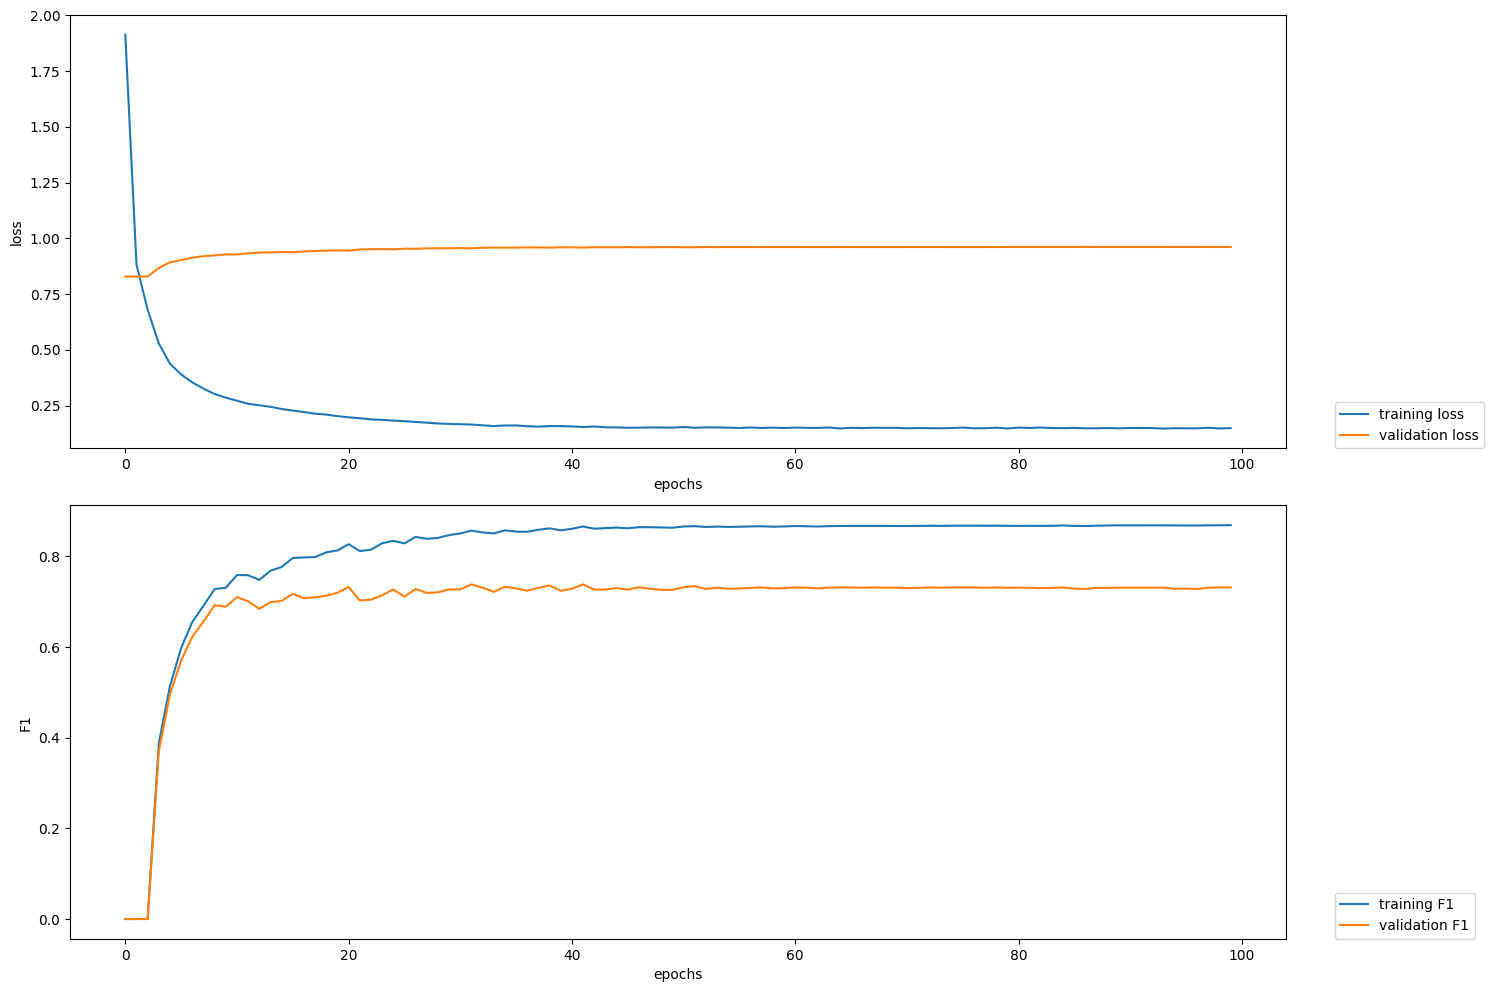

100%|██████████| 24/24 [00:10<00:00,  2.34it/s]

2023-04-21 17:56:11,419 Evaluating as a multi-label problem: True



100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

2023-04-21 17:56:15,864 Evaluating as a multi-label problem: False



100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

2023-04-21 17:56:17,232 Evaluating as a multi-label problem: True


,split,index,I-ADR,B-ADR,B-Drug,B-Symptom,B-Finding,I-Finding,B-Disease,I-Drug,I-Symptom,I-Disease,micro avg,macro avg,weighted avg,samples avg
0,train,precision,0.799583,0.811342,0.931601,0.0,0.389189,0.347222,0.407407,0.957143,0.0,0.666667,0.780802,0.531015,0.768763,0.138356
1,train,recall,0.915504,0.910866,0.975645,0.0,0.233010,0.071633,0.047619,0.416149,0.0,0.011834,0.834097,0.358226,0.834097,0.138324
2,train,f1-score,0.853626,0.858228,0.953114,0.0,0.291498,0.118765,0.085271,0.580087,0.0,0.023256,0.806570,0.376384,0.789564,0.138335
3,train,support,7953.000000,4712.000000,1396.000000,222.0,309.000000,349.000000,231.000000,161.000000,218.0,169.000000,15720.000000,15720.000000,15720.000000,15720.000000
4,dev,precision,0.668464,0.747956,0.916667,0.0,0.466667,0.500000,0.375000,0.785714,0.0,0.000000,0.679946,0.446047,0.673295,NaN
5,dev,recall,0.770186,0.843318,0.956522,0.0,0.218750,0.092593,0.096774,0.407407,0.0,0.000000,0.727009,0.338555,0.727009,NaN
6,dev,f1-score,0.715729,0.792780,0.936170,0.0,0.297872,0.156250,0.153846,0.536585,0.0,0.000000,0.702690,0.358923,0.690468,NaN
7,dev,support,966.000000,651.000000,184.000000,25.0,64.000000,54.000000,31.000000,27.000000,36.0,28.000000,2066.000000,2066.000000,2066.000000,NaN
8,test,precision,0.713499,0.747678,0.886555,0.0,0.318182,0.333333,0.500000,0.900000,0.0,0.000000,0.740247,0.439925,0.703930,0.126669
9,test,recall,0.803516,0.838542,0.963470,0.0,0.134615,0.055556,0.050000,0.346154,0.0,0.000000,0.753645,0.319185,0.753645,0.126584


In [17]:
print(suf)

os.mkdir('flair_ner_model'+suf+'/classification_report')
plotter.plot_training_curves('flair_ner_model'+suf+'/loss.tsv')

# evaluate the tagger on the test set
result = tagger.evaluate(corpus.train, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=40,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/train.txt', 'w').write(str(result))
res1 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res1.insert(loc=0, column='split', value='train')

result = tagger.evaluate(corpus.dev, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=40,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/dev.txt', 'w').write(str(result))
res2 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res2.insert(loc=0, column='split', value='dev')

result = tagger.evaluate(corpus.test, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=40,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/test.txt', 'w').write(str(result))
res3 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res3.insert(loc=0, column='split', value='test')

res = pd.concat([res1,res2,res3],ignore_index=True)
res.to_csv('flair_ner_model'+suf+'/classification_report.csv',index=False)
res

In [18]:
# import time
# start_time = time.time()
# while time.time() - start_time < 1:
#     time.sleep(1)
# print('Session has timed out (2 minutes). Disconnecting...')
# !kill -9 -1

Layering can be a good idea if the NER tags in the first layer have their own set of dependent values in the second layer. This can help capture more information about the entities being recognized and provide more context for downstream tasks. However, it also increases the complexity of the annotation and the training process, so it should be used judiciously. In general, it's a good idea to start with a simple tag scheme and gradually increase complexity as needed.

    does it really matter if u use the E header

It depends on the specific task and the requirements of the downstream model. In some cases, using the E tag can help disambiguate between overlapping entities, while in other cases it may not be necessary or even desired. Ultimately, it's up to the developer to determine the appropriate tagging scheme for their specific use case.

    would adding POS as an extra NER layer help model performance or not

Adding POS as an extra NER layer may or may not help model performance, depending on the specific use case and data being analyzed.

On one hand, incorporating POS tags could provide additional context to the model and help it better distinguish between named entities and other parts of speech. For example, knowing that a word is a noun or verb could help the model determine if it is likely to be a named entity or not.

On the other hand, adding an additional layer could also increase model complexity and training time without necessarily improving performance. It may also require additional manual annotation efforts to create a labeled dataset with both NER and POS tags.

Ultimately, whether to include POS as an additional layer will depend on the specific requirements and goals of the project, as well as the available data and resources.

    besides bioes ordering (which is up-to-down), it doesn't matter what order the tags in the same domain appear in left-to-right?

Yes, that is correct. As long as the BIOES order is maintained vertically, the order of tags in the same domain from left-to-right should not impact training in flai

    different typenames must be treated as separate tasks?

Yes, that's correct. Different typenames should be treated as separate tasks because they represent different types of annotations that you want to predict. For example, in a biomedical NER task, you might want to predict the entity types of both drugs and diseases, which would be represented by two different typenames in your annotation data. Predicting both types of entities would require different models and possibly different evaluation metrics.